In [1]:
### INTEGRATED ANALYSIS 1: TILs VS GENOMIC VARIABLES ################

# Import libraries to work with dataframes
import numpy as np  # Library for numerical computations and arrays
import pandas as pd  # Library for data manipulation and analysis
import matplotlib.pyplot as plt  # Library for creating visualizations and plots

# I read the file containing the samples with all type of data available (complete or partial): gold standard results+genomic+clinical+TILs
path='/home/vant/TFM/Final_db/Samples_alltypedata_annotated.xlsx'  
df=pd.read_excel(path)
# See dataframe characteristics (columns names, type of values and number of null values in each column)
print(df.info()) 

######## Firstly we reclassify misclassified samples according the predictor  #######################

# Change the values to 'MMRp' for samples 'LP20', 'LP26', and 'MDA15'
# We use .loc[] to access specific rows where 'ID_CNIO' matches one of the specified samples
df.loc[df['ID_CNIO'].isin(['LP20', 'LP26', 'MDA15']), 'MMR_final_status'] = 'MMRp'

# Change the values to 'MMRd' for samples 'MDA26' and 'OVE28'. 'OVE28' is not misclassified according Diego's previous work
df.loc[df['ID_CNIO'].isin(['MDA26']), 'MMR_final_status'] = 'MMRd'

# Eliminate mixed case
df=df[df['ID_CNIO']!='RVB3']

 # Create a new DataFrame without the first two rows that only contain the descriptive and coding information
df = df.iloc[2:].reset_index(drop=True)

##### FACILITATE THE INTERPRETATION OF HISTOLOGY,FIGOL,GRADE AND RESIDUALa COLUMNS ##############

# Filter the DataFrame to keep only rows where 'TILs_CNIO_info' is not 'NO' and is not 'YES_only_tu' (Keep rows with complete info)
df= df[(df['TILs_CNIO_info'] != 'NO') & (df['TILs_CNIO_info']!='YES_only_tu')]  # N=156

# See the length
print("Length of the dataframe with samples that have TILs CNIO information:",len(df))

# Mapping dictionary for HISTOLOGY
category_mapping = {0: 'EOC', 1: 'CCOC', 2: 'Mixed', 3: 'Others'}

# Replace values in HISTOLOGY
df['HISTOLOGY'] = df['HISTOLOGY'].map(category_mapping)

# Mapping representative categories for FIGOL
df.loc[:,'FIGOL'] = df['FIGOL'].map({0: 'Localized', 1: 'Advanced'})

# Mapping GRADE values using .loc and convert it to a categorical type with a specific order
df.loc[:, 'GRADE'] = df['GRADE'].map({
    1: 'Well differentiated', 
    2: 'Moderately differentiated', 
    3: 'Poorly differentiated'
})
# Mapping representative categories for RESIDUALa
df.loc[:, 'RESIDUALa'] = df['RESIDUALa'].map({0: 'No', 1: 'Yes'})

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169 entries, 0 to 168
Data columns (total 56 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ID_CNIO                    169 non-null    object
 1   ID_ORIGINAL                165 non-null    object
 2   ID_ORIGINAL_NHC_BBANK      149 non-null    object
 3   HISTOLOGY                  169 non-null    object
 4   HISTOLOGY_DETAIL           169 non-null    object
 5   AGE                        169 non-null    object
 6   GRADE                      134 non-null    object
 7   FIGO                       163 non-null    object
 8   FIGOL                      163 non-null    object
 9   FIGOa                      163 non-null    object
 10  NEOADJUVANT_TREATMENT      113 non-null    object
 11  ADJUVANT_TREATMENT         154 non-null    object
 12  TYPE_ADJUVANT              123 non-null    object
 13  OTHER_ADJ_TREAT            9 non-null      object
 14  RESIDUAL  

In [2]:
### Necessary transformations and filtering to obtain dataframes of work ###############

### Dataframe with all samples (EOC+CC) is df. I filter to obtain one with only EOC samples and another one with only CC samples
df_eoc = df[df['HISTOLOGY'] == 'EOC']
df_cc = df[df['HISTOLOGY'] == 'CCOC']
print(f"Number of EOC+CC samples with complete TILs raw counts: {len(df)}")
print(f"Number of EOC samples with TILs raw counts: {len(df_eoc)}")
print(f"Number of CC samples with TILs raw counts: {len(df_cc)}")

### Dataframes with all samples (EOC+CC), EOC samples and CC samples including only MMRp cases 
df_all_mmrp=df[df['MMR_final_status']=='MMRp']
df_eoc_mmrp=df[(df['HISTOLOGY']=='EOC') & (df['MMR_final_status']=='MMRp')]
df_cc_mmrp=df[(df['HISTOLOGY']=='CCOC') & (df['MMR_final_status']=='MMRp')]

# Verify the number of samples in every category ALL MMRp, EOC MMRp and CC MMRp
print("Number of MMRp samples with TILs raw counts:", len(df_all_mmrp))
print("Number of MMRp EOC samples with TILs raw counts :", len(df_eoc_mmrp))
print("Number of MMRp CC samples with TILs raw counts:", len(df_cc_mmrp))

Number of EOC+CC samples with complete TILs raw counts: 156
Number of EOC samples with TILs raw counts: 84
Number of CC samples with TILs raw counts: 72
Number of MMRp samples with TILs raw counts: 141
Number of MMRp EOC samples with TILs raw counts : 74
Number of MMRp CC samples with TILs raw counts: 67


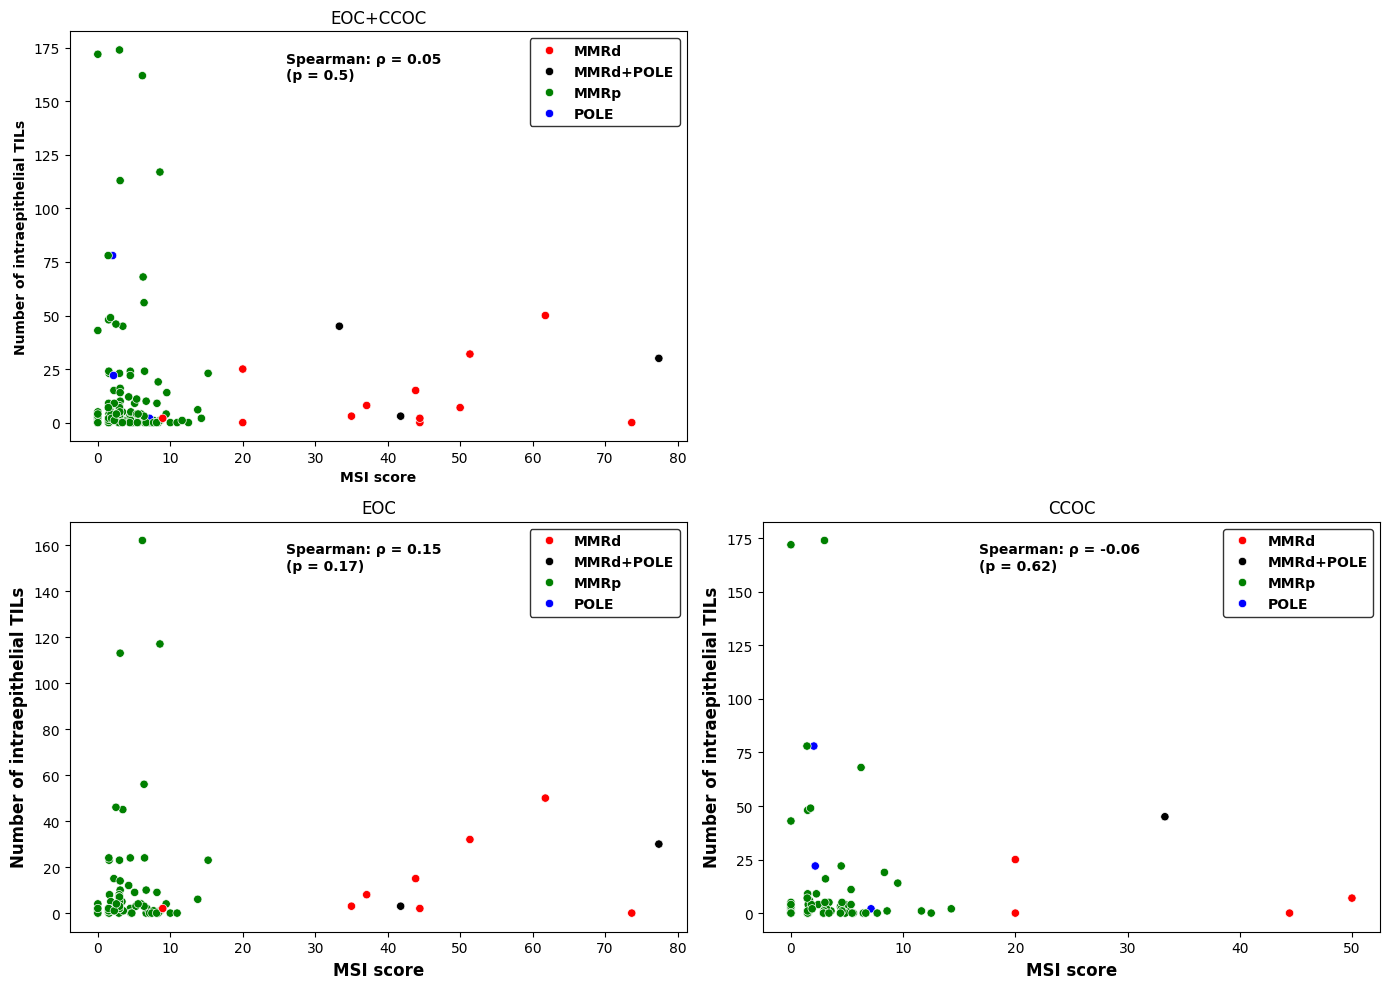

In [13]:
########    Plots to analyse the relation between MSI score and 'TILs_raw_ep' ########################

# Import necessary libraries
import seaborn as sns
from scipy.stats import spearmanr, pearsonr, shapiro
import matplotlib.pyplot as plt

# Function to calculate correlation and add annotation to the plot
def add_correlation_annotation(ax, x, y, data):
    """
    Checks for normality and adds the appropriate correlation annotation to the plot.

    Parameters:
    - ax: The axis of the plot to annotate.
    - x: Column name for the x-axis variable.
    - y: Column name for the y-axis variable.
    - data: DataFrame containing the data.
    """
    # Drop NaN values for the x and y columns
    data_clean = data[[x, y]].dropna()
    
    # Perform Shapiro-Wilk test for normality
    stat_x, p_x = shapiro(data_clean[x])
    stat_y, p_y = shapiro(data_clean[y])
    
    # Check if both variables are normally distributed
    if p_x > 0.05 and p_y > 0.05:
        # Use Pearson correlation if normality is confirmed
        coef, p_value = pearsonr(data_clean[x], data_clean[y])
        method = "Pearson"
    else:
        # Use Spearman correlation if normality is not confirmed
        coef, p_value = spearmanr(data_clean[x], data_clean[y])
        method = "Spearman"
    
    # Format the annotation text
    correlation_text = f"{method}: ρ = {coef:.2f}\n(p = {p_value:.2g})"
    # Add the annotation to the top-left corner of the plot
    ax.text(0.35, 0.95, correlation_text, fontsize=10, fontweight='bold',
            transform=ax.transAxes, verticalalignment='top', color='black')

# Create a figure with 2 rows and 2 columns of subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: MSI score vs TILs_raw_ep for EOC+CC (top-left subplot)
sns.scatterplot(
    ax=axes[0, 0],
    data=df,
    x='MSI_sensor2',
    y='TILs_raw_ep',
    hue='category',
    palette={'MMRd+POLE': 'black', 'POLE': 'blue', 'MMRd': 'red', 'MMRp': 'green'},
    legend='full'
)
axes[0, 0].set_title('EOC+CCOC')
axes[0, 0].set_xlabel('MSI score', fontweight='bold')
axes[0, 0].set_ylabel('Number of intraepithelial TILs', fontweight='bold')
# Add correlation annotation for EOC+CC
add_correlation_annotation(axes[0, 0], 'MSI_sensor2', 'TILs_raw_ep', df)

# Remove the unused subplot (top-right subplot)
fig.delaxes(axes[0, 1])

# Plot 2: MSI score vs TILs_raw_ep for EOC (bottom-left subplot)
sns.scatterplot(
    ax=axes[1, 0],
    data=df_eoc,
    x='MSI_sensor2',
    y='TILs_raw_ep',
    hue='category',
    palette={'MMRd+POLE': 'black', 'POLE': 'blue', 'MMRd': 'red', 'MMRp': 'green'},
    legend='full'
)
axes[1, 0].set_title('EOC')
axes[1, 0].set_xlabel('MSI score', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Number of intraepithelial TILs', fontsize=12, fontweight='bold')
# Add correlation annotation for EOC
add_correlation_annotation(axes[1, 0], 'MSI_sensor2', 'TILs_raw_ep', df_eoc)

# Plot 3: MSI score vs TILs_raw_ep for CC (bottom-right subplot)
sns.scatterplot(
    ax=axes[1, 1],
    data=df_cc,
    x='MSI_sensor2',
    y='TILs_raw_ep',
    hue='category',
    palette={'MMRd+POLE': 'black', 'POLE': 'blue', 'MMRd': 'red', 'MMRp': 'green'},
    legend='full'
)
axes[1, 1].set_title('CCOC')
axes[1, 1].set_xlabel('MSI score', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Number of intraepithelial TILs', fontsize=12, fontweight='bold')
# Add correlation annotation for CC
add_correlation_annotation(axes[1, 1], 'MSI_sensor2', 'TILs_raw_ep', df_cc)

# Adjust legends: bold text and remove 'category' from labels
for ax in [axes[0, 0], axes[1, 0], axes[1, 1]]:
    handles, labels = ax.get_legend_handles_labels()
    new_labels = [label.split('category: ')[-1] for label in labels]  # Remove "category: "
    ax.legend(
        handles, new_labels,
        loc='upper right',
        fontsize=10,
        title_fontsize=12,
        frameon=True,
        facecolor='white',
        edgecolor='black',
        prop={'weight': 'bold'}  # Bold legend text
    )

# Adjust layout to avoid overlap between subplots
plt.tight_layout()

# Save the plot as a PNG file
plt.savefig("/home/vant/TFM/Plots_TFM_final/MSI_vs_TILS_ep.png", format='png', dpi=300)

# Display the plot
plt.show()

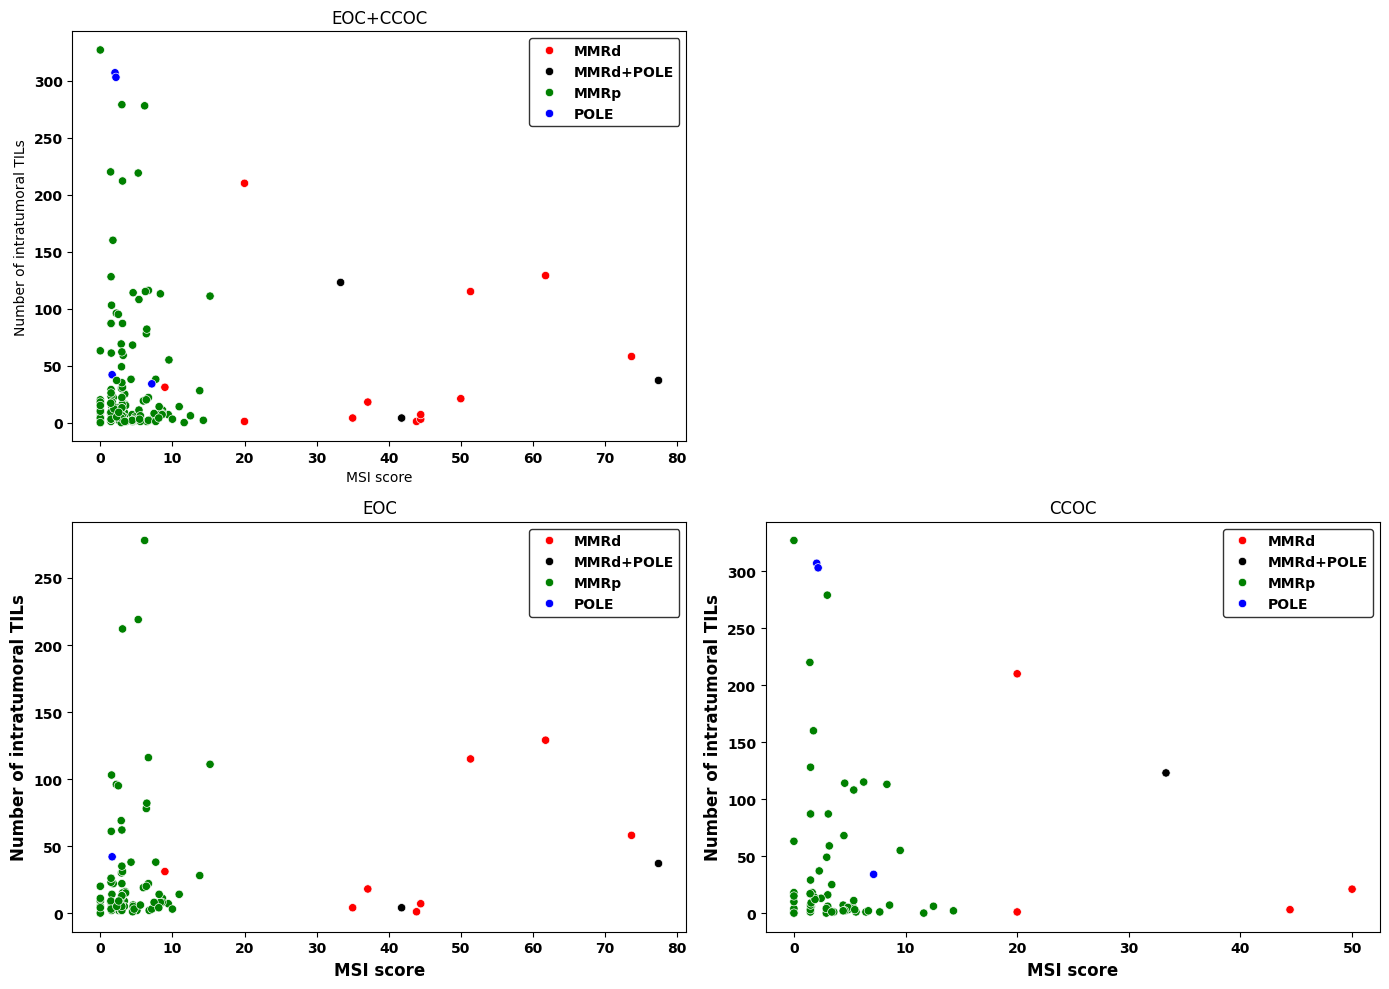

In [14]:
#########    Plots to analyse the relation between MSI score and 'TILs_raw_tu' ########################

# Uncomment to import if not done previously
# import seaborn as sns


# Create a figure with 2 rows and 2 columns of subplots (last cell will remain empty)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # Set figure size for better visibility

# Function to assign colors and categories for legend
def assign_colors_and_labels(row):
    if row['Pol_mutation'] != 'NO' and row['MMR_final_status'] == 'MMRd':
        return 'black', 'MMRd+POLE'  # Black for MMRd + POLE
    elif row['Pol_mutation'] != 'NO':
        return 'blue', 'POLE'  # Blue for POLE
    elif row['MMR_final_status'] == 'MMRd':
        return 'red', 'MMRd'  # Red for MMRd
    else:
        return 'green', 'MMRp'  # Green for MMRp

# Ensure the DataFrames are independent copies
df = df.copy()
df_eoc = df_eoc.copy()
df_cc = df_cc.copy()

# Use assign to add 'color' and 'category' columns
df = df.assign(
    color=df.apply(lambda row: assign_colors_and_labels(row)[0], axis=1),
    category=df.apply(lambda row: assign_colors_and_labels(row)[1], axis=1)
)

df_eoc = df_eoc.assign(
    color=df_eoc.apply(lambda row: assign_colors_and_labels(row)[0], axis=1),
    category=df_eoc.apply(lambda row: assign_colors_and_labels(row)[1], axis=1)
)

df_cc = df_cc.assign(
    color=df_cc.apply(lambda row: assign_colors_and_labels(row)[0], axis=1),
    category=df_cc.apply(lambda row: assign_colors_and_labels(row)[1], axis=1)
)

# Convert 'category' column to a categorical type
df['category'] = df['category'].astype('category')
df_eoc['category'] = df_eoc['category'].astype('category')
df_cc['category'] = df_cc['category'].astype('category')

# Plot 1: MSI score vs TILs_raw_tu for EOC+CC (top-left subplot)
sns.scatterplot(
    ax=axes[0, 0],
    data=df,
    x='MSI_sensor2',
    y='TILs_raw_tu',
    hue='category',
    palette={'MMRd+POLE': 'black', 'POLE': 'blue', 'MMRd': 'red', 'MMRp': 'green'},
    legend='full'
)
axes[0, 0].set_title('EOC+CCOC')  # Add title
axes[0, 0].set_xlabel('MSI score')  # Label for the x-axis
axes[0, 0].set_ylabel('Number of intratumoral TILs')  # Label for the y-axis

# Remove the empty subplot (top-right subplot)
fig.delaxes(axes[0, 1])  # Deletes the unused subplot in the top-right corner

# Plot 2: MSI score vs TILs_raw_ep for EOC (bottom-left subplot)
sns.scatterplot(
    ax=axes[1, 0],
    data=df_eoc,
    x='MSI_sensor2',
    y='TILs_raw_tu',
    hue='category',
    palette={'MMRd+POLE': 'black', 'POLE': 'blue', 'MMRd': 'red', 'MMRp': 'green'},
    legend='full'
)
axes[1, 0].set_title('EOC')  # Add title
axes[1, 0].set_xlabel('MSI score', fontsize=12, fontweight='bold')  # Label for the x-axis
axes[1, 0].set_ylabel('Number of intratumoral TILs', fontsize=12, fontweight='bold')  # Label for the y-axis

# Plot 3: MSI score vs TILs_raw_ep for CC (bottom-right subplot)
sns.scatterplot(
    ax=axes[1, 1],
    data=df_cc,
    x='MSI_sensor2',
    y='TILs_raw_tu',
    hue='category',
    palette={'MMRd+POLE': 'black', 'POLE': 'blue', 'MMRd': 'red', 'MMRp': 'green'},
    legend='full'
)
axes[1, 1].set_title('CCOC')  # Add title
axes[1, 1].set_xlabel('MSI score', fontsize=12, fontweight='bold')  # Label for the x-axis
axes[1, 1].set_ylabel('Number of intratumoral TILs', fontsize=12, fontweight='bold')  # Label for the y-axis
# Adjust tick labels for all subplots
for ax in axes.flat:
    if ax is not None:  # Check if the subplot exists
        # Set properties for tick labels on both axes
        for label in ax.get_xticklabels() + ax.get_yticklabels():
            label.set_fontsize(10)
            label.set_fontweight('bold')

        # Adjust legend: remove 'category' and set fontweight to bold
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, 
                  loc='upper right', 
                  fontsize=10, 
                  title_fontsize=12, 
                  frameon=True,  # Add a frame around the legend
                  facecolor='white',  # Background color inside the legend box
                  edgecolor='black', # Border color around the legend box
                  prop={'weight': 'bold'})  # Make legend text bold

# Adjust layout to prevent overlap between subplots
plt.tight_layout()

# Save the entire figure as a PNG file
plt.savefig("/home/vant/TFM/Plots_TFM_final/MSI_vs_TILS_tu.png", format='png',dpi=300)

# Display the figure
plt.show()


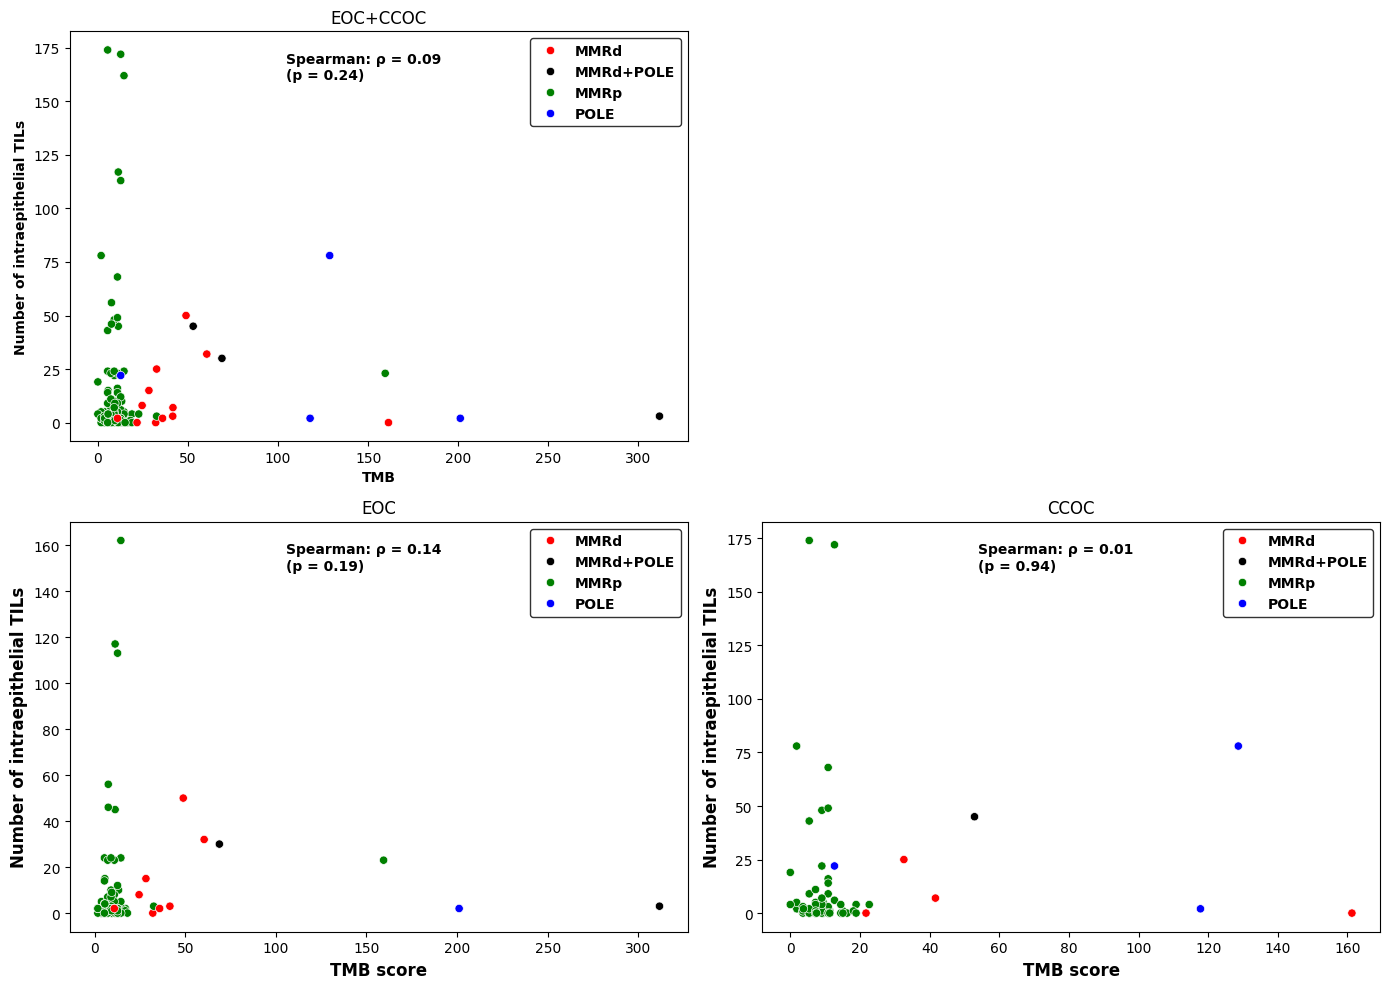

In [15]:
## Plots to analyse the relation between TMB score and 'TILs_raw_ep' ########################

# Uncomment to import if not done previously
# import seaborn as sns
#from scipy.stats import spearmanr, pearsonr, shapiro
#import matplotlib.pyplot as plt

import seaborn as sns
from scipy.stats import spearmanr, pearsonr, shapiro
import matplotlib.pyplot as plt

# Function to calculate correlation and add annotation to the plot
def add_correlation_annotation(ax, x, y, data):
    """
    Checks for normality and adds the appropriate correlation annotation to the plot.

    Parameters:
    - ax: The axis of the plot to annotate.
    - x: Column name for the x-axis variable.
    - y: Column name for the y-axis variable.
    - data: DataFrame containing the data.
    """
    # Drop NaN values for the x and y columns
    data_clean = data[[x, y]].dropna()
    
    # Perform Shapiro-Wilk test for normality
    stat_x, p_x = shapiro(data_clean[x])
    stat_y, p_y = shapiro(data_clean[y])
    
    # Check if both variables are normally distributed
    if p_x > 0.05 and p_y > 0.05:
        # Use Pearson correlation if normality is confirmed
        coef, p_value = pearsonr(data_clean[x], data_clean[y])
        method = "Pearson"
    else:
        # Use Spearman correlation if normality is not confirmed
        coef, p_value = spearmanr(data_clean[x], data_clean[y])
        method = "Spearman"
    
    # Format the annotation text
    correlation_text = f"{method}: ρ = {coef:.2f}\n(p = {p_value:.2g})"
    # Add the annotation to the top-left corner of the plot
    ax.text(0.35, 0.95, correlation_text, fontsize=10, fontweight='bold',
            transform=ax.transAxes, verticalalignment='top', color='black')

# Create a figure with 2 rows and 2 columns of subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: TMB vs TILs_raw_ep for EOC+CC (top-left subplot)
sns.scatterplot(
    ax=axes[0, 0],
    data=df,
    x='TMB',
    y='TILs_raw_ep',
    hue='category',
    palette={'MMRd+POLE': 'black', 'POLE': 'blue', 'MMRd': 'red', 'MMRp': 'green'},
    legend='full'
)
axes[0, 0].set_title('EOC+CCOC')
axes[0, 0].set_xlabel('TMB', fontweight='bold')
axes[0, 0].set_ylabel('Number of intraepithelial TILs', fontweight='bold')
# Add correlation annotation for EOC+CC
add_correlation_annotation(axes[0, 0], 'TMB', 'TILs_raw_ep', df)

# Remove the unused subplot (top-right subplot)
fig.delaxes(axes[0, 1])

# Plot 2: TMB vs TILs_raw_ep for EOC (bottom-left subplot)
sns.scatterplot(
    ax=axes[1, 0],
    data=df_eoc,
    x='TMB',
    y='TILs_raw_ep',
    hue='category',
    palette={'MMRd+POLE': 'black', 'POLE': 'blue', 'MMRd': 'red', 'MMRp': 'green'},
    legend='full'
)
axes[1, 0].set_title('EOC')
axes[1, 0].set_xlabel('TMB score', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Number of intraepithelial TILs', fontsize=12, fontweight='bold')
# Add correlation annotation for EOC
add_correlation_annotation(axes[1, 0], 'TMB', 'TILs_raw_ep', df_eoc)

# Plot 3: TMB vs TILs_raw_ep for CC (bottom-right subplot)
sns.scatterplot(
    ax=axes[1, 1],
    data=df_cc,
    x='TMB',
    y='TILs_raw_ep',
    hue='category',
    palette={'MMRd+POLE': 'black', 'POLE': 'blue', 'MMRd': 'red', 'MMRp': 'green'},
    legend='full'
)
axes[1, 1].set_title('CCOC')
axes[1, 1].set_xlabel('TMB score', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Number of intraepithelial TILs', fontsize=12, fontweight='bold')
# Add correlation annotation for CC
add_correlation_annotation(axes[1, 1], 'TMB', 'TILs_raw_ep', df_cc)

# Adjust legends: bold text and remove 'category' from labels
for ax in [axes[0, 0], axes[1, 0], axes[1, 1]]:
    handles, labels = ax.get_legend_handles_labels()
    new_labels = [label.split('category: ')[-1] for label in labels]  # Remove "category: "
    ax.legend(
        handles, new_labels,
        loc='upper right',
        fontsize=10,
        title_fontsize=12,
        frameon=True,
        facecolor='white',
        edgecolor='black',
        prop={'weight': 'bold'}  # Bold legend text
    )

# Adjust layout to avoid overlap between subplots
plt.tight_layout()

# Save the plot as a PNG file
plt.savefig("/home/vant/TFM/Plots_TFM_final/TMB_vs_TILS_ep.png", format='png', dpi=300)

# Display the plot
plt.show()

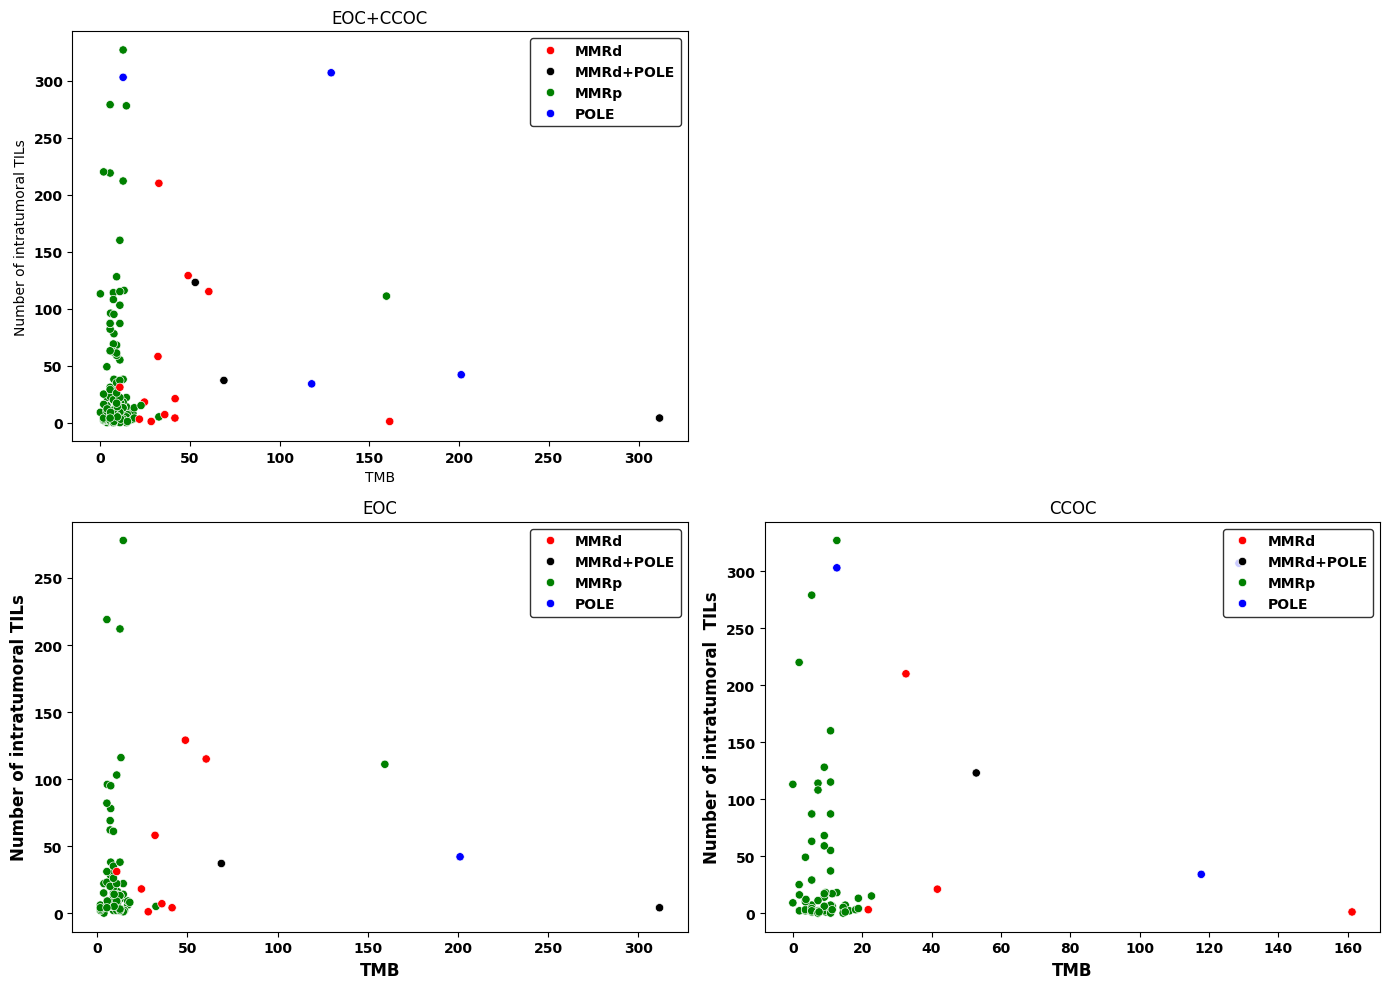

In [19]:
## Plots to analyse the relation between TMB score and 'TILs_raw_tu' ########################

# Uncomment to import if not done previously
# import seaborn as sns

# Create a figure with 2 rows and 2 columns of subplots (last cell will remain empty)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # Set figure size for better visibility

# Function to assign colors and categories for legend
def assign_colors_and_labels(row):
    if row['Pol_mutation'] != 'NO' and row['MMR_final_status'] == 'MMRd':
        return 'black', 'MMRd+POLE'  # Black for MMRd + POLE
    elif row['Pol_mutation'] != 'NO':
        return 'blue', 'POLE'  # Blue for POLE
    elif row['MMR_final_status'] == 'MMRd':
        return 'red', 'MMRd'  # Red for MMRd
    else:
        return 'green', 'MMRp'  # Green for MMRp

# Ensure the DataFrames are independent copies
df = df.copy()
df_eoc = df_eoc.copy()
df_cc = df_cc.copy()

# Use assign to add 'color' and 'category' columns
df = df.assign(
    color=df.apply(lambda row: assign_colors_and_labels(row)[0], axis=1),
    category=df.apply(lambda row: assign_colors_and_labels(row)[1], axis=1)
)

df_eoc = df_eoc.assign(
    color=df_eoc.apply(lambda row: assign_colors_and_labels(row)[0], axis=1),
    category=df_eoc.apply(lambda row: assign_colors_and_labels(row)[1], axis=1)
)

df_cc = df_cc.assign(
    color=df_cc.apply(lambda row: assign_colors_and_labels(row)[0], axis=1),
    category=df_cc.apply(lambda row: assign_colors_and_labels(row)[1], axis=1)
)

# Convert 'category' column to a categorical type
df['category'] = df['category'].astype('category')
df_eoc['category'] = df_eoc['category'].astype('category')
df_cc['category'] = df_cc['category'].astype('category')

# Plot 1: TMB vs TILs_raw_tu for EOC+CC (top-left subplot)
sns.scatterplot(
    ax=axes[0, 0],
    data=df,
    x='TMB',
    y='TILs_raw_tu',
    hue='category',
    palette={'MMRd+POLE': 'black', 'POLE': 'blue', 'MMRd': 'red', 'MMRp': 'green'},
    legend='full'
)
axes[0, 0].set_title('EOC+CCOC')  # Add title
axes[0, 0].set_xlabel('TMB')  # Label for the x-axis
axes[0, 0].set_ylabel('Number of intratumoral TILs')  # Label for the y-axis

# Remove the empty subplot (top-right subplot)
fig.delaxes(axes[0, 1])  # Deletes the unused subplot in the top-right corner

# Plot 2: TMB vs TILs_raw_tu for EOC (bottom-left subplot)
sns.scatterplot(
    ax=axes[1, 0],
    data=df_eoc,
    x='TMB',
    y='TILs_raw_tu',
    hue='category',
    palette={'MMRd+POLE': 'black', 'POLE': 'blue', 'MMRd': 'red', 'MMRp': 'green'},
    legend='full'
)
axes[1, 0].set_title('EOC')  # Add title
axes[1, 0].set_xlabel('TMB', fontsize=12, fontweight='bold')  # Label for the x-axis
axes[1, 0].set_ylabel('Number of intratumoral TILs', fontsize=12, fontweight='bold')  # Label for the y-axis

# Plot 3: TMB vs TILs_raw_tu for CC (bottom-right subplot)
sns.scatterplot(
    ax=axes[1, 1],
    data=df_cc,
    x='TMB',
    y='TILs_raw_tu',
    hue='category',
    palette={'MMRd+POLE': 'black', 'POLE': 'blue', 'MMRd': 'red', 'MMRp': 'green'},
    legend='full'
)
axes[1, 1].set_title('CCOC')  # Add title
axes[1, 1].set_xlabel('TMB', fontsize=12, fontweight='bold')  # Label for the x-axis
axes[1, 1].set_ylabel('Number of intratumoral  TILs', fontsize=12, fontweight='bold')  # Label for the y-axis
# Adjust tick labels for all subplots
for ax in axes.flat:
    if ax is not None:  # Check if the subplot exists
        # Set properties for tick labels on both axes
        for label in ax.get_xticklabels() + ax.get_yticklabels():
            label.set_fontsize(10)
            label.set_fontweight('bold')

        # Adjust legend: remove 'category' and set fontweight to bold
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, 
                  loc='upper right', 
                  fontsize=10, 
                  title_fontsize=12, 
                  frameon=True,  # Add a frame around the legend
                  facecolor='white',  # Background color inside the legend box
                  edgecolor='black', # Border color around the legend box
                  prop={'weight': 'bold'})  # Make legend text bold
# Adjust layout to prevent overlap between subplots
plt.tight_layout()

# Save the entire figure as a PNG file
plt.savefig("/home/vant/TFM/Plots_TFM_final/TMB_vs_TILS_tu.png", format='png',dpi=300)

# Display the figure
plt.show()

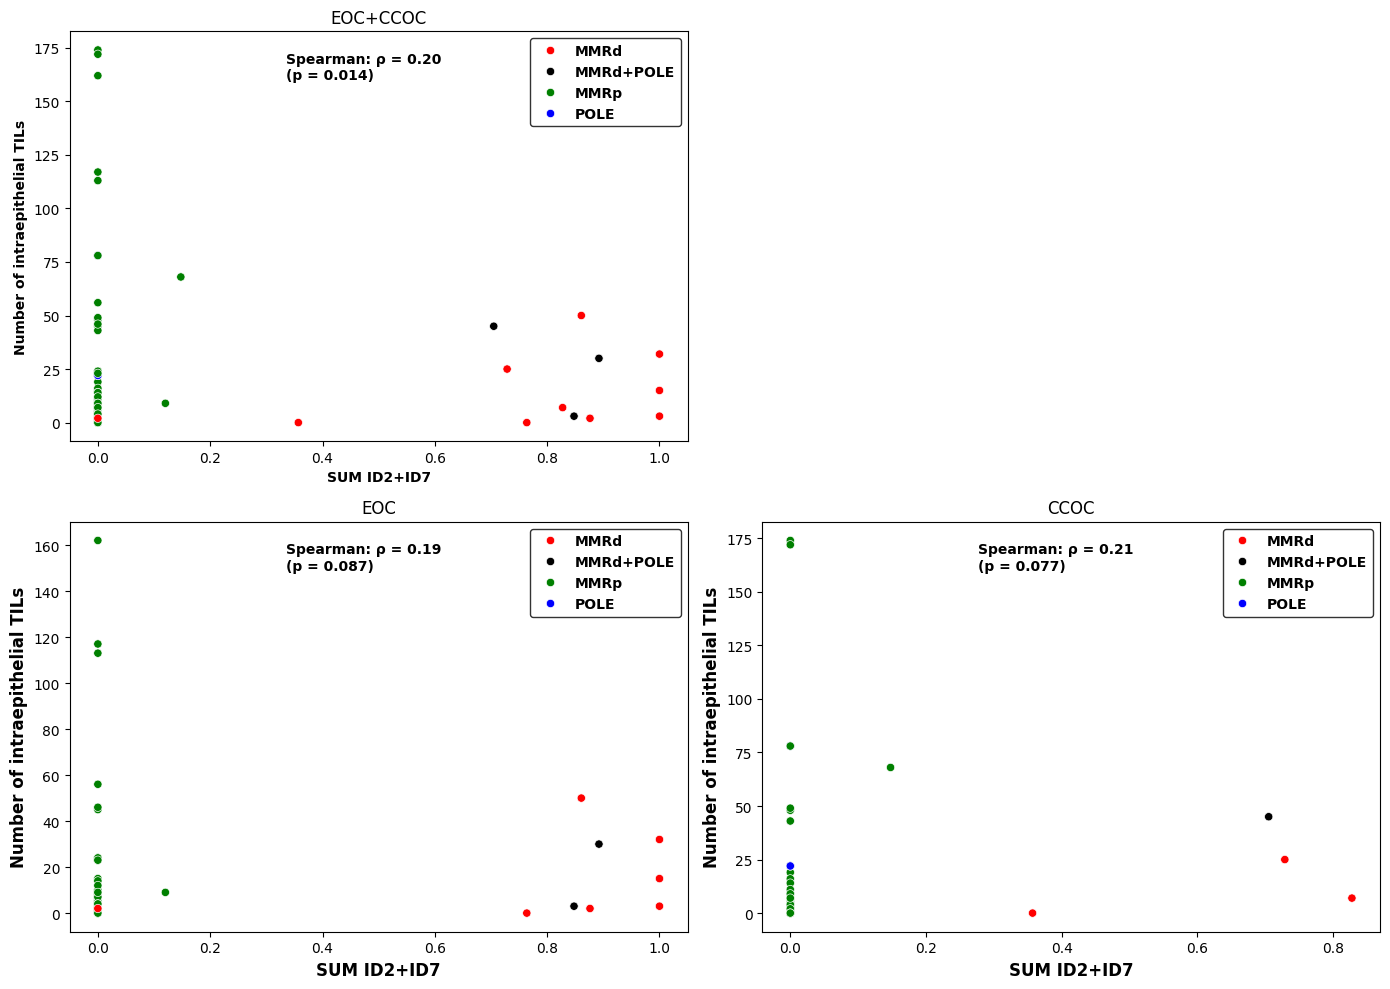

In [20]:
#########    Plots to analyse the relation between 'SUM ID2+ID7' and 'TILs_raw_ep' ########################

# Uncomment to import if not done previously
# import seaborn as sns

import seaborn as sns
from scipy.stats import spearmanr, pearsonr, shapiro
import matplotlib.pyplot as plt

# Function to calculate correlation and add annotation to the plot
def add_correlation_annotation(ax, x, y, data):
    """
    Checks for normality and adds the appropriate correlation annotation to the plot.

    Parameters:
    - ax: The axis of the plot to annotate.
    - x: Column name for the x-axis variable.
    - y: Column name for the y-axis variable.
    - data: DataFrame containing the data.
    """
    # Drop NaN values for the x and y columns
    data_clean = data[[x, y]].dropna()
    
    # Perform Shapiro-Wilk test for normality
    stat_x, p_x = shapiro(data_clean[x])
    stat_y, p_y = shapiro(data_clean[y])
    
    # Check if both variables are normally distributed
    if p_x > 0.05 and p_y > 0.05:
        # Use Pearson correlation if normality is confirmed
        coef, p_value = pearsonr(data_clean[x], data_clean[y])
        method = "Pearson"
    else:
        # Use Spearman correlation if normality is not confirmed
        coef, p_value = spearmanr(data_clean[x], data_clean[y])
        method = "Spearman"
    
    # Format the annotation text
    correlation_text = f"{method}: ρ = {coef:.2f}\n(p = {p_value:.2g})"
    # Add the annotation to the top-left corner of the plot
    ax.text(0.35, 0.95, correlation_text, fontsize=10, fontweight='bold',
            transform=ax.transAxes, verticalalignment='top', color='black')

# Create a figure with 2 rows and 2 columns of subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: SUM ID2+ID7 vs TILs_raw_ep for EOC+CC (top-left subplot)
sns.scatterplot(
    ax=axes[0, 0],
    data=df,
    x='SUM ID2+ID7',
    y='TILs_raw_ep',
    hue='category',
    palette={'MMRd+POLE': 'black', 'POLE': 'blue', 'MMRd': 'red', 'MMRp': 'green'},
    legend='full'
)
axes[0, 0].set_title('EOC+CCOC')
axes[0, 0].set_xlabel('SUM ID2+ID7', fontweight='bold')
axes[0, 0].set_ylabel('Number of intraepithelial TILs', fontweight='bold')
# Add correlation annotation for EOC+CC
add_correlation_annotation(axes[0, 0], 'SUM ID2+ID7', 'TILs_raw_ep', df)

# Remove the unused subplot (top-right subplot)
fig.delaxes(axes[0, 1])

# Plot 2: SUM ID2+ID7 vs TILs_raw_ep for EOC (bottom-left subplot)
sns.scatterplot(
    ax=axes[1, 0],
    data=df_eoc,
    x='SUM ID2+ID7',
    y='TILs_raw_ep',
    hue='category',
    palette={'MMRd+POLE': 'black', 'POLE': 'blue', 'MMRd': 'red', 'MMRp': 'green'},
    legend='full'
)
axes[1, 0].set_title('EOC')
axes[1, 0].set_xlabel('SUM ID2+ID7', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Number of intraepithelial TILs', fontsize=12, fontweight='bold')
# Add correlation annotation for EOC
add_correlation_annotation(axes[1, 0], 'SUM ID2+ID7', 'TILs_raw_ep', df_eoc)

# Plot 3: SUM ID2+ID7 vs TILs_raw_ep for CC (bottom-right subplot)
sns.scatterplot(
    ax=axes[1, 1],
    data=df_cc,
    x='SUM ID2+ID7',
    y='TILs_raw_ep',
    hue='category',
    palette={'MMRd+POLE': 'black', 'POLE': 'blue', 'MMRd': 'red', 'MMRp': 'green'},
    legend='full'
)
axes[1, 1].set_title('CCOC')
axes[1, 1].set_xlabel('SUM ID2+ID7', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Number of intraepithelial TILs', fontsize=12, fontweight='bold')
# Add correlation annotation for CC
add_correlation_annotation(axes[1, 1], 'SUM ID2+ID7', 'TILs_raw_ep', df_cc)

# Adjust legends: bold text and remove 'category' from labels
for ax in [axes[0, 0], axes[1, 0], axes[1, 1]]:
    handles, labels = ax.get_legend_handles_labels()
    new_labels = [label.split('category: ')[-1] for label in labels]  # Remove "category: "
    ax.legend(
        handles, new_labels,
        loc='upper right',
        fontsize=10,
        title_fontsize=12,
        frameon=True,
        facecolor='white',
        edgecolor='black',
        prop={'weight': 'bold'}  # Bold legend text
    )

# Adjust layout to avoid overlap between subplots
plt.tight_layout()

# Save the plot as a PNG file
plt.savefig("/home/vant/TFM/Plots_TFM_final/SUM_ID2_ID7_vs_TILS_ep.png", format='png', dpi=300)

# Display the plot
plt.show()


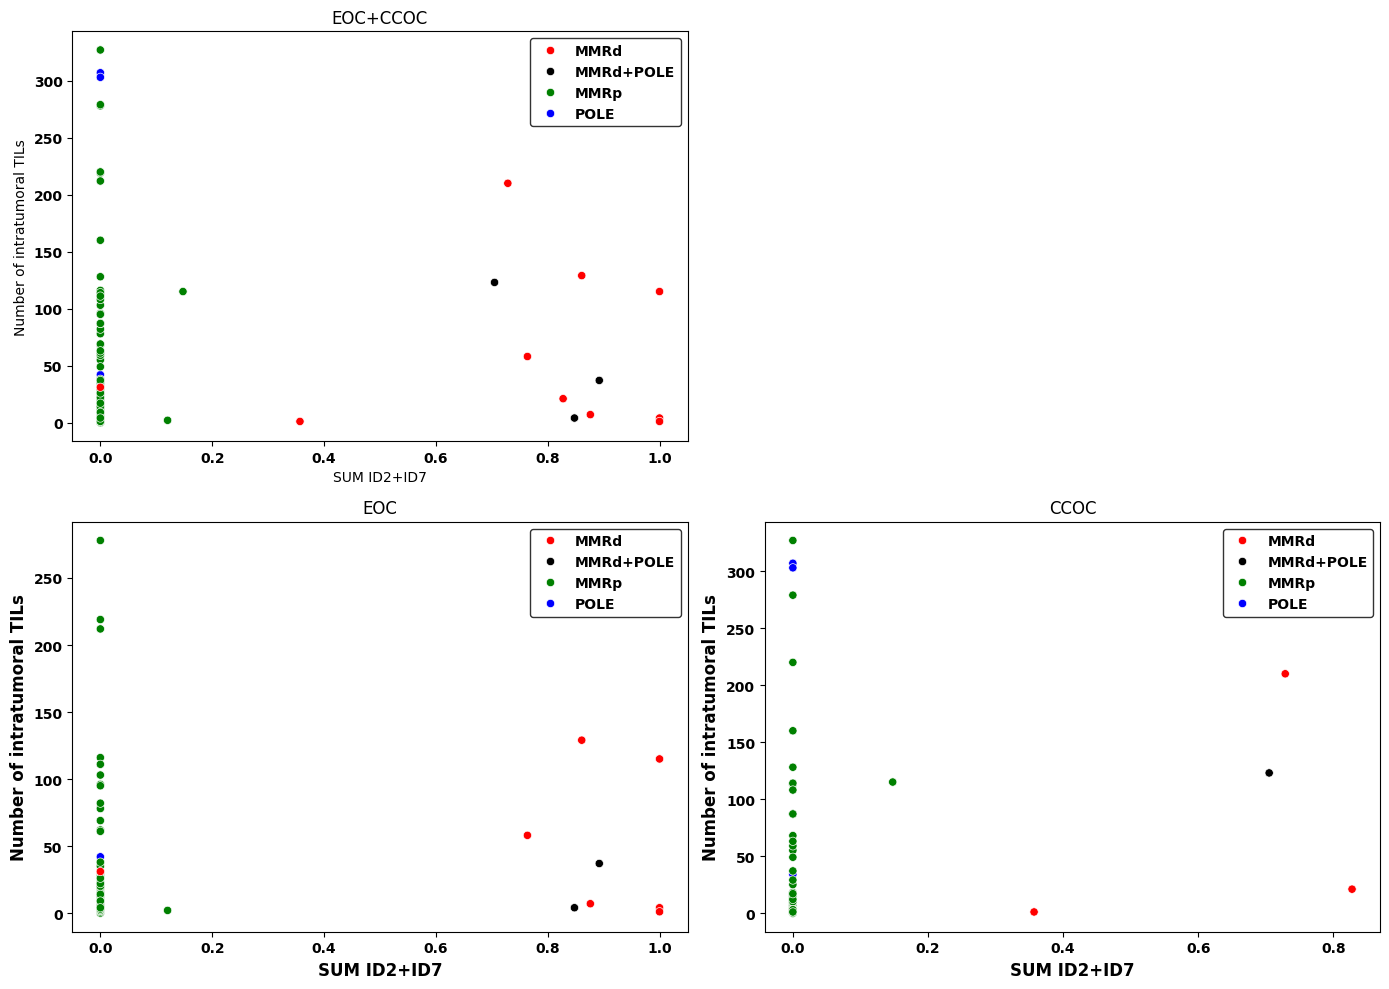

In [21]:
#########    Plots to analyse the relation between 'SUM ID2+ID7' and 'TILs_raw_tu' ########################

# Uncomment to import if not done previously
# import seaborn as sns

# Create a figure with 2 rows and 2 columns of subplots (last cell will remain empty)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # Set figure size for better visibility

# Function to assign colors and categories for legend
def assign_colors_and_labels(row):
    if row['Pol_mutation'] != 'NO' and row['MMR_final_status'] == 'MMRd':
        return 'black', 'MMRd+POLE'  # Black for MMRd + POLE
    elif row['Pol_mutation'] != 'NO':
        return 'blue', 'POLE'  # Blue for POLE
    elif row['MMR_final_status'] == 'MMRd':
        return 'red', 'MMRd'  # Red for MMRd
    else:
        return 'green', 'MMRp'  # Green for MMRp

# Use assign to add 'color' and 'category' columns
df = df.assign(
    color=df.apply(lambda row: assign_colors_and_labels(row)[0], axis=1),
    category=df.apply(lambda row: assign_colors_and_labels(row)[1], axis=1)
)

df_eoc = df_eoc.assign(
    color=df_eoc.apply(lambda row: assign_colors_and_labels(row)[0], axis=1),
    category=df_eoc.apply(lambda row: assign_colors_and_labels(row)[1], axis=1)
)

df_cc = df_cc.assign(
    color=df_cc.apply(lambda row: assign_colors_and_labels(row)[0], axis=1),
    category=df_cc.apply(lambda row: assign_colors_and_labels(row)[1], axis=1)
)

# Convert 'category' column to a categorical type
df['category'] = df['category'].astype('category')
df_eoc['category'] = df_eoc['category'].astype('category')
df_cc['category'] = df_cc['category'].astype('category')

# Plot 1: SUM ID2+ID7 vs TILs_raw_tu for EOC+CC (top-left subplot)
sns.scatterplot(
    ax=axes[0, 0],
    data=df,
    x='SUM ID2+ID7',
    y='TILs_raw_tu',
    hue='category',
    palette={'MMRd+POLE': 'black', 'POLE': 'blue', 'MMRd': 'red', 'MMRp': 'green'},
    legend='full'
)
axes[0, 0].set_title('EOC+CCOC')  # Add title
axes[0, 0].set_xlabel('SUM ID2+ID7')  # Label for the x-axis
axes[0, 0].set_ylabel('Number of intratumoral TILs')  # Label for the y-axis

# Remove the empty subplot (top-right subplot)
fig.delaxes(axes[0, 1])  # Deletes the unused subplot in the top-right corner

# Plot 2: SUM ID2+ID7 vs TILs_raw_tu for EOC (bottom-left subplot)
sns.scatterplot(
    ax=axes[1, 0],
    data=df_eoc,
    x='SUM ID2+ID7',
    y='TILs_raw_tu',
    hue='category',
    palette={'MMRd+POLE': 'black', 'POLE': 'blue', 'MMRd': 'red', 'MMRp': 'green'},
    legend='full'
)
axes[1, 0].set_title('EOC')  # Add title
axes[1, 0].set_xlabel('SUM ID2+ID7', fontsize=12, fontweight='bold')  # Label for the x-axis
axes[1, 0].set_ylabel('Number of intratumoral TILs', fontsize=12, fontweight='bold')  # Label for the y-axis

# Plot 3: SUM ID2+ID7 vs TILs_raw_tu for CC (bottom-right subplot)
sns.scatterplot(
    ax=axes[1, 1],
    data=df_cc,
    x='SUM ID2+ID7',
    y='TILs_raw_tu',
    hue='category',
    palette={'MMRd+POLE': 'black', 'POLE': 'blue', 'MMRd': 'red', 'MMRp': 'green'},
    legend='full'
)
axes[1, 1].set_title('CCOC')  # Add title
axes[1, 1].set_xlabel('SUM ID2+ID7', fontsize=12, fontweight='bold')  # Label for the x-axis
axes[1, 1].set_ylabel('Number of intratumoral TILs', fontsize=12, fontweight='bold')  # Label for the y-axis
# Adjust tick labels for all subplots
for ax in axes.flat:
    if ax is not None:  # Check if the subplot exists
        # Set properties for tick labels on both axes
        for label in ax.get_xticklabels() + ax.get_yticklabels():
            label.set_fontsize(10)
            label.set_fontweight('bold')

        # Adjust legend: remove 'category' and set fontweight to bold
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, 
                  loc='upper right', 
                  fontsize=10, 
                  title_fontsize=12, 
                  frameon=True,  # Add a frame around the legend
                  facecolor='white',  # Background color inside the legend box
                  edgecolor='black', # Border color around the legend box
                  prop={'weight': 'bold'})  # Make legend text bold
# Adjust layout to prevent overlap between subplots
plt.tight_layout()

# Save the entire figure as a PNG file
plt.savefig("Plots_TFM_final/Integrated_analysis_1/SUM_ID2_ID7_vs_TILS_tu.png", format='png',dpi=300)

# Display the figure
plt.show()

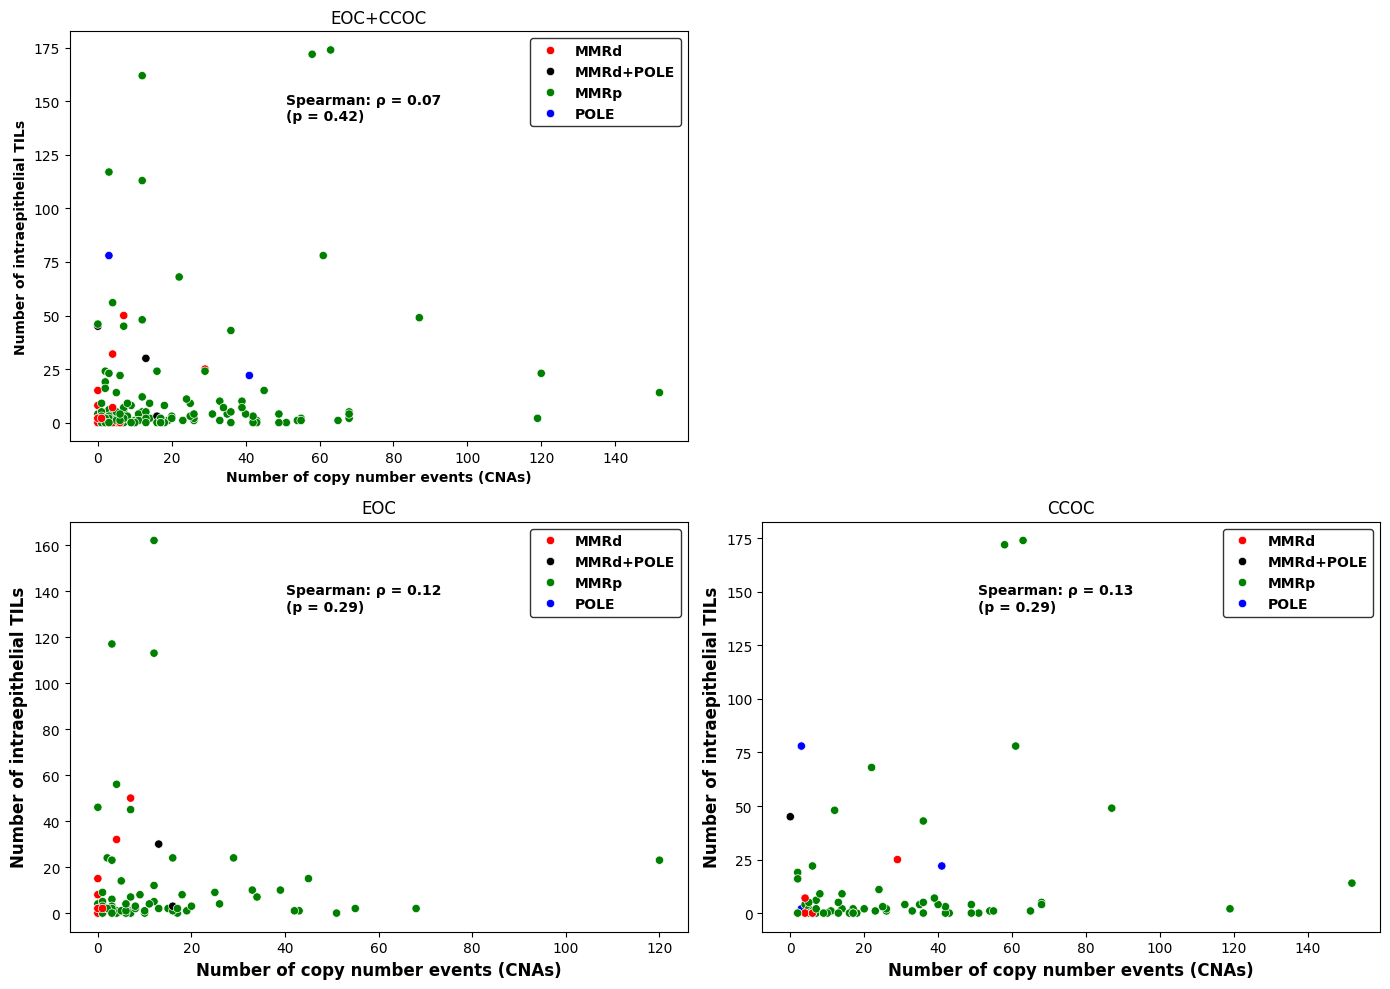

In [26]:
#########    Plots to analyse the relation between copy number aberrations (CNAs) and 'TILs_raw_ep' ########################

# Uncomment to import if not done previously
# import seaborn as sns
#from scipy.stats import spearmanr, pearsonr, shapiro
#import matplotlib.pyplot as plt

# Function to calculate correlation and add annotation to the plot
def add_correlation_annotation(ax, x, y, data):
    """
    Checks for normality and adds the appropriate correlation annotation to the plot.

    Parameters:
    - ax: The axis of the plot to annotate.
    - x: Column name for the x-axis variable.
    - y: Column name for the y-axis variable.
    - data: DataFrame containing the data.
    """
    # Drop NaN values for the x and y columns
    data_clean = data[[x, y]].dropna()
    
    # Perform Shapiro-Wilk test for normality
    stat_x, p_x = shapiro(data_clean[x])
    stat_y, p_y = shapiro(data_clean[y])
    
    # Check if both variables are normally distributed
    if p_x > 0.05 and p_y > 0.05:
        # Use Pearson correlation if normality is confirmed
        coef, p_value = pearsonr(data_clean[x], data_clean[y])
        method = "Pearson"
    else:
        # Use Spearman correlation if normality is not confirmed
        coef, p_value = spearmanr(data_clean[x], data_clean[y])
        method = "Spearman"
    
    # Format the annotation text
    correlation_text = f"{method}: ρ = {coef:.2f}\n(p = {p_value:.2g})"
    # Add the annotation to the top-left corner of the plot
    ax.text(0.35, 0.85, correlation_text, fontsize=10, fontweight='bold',
            transform=ax.transAxes, verticalalignment='top', color='black')

# Create a figure with 2 rows and 2 columns of subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: CNV vs TILs_raw_ep for EOC+CC (top-left subplot)
sns.scatterplot(
    ax=axes[0, 0],
    data=df,
    x='CNV',
    y='TILs_raw_ep',
    hue='category',
    palette={'MMRd+POLE': 'black', 'POLE': 'blue', 'MMRd': 'red', 'MMRp': 'green'},
    legend='full'
)
axes[0, 0].set_title('EOC+CCOC')
axes[0, 0].set_xlabel('Number of copy number events (CNAs)', fontweight='bold')
axes[0, 0].set_ylabel('Number of intraepithelial TILs', fontweight='bold')
# Add correlation annotation for EOC+CC
add_correlation_annotation(axes[0, 0], 'CNV', 'TILs_raw_ep', df)

# Remove the unused subplot (top-right subplot)
fig.delaxes(axes[0, 1])

# Plot 2: CNV vs TILs_raw_ep for EOC (bottom-left subplot)
sns.scatterplot(
    ax=axes[1, 0],
    data=df_eoc,
    x='CNV',
    y='TILs_raw_ep',
    hue='category',
    palette={'MMRd+POLE': 'black', 'POLE': 'blue', 'MMRd': 'red', 'MMRp': 'green'},
    legend='full'
)
axes[1, 0].set_title('EOC')
axes[1, 0].set_xlabel('Number of copy number events (CNAs)', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Number of intraepithelial TILs', fontsize=12, fontweight='bold')
# Add correlation annotation for EOC
add_correlation_annotation(axes[1, 0], 'CNV', 'TILs_raw_ep', df_eoc)

# Plot 3: CNV vs TILs_raw_ep for CC (bottom-right subplot)
sns.scatterplot(
    ax=axes[1, 1],
    data=df_cc,
    x='CNV',
    y='TILs_raw_ep',
    hue='category',
    palette={'MMRd+POLE': 'black', 'POLE': 'blue', 'MMRd': 'red', 'MMRp': 'green'},
    legend='full'
)
axes[1, 1].set_title('CCOC')
axes[1, 1].set_xlabel('Number of copy number events (CNAs)', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Number of intraepithelial TILs', fontsize=12, fontweight='bold')
# Add correlation annotation for CC
add_correlation_annotation(axes[1, 1], 'CNV', 'TILs_raw_ep', df_cc)

# Adjust legends: bold text and remove 'category' from labels
for ax in [axes[0, 0], axes[1, 0], axes[1, 1]]:
    handles, labels = ax.get_legend_handles_labels()
    new_labels = [label.split('category: ')[-1] for label in labels]  # Remove "category: "
    ax.legend(
        handles, new_labels,
        loc='upper right',
        fontsize=10,
        title_fontsize=12,
        frameon=True,
        facecolor='white',
        edgecolor='black',
        prop={'weight': 'bold'}  # Bold legend text
    )

# Adjust layout to avoid overlap between subplots
plt.tight_layout()

# Save the plot as a PNG file
plt.savefig("/home/vant/TFM/Plots_TFM_final/CNAs_vs_TILS_ep.png", format='png', dpi=300)

# Display the plot
plt.show()


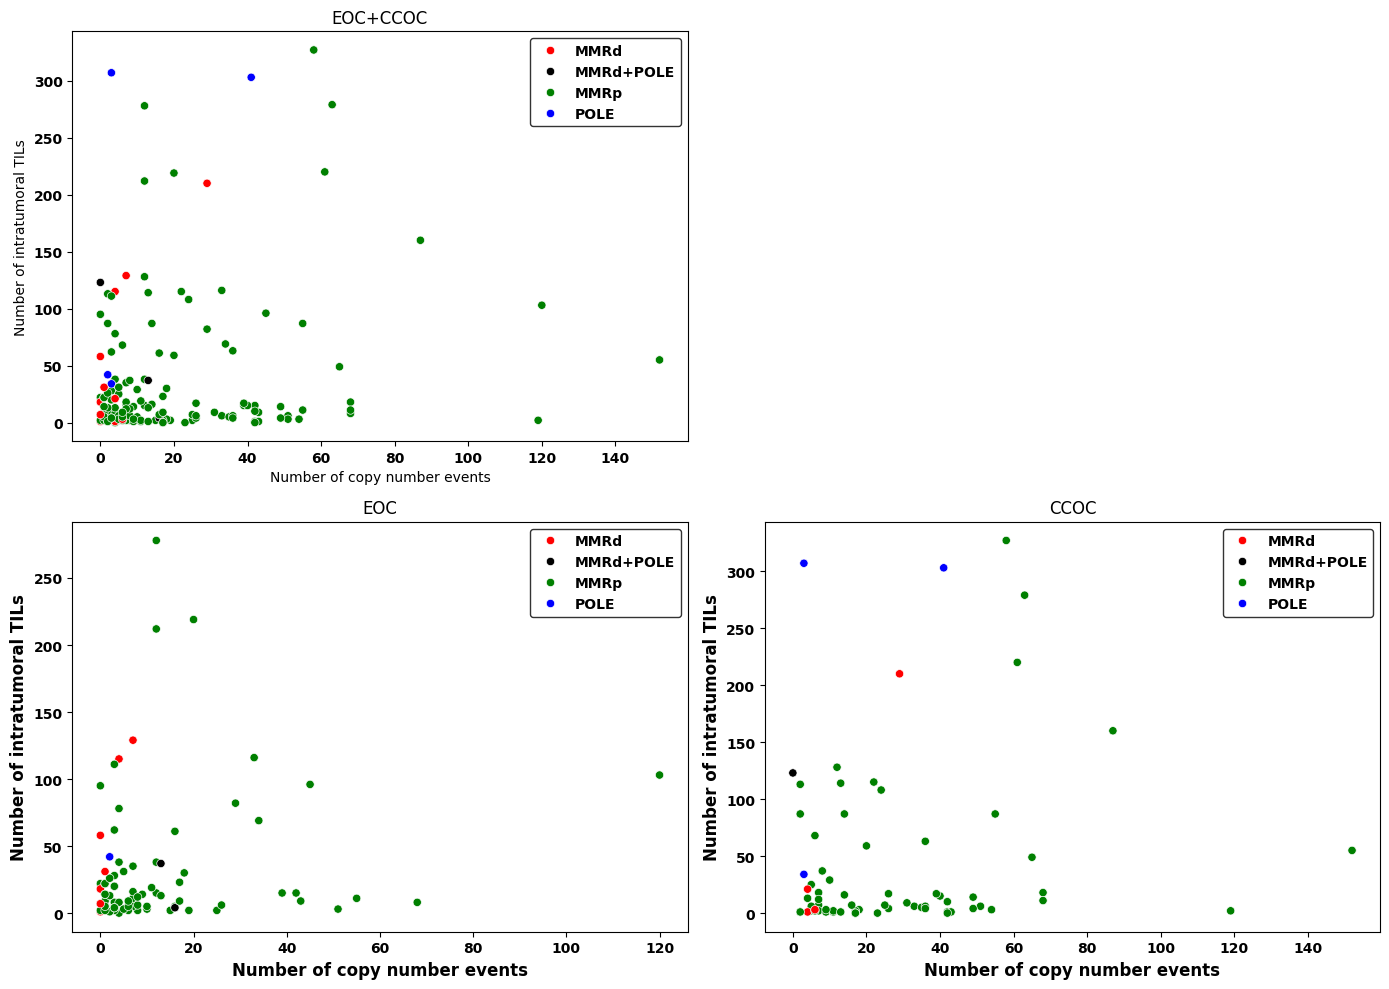

In [27]:
#########    Plots to analyse the relation between copy number aberrations (CNAs) and 'TILs_raw_tu' ########################

# Uncomment to import if not done previously
# import seaborn as sns

# Create a figure with 2 rows and 2 columns of subplots (last cell will remain empty)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # Set figure size for better visibility

# Function to assign colors and categories for legend
def assign_colors_and_labels(row):
    if row['Pol_mutation'] != 'NO' and row['MMR_final_status'] == 'MMRd':
        return 'black', 'MMRd+POLE'  # Black for MMRd + POLE
    elif row['Pol_mutation'] != 'NO':
        return 'blue', 'POLE'  # Blue for POLE
    elif row['MMR_final_status'] == 'MMRd':
        return 'red', 'MMRd'  # Red for MMRd
    else:
        return 'green', 'MMRp'  # Green for MMRp

# Use assign to add 'color' and 'category' columns
df = df.assign(
    color=df.apply(lambda row: assign_colors_and_labels(row)[0], axis=1),
    category=df.apply(lambda row: assign_colors_and_labels(row)[1], axis=1)
)

df_eoc = df_eoc.assign(
    color=df_eoc.apply(lambda row: assign_colors_and_labels(row)[0], axis=1),
    category=df_eoc.apply(lambda row: assign_colors_and_labels(row)[1], axis=1)
)

df_cc = df_cc.assign(
    color=df_cc.apply(lambda row: assign_colors_and_labels(row)[0], axis=1),
    category=df_cc.apply(lambda row: assign_colors_and_labels(row)[1], axis=1)
)

# Convert 'category' column to a categorical type
df['category'] = df['category'].astype('category')
df_eoc['category'] = df_eoc['category'].astype('category')
df_cc['category'] = df_cc['category'].astype('category')

# Plot 1: CNV vs TILs_raw_tu for EOC+CC (top-left subplot)
sns.scatterplot(
    ax=axes[0, 0],
    data=df,
    x='CNV',
    y='TILs_raw_tu',
    hue='category',
    palette={'MMRd+POLE': 'black', 'POLE': 'blue', 'MMRd': 'red', 'MMRp': 'green'},
    legend='full'
)
axes[0, 0].set_title('EOC+CCOC')  # Add title
axes[0, 0].set_xlabel('Number of copy number events')  # Label for the x-axis
axes[0, 0].set_ylabel('Number of intratumoral TILs')  # Label for the y-axis

# Remove the empty subplot (top-right subplot)
fig.delaxes(axes[0, 1])  # Deletes the unused subplot in the top-right corner

# Plot 2: CNV vs TILs_raw_tu for EOC (bottom-left subplot)
sns.scatterplot(
    ax=axes[1, 0],
    data=df_eoc,
    x='CNV',
    y='TILs_raw_tu',
    hue='category',
    palette={'MMRd+POLE': 'black', 'POLE': 'blue', 'MMRd': 'red', 'MMRp': 'green'},
    legend='full'
)
axes[1, 0].set_title('EOC')  # Add title
axes[1, 0].set_xlabel('Number of copy number events', fontsize=12, fontweight='bold')  # Label for the x-axis
axes[1, 0].set_ylabel('Number of intratumoral TILs', fontsize=12, fontweight='bold')  # Label for the y-axis

# Plot 3: CNV vs TILs_raw_ep for CC (bottom-right subplot)
sns.scatterplot(
    ax=axes[1, 1],
    data=df_cc,
    x='CNV',
    y='TILs_raw_tu',
    hue='category',
    palette={'MMRd+POLE': 'black', 'POLE': 'blue', 'MMRd': 'red', 'MMRp': 'green'},
    legend='full'
)
axes[1, 1].set_title('CCOC')  # Add title
axes[1, 1].set_xlabel('Number of copy number events', fontsize=12, fontweight='bold')  # Label for the x-axis
axes[1, 1].set_ylabel('Number of intratumoral TILs', fontsize=12, fontweight='bold')  # Label for the y-axis
# Adjust tick labels for all subplots
for ax in axes.flat:
    if ax is not None:  # Check if the subplot exists
        # Set properties for tick labels on both axes
        for label in ax.get_xticklabels() + ax.get_yticklabels():
            label.set_fontsize(10)
            label.set_fontweight('bold')

        # Adjust legend: remove 'category' and set fontweight to bold
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, 
                  loc='upper right', 
                  fontsize=10, 
                  title_fontsize=12, 
                  frameon=True,  # Add a frame around the legend
                  facecolor='white',  # Background color inside the legend box
                  edgecolor='black', # Border color around the legend box
                  prop={'weight': 'bold'})  # Make legend text bold
# Adjust layout to prevent overlap between subplots
plt.tight_layout()

# Save the entire figure as a PNG file
plt.savefig("/home/vant/TFM/Plots_TFM_final/CNAs_vs_TILS_tu.png", format='png',dpi=300)

# Display the figure
plt.show()

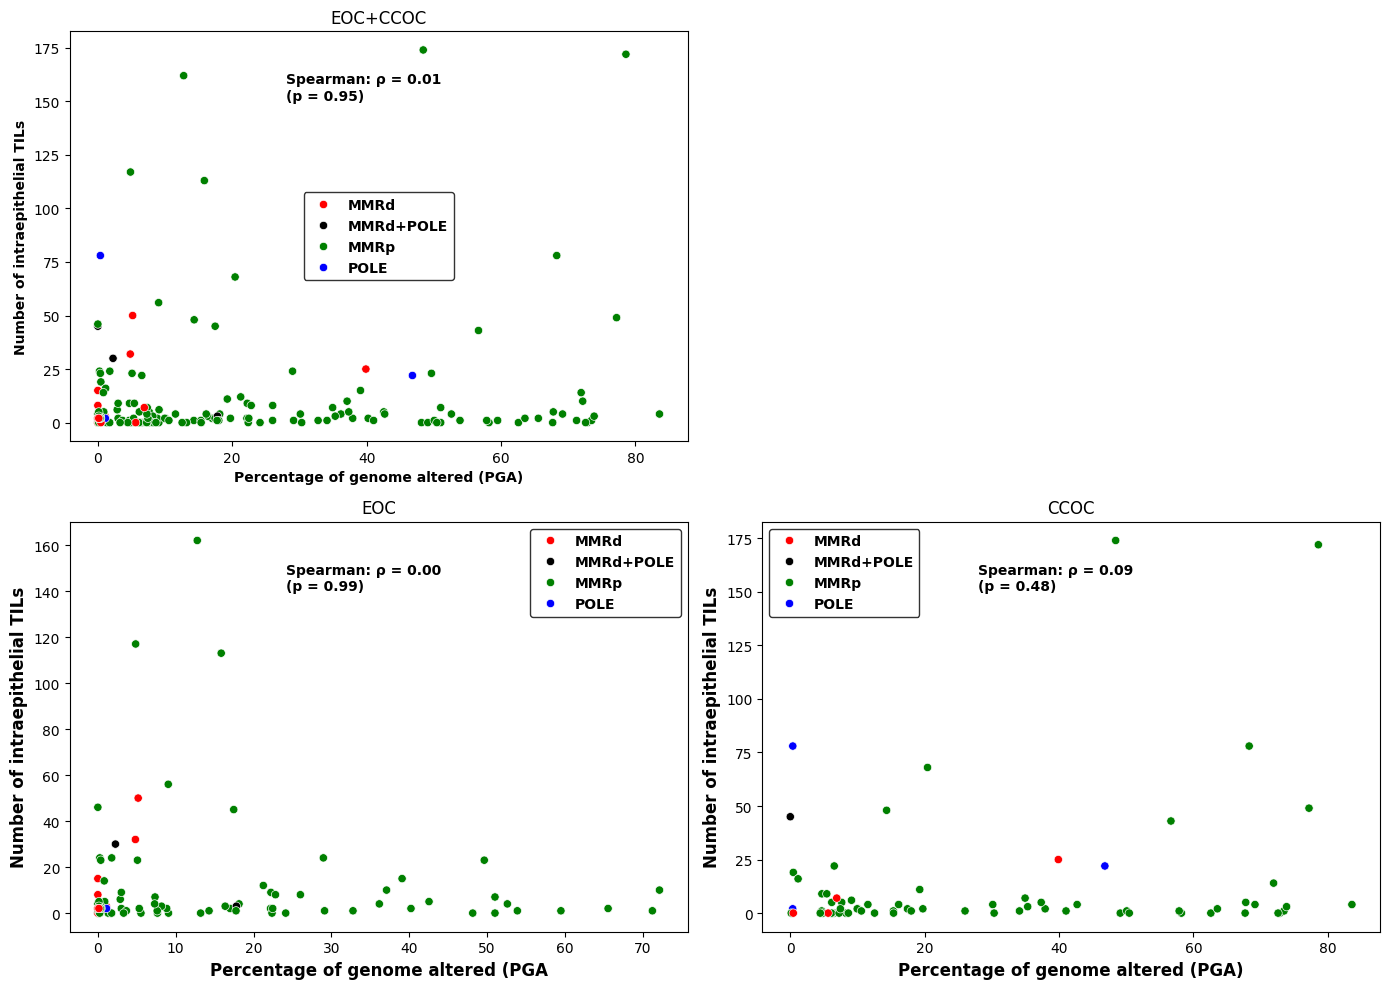

In [33]:
#########    Plots to analyse the relation between PGA and 'TILs_raw_ep' ########################

# Uncomment to import if not done previously
# import seaborn as sns

import seaborn as sns
from scipy.stats import spearmanr, pearsonr, shapiro
import matplotlib.pyplot as plt

# Function to calculate correlation and add annotation to the plot
def add_correlation_annotation(ax, x, y, data):
    """
    Checks for normality and adds the appropriate correlation annotation to the plot.

    Parameters:
    - ax: The axis of the plot to annotate.
    - x: Column name for the x-axis variable.
    - y: Column name for the y-axis variable.
    - data: DataFrame containing the data.
    """
    # Drop NaN values for the x and y columns
    data_clean = data[[x, y]].dropna()
    
    # Perform Shapiro-Wilk test for normality
    stat_x, p_x = shapiro(data_clean[x])
    stat_y, p_y = shapiro(data_clean[y])
    
    # Check if both variables are normally distributed
    if p_x > 0.05 and p_y > 0.05:
        # Use Pearson correlation if normality is confirmed
        coef, p_value = pearsonr(data_clean[x], data_clean[y])
        method = "Pearson"
    else:
        # Use Spearman correlation if normality is not confirmed
        coef, p_value = spearmanr(data_clean[x], data_clean[y])
        method = "Spearman"
    
    # Format the annotation text
    correlation_text = f"{method}: ρ = {coef:.2f}\n(p = {p_value:.2g})"
    # Add the annotation to the top-left corner of the plot
    ax.text(0.35, 0.9, correlation_text, fontsize=10, fontweight='bold',
            transform=ax.transAxes, verticalalignment='top', color='black')

# Create a figure with 2 rows and 2 columns of subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: %genome_altered vs TILs_raw_ep for EOC+CC (top-left subplot)
sns.scatterplot(
    ax=axes[0, 0],
    data=df,
    x='%genome_altered',
    y='TILs_raw_ep',
    hue='category',
    palette={'MMRd+POLE': 'black', 'POLE': 'blue', 'MMRd': 'red', 'MMRp': 'green'},
    legend='full'
)
axes[0, 0].set_title('EOC+CCOC')
axes[0, 0].set_xlabel('Percentage of genome altered (PGA)', fontweight='bold')
axes[0, 0].set_ylabel('Number of intraepithelial TILs', fontweight='bold')
# Add correlation annotation for EOC+CC
add_correlation_annotation(axes[0, 0], '%genome_altered', 'TILs_raw_ep', df)

# Remove the unused subplot (top-right subplot)
fig.delaxes(axes[0, 1])

# Plot 2: %genome_altered vs TILs_raw_ep for EOC (bottom-left subplot)
sns.scatterplot(
    ax=axes[1, 0],
    data=df_eoc,
    x='%genome_altered',
    y='TILs_raw_ep',
    hue='category',
    palette={'MMRd+POLE': 'black', 'POLE': 'blue', 'MMRd': 'red', 'MMRp': 'green'},
    legend='full'
)
axes[1, 0].set_title('EOC')
axes[1, 0].set_xlabel('Percentage of genome altered (PGA', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Number of intraepithelial TILs', fontsize=12, fontweight='bold')
# Add correlation annotation for EOC
add_correlation_annotation(axes[1, 0], '%genome_altered', 'TILs_raw_ep', df_eoc)

# Plot 3: %genome_altered vs TILs_raw_ep for CC (bottom-right subplot)
sns.scatterplot(
    ax=axes[1, 1],
    data=df_cc,
    x='%genome_altered',
    y='TILs_raw_ep',
    hue='category',
    palette={'MMRd+POLE': 'black', 'POLE': 'blue', 'MMRd': 'red', 'MMRp': 'green'},
    legend='full'
)
axes[1, 1].set_title('CCOC')
axes[1, 1].set_xlabel('Percentage of genome altered (PGA)', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Number of intraepithelial TILs', fontsize=12, fontweight='bold')
# Add correlation annotation for CC
add_correlation_annotation(axes[1, 1], '%genome_altered', 'TILs_raw_ep', df_cc)

# Adjust legends: bold text and remove 'category' from labels
for ax in [axes[0, 0], axes[1, 0], axes[1, 1]]:
    handles, labels = ax.get_legend_handles_labels()
    new_labels = [label.split('category: ')[-1] for label in labels]  # Remove "category: "
    ax.legend(
        handles, new_labels,
        loc='best',
        fontsize=10,
        title_fontsize=12,
        frameon=True,
        facecolor='white',
        edgecolor='black',
        prop={'weight': 'bold'}  # Bold legend text
    )

# Adjust layout to avoid overlap between subplots
plt.tight_layout()

# Save the plot as a PNG file
plt.savefig("/home/vant/TFM/Plots_TFM_final/percent_genome_altered_vs_TILS_ep.png", format='png', dpi=300)

# Display the plot
plt.show()

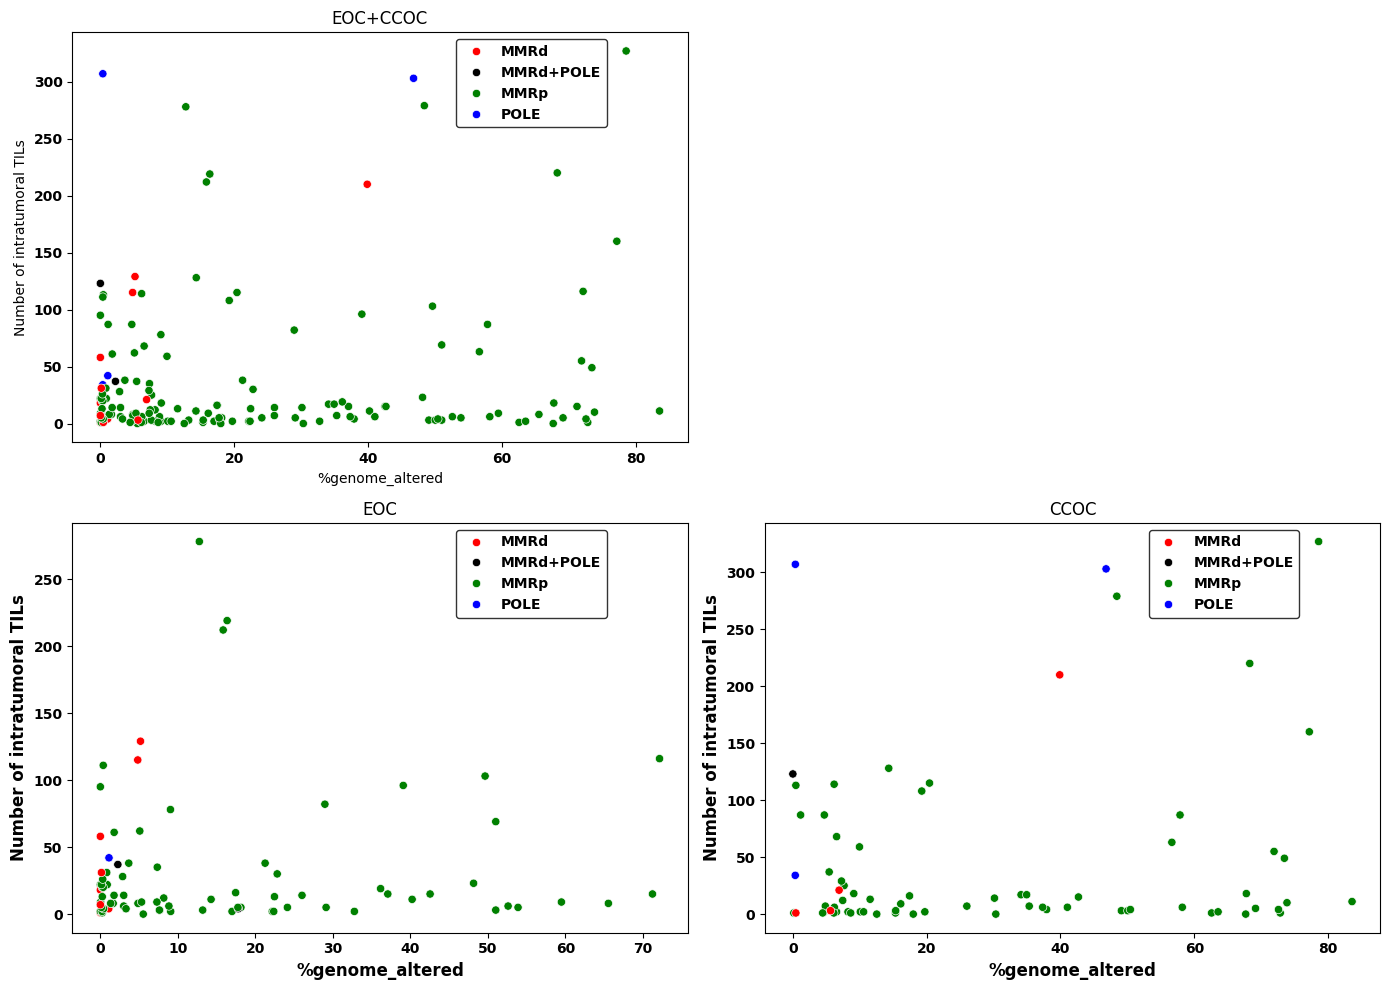

In [29]:
#########    Plots to analyse the relation between PGA and 'TILs_raw_tu' ########################

# Uncomment to import if not done previously
# import seaborn as sns

# Create a figure with 2 rows and 2 columns of subplots (last cell will remain empty)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # Set figure size for better visibility

# Function to assign colors and categories for legend
def assign_colors_and_labels(row):
    if row['Pol_mutation'] != 'NO' and row['MMR_final_status'] == 'MMRd':
        return 'black', 'MMRd+POLE'  # Black for MMRd + POLE
    elif row['Pol_mutation'] != 'NO':
        return 'blue', 'POLE'  # Blue for POLE
    elif row['MMR_final_status'] == 'MMRd':
        return 'red', 'MMRd'  # Red for MMRd
    else:
        return 'green', 'MMRp'  # Green for MMRp

# Use assign to add 'color' and 'category' columns
df = df.assign(
    color=df.apply(lambda row: assign_colors_and_labels(row)[0], axis=1),
    category=df.apply(lambda row: assign_colors_and_labels(row)[1], axis=1)
)

df_eoc = df_eoc.assign(
    color=df_eoc.apply(lambda row: assign_colors_and_labels(row)[0], axis=1),
    category=df_eoc.apply(lambda row: assign_colors_and_labels(row)[1], axis=1)
)

df_cc = df_cc.assign(
    color=df_cc.apply(lambda row: assign_colors_and_labels(row)[0], axis=1),
    category=df_cc.apply(lambda row: assign_colors_and_labels(row)[1], axis=1)
)

# Convert 'category' column to a categorical type
df['category'] = df['category'].astype('category')
df_eoc['category'] = df_eoc['category'].astype('category')
df_cc['category'] = df_cc['category'].astype('category')

# Plot 1: %genome_altered vs TILs_raw_tu for EOC+CC (top-left subplot)
sns.scatterplot(
    ax=axes[0, 0],
    data=df,
    x='%genome_altered',
    y='TILs_raw_tu',
    hue='category',
    palette={'MMRd+POLE': 'black', 'POLE': 'blue', 'MMRd': 'red', 'MMRp': 'green'},
    legend='full'
)
axes[0, 0].set_title('EOC+CCOC')  # Add title
axes[0, 0].set_xlabel('%genome_altered')  # Label for the x-axis
axes[0, 0].set_ylabel('Number of intratumoral TILs')  # Label for the y-axis

# Remove the empty subplot (top-right subplot)
fig.delaxes(axes[0, 1])  # Deletes the unused subplot in the top-right corner

# Plot 2: %genome_altered vs TILs_raw_tu for EOC (bottom-left subplot)
sns.scatterplot(
    ax=axes[1, 0],
    data=df_eoc,
    x='%genome_altered',
    y='TILs_raw_tu',
    hue='category',
    palette={'MMRd+POLE': 'black', 'POLE': 'blue', 'MMRd': 'red', 'MMRp': 'green'},
    legend='full'
)
axes[1, 0].set_title('EOC')  # Add title
axes[1, 0].set_xlabel('%genome_altered', fontsize=12, fontweight='bold')  # Label for the x-axis
axes[1, 0].set_ylabel('Number of intratumoral TILs', fontsize=12, fontweight='bold')  # Label for the y-axis

# Plot 3: %genome_altered vs TILs_raw_tu for CC (bottom-right subplot)
sns.scatterplot(
    ax=axes[1, 1],
    data=df_cc,
    x='%genome_altered',
    y='TILs_raw_tu',
    hue='category',
    palette={'MMRd+POLE': 'black', 'POLE': 'blue', 'MMRd': 'red', 'MMRp': 'green'},
    legend='full'
)
axes[1, 1].set_title('CCOC')  # Add title
axes[1, 1].set_xlabel('%genome_altered', fontsize=12, fontweight='bold')  # Label for the x-axis
axes[1, 1].set_ylabel('Number of intratumoral TILs', fontsize=12, fontweight='bold')  # Label for the y-axis
# Adjust tick labels for all subplots
for ax in axes.flat:
    if ax is not None:  # Check if the subplot exists
        # Set properties for tick labels on both axes
        for label in ax.get_xticklabels() + ax.get_yticklabels():
            label.set_fontsize(10)
            label.set_fontweight('bold')

        # Adjust legend: remove 'category' and set fontweight to bold
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, 
                  loc='upper right',
                  bbox_to_anchor=(0.88, 1),
                  fontsize=10, 
                  title_fontsize=12, 
                  frameon=True,  # Add a frame around the legend
                  facecolor='white',  # Background color inside the legend box
                  edgecolor='black', # Border color around the legend box
                  prop={'weight': 'bold'})  # Make legend text bold
# Adjust layout to prevent overlap between subplots
plt.tight_layout()

# Save the entire figure as a PNG file
plt.savefig("/home/vant/TFM/Plots_TFM_final/PGA_vs_TILS_tu.png", format='png',dpi=300)

# Display the figure
plt.show()



In [14]:
########### ANALYSIS OF TILs VS GENOMIC VARIABLES IN THE MMRp GROUP #####################
#########################################################################################
print(f"Number of MMRp samples with TILs raw counts: {len(df_all_mmrp)}")

Number of MMRp samples with TILs raw counts: 141


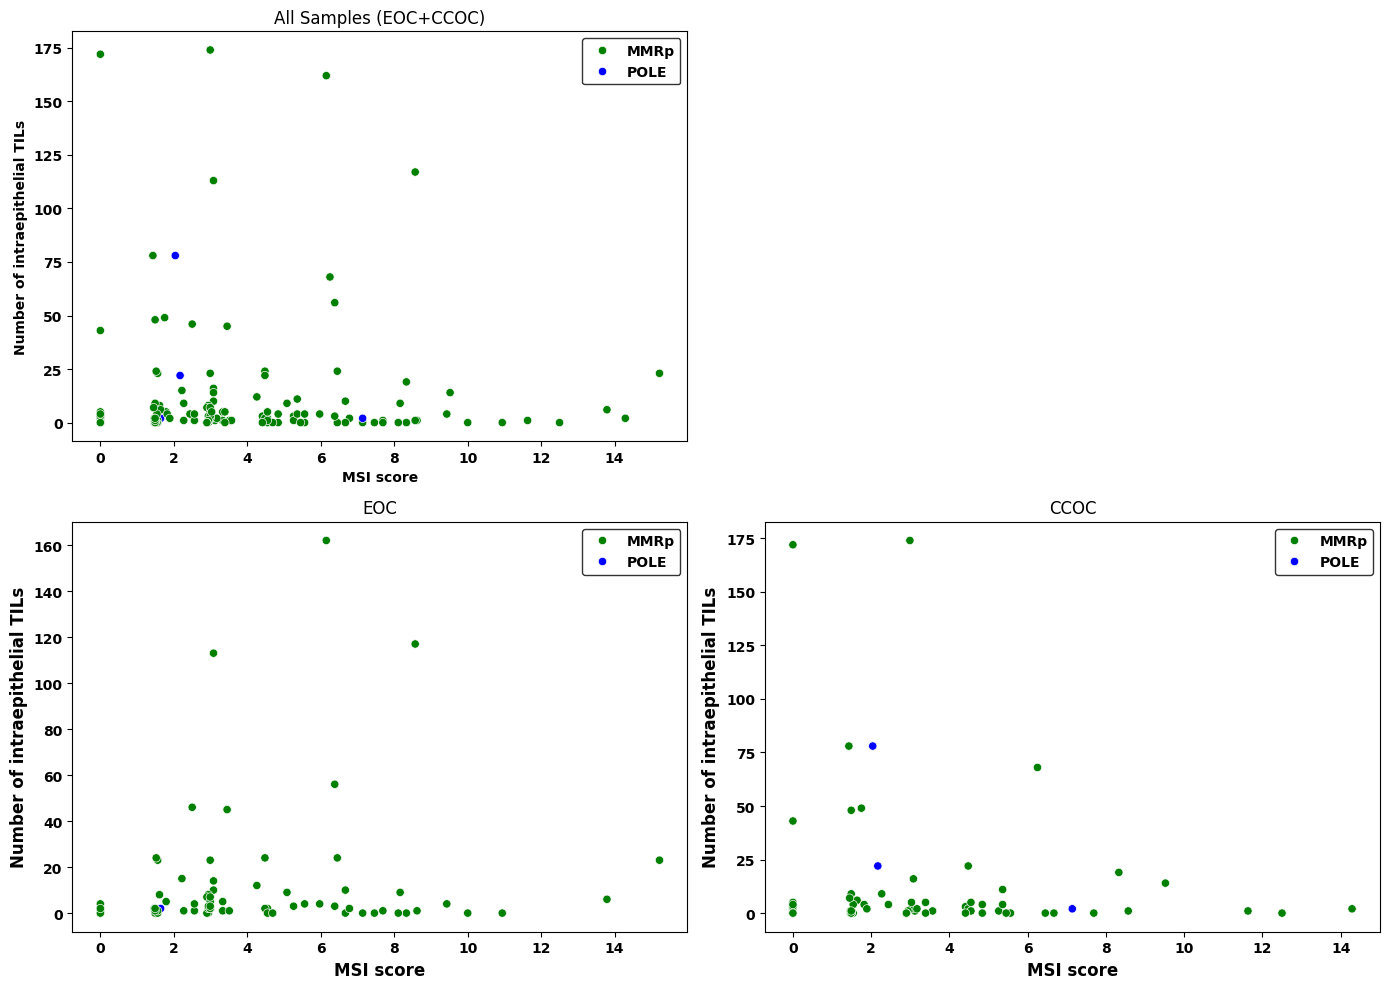

In [15]:
#############    Plots to analyse the relation between MSI score and 'TILs_raw_ep' in MMRp samples ########################

# Uncomment to import if not done previously
# import seaborn as sns

# Create a figure with 2 rows and 2 columns of subplots (last cell will remain empty)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # Set figure size for better visibility

# Function to assign colors and categories for legend
def assign_colors_and_labels(row):
    if row['Pol_mutation'] != 'NO' and row['MMR_final_status'] == 'MMRd':
        return 'black', 'MMRd+POLE'  # Black for MMRd + POLE
    elif row['Pol_mutation'] != 'NO':
        return 'blue', 'POLE'  # Blue for POLE
    elif row['MMR_final_status'] == 'MMRd':
        return 'red', 'MMRd'  # Red for MMRd
    else:
        return 'green', 'MMRp'  # Green for MMRp

# Ensure the DataFrames are independent copies
df_all_mmrp = df_all_mmrp.copy()
df_eoc_mmrp = df_eoc_mmrp.copy()
df_cc_mmrp = df_cc_mmrp.copy()

# Use assign to add 'color' and 'category' columns
df_all_mmrp = df_all_mmrp.assign(
    color=df_all_mmrp.apply(lambda row: assign_colors_and_labels(row)[0], axis=1),
    category=df_all_mmrp.apply(lambda row: assign_colors_and_labels(row)[1], axis=1)
)

df_eoc_mmrp = df_eoc_mmrp.assign(
    color=df_eoc_mmrp.apply(lambda row: assign_colors_and_labels(row)[0], axis=1),
    category=df_eoc_mmrp.apply(lambda row: assign_colors_and_labels(row)[1], axis=1)
)

df_cc_mmrp = df_cc_mmrp.assign(
    color=df_cc_mmrp.apply(lambda row: assign_colors_and_labels(row)[0], axis=1),
    category=df_cc_mmrp.apply(lambda row: assign_colors_and_labels(row)[1], axis=1)
)

# Convert 'category' column to a categorical type
df_all_mmrp['category'] = df_all_mmrp['category'].astype('category')
df_eoc_mmrp['category'] = df_eoc_mmrp['category'].astype('category')
df_cc_mmrp['category'] = df_cc_mmrp['category'].astype('category')

# Plot 1: MSI score vs TILs_raw_ep for all samples (top-left subplot)
sns.scatterplot(
    ax=axes[0, 0],
    data=df_all_mmrp,
    x='MSI_sensor2',
    y='TILs_raw_ep',
    hue='category',
    palette={'MMRd+POLE': 'black', 'POLE': 'blue', 'MMRd': 'red', 'MMRp': 'green'},
    legend='full'
)
axes[0, 0].set_title('All Samples (EOC+CCOC)')  # Add title
axes[0, 0].set_xlabel('MSI score', fontweight='bold')  # Label for the x-axis
axes[0, 0].set_ylabel('Number of intraepithelial TILs', fontweight='bold')  # Label for the y-axis

# Remove the empty subplot (top-right subplot)
fig.delaxes(axes[0, 1])  # Deletes the unused subplot in the top-right corner

# Plot 2: MSI score vs TILs_raw_ep for EOC (bottom-left subplot)
sns.scatterplot(
    ax=axes[1, 0],
    data=df_eoc_mmrp,
    x='MSI_sensor2',
    y='TILs_raw_ep',
    hue='category',
    palette={'MMRd+POLE': 'black', 'POLE': 'blue', 'MMRd': 'red', 'MMRp': 'green'},
    legend='full'
)
axes[1, 0].set_title('EOC')  # Add title
axes[1, 0].set_xlabel('MSI score', fontsize=12, fontweight='bold')  # Label for the x-axis
axes[1, 0].set_ylabel('Number of intraepithelial TILs', fontsize=12, fontweight='bold')  # Label for the y-axis

# Plot 3: MSI score vs TILs_raw_ep for CC (bottom-right subplot)
sns.scatterplot(
    ax=axes[1, 1],
    data=df_cc_mmrp,
    x='MSI_sensor2',
    y='TILs_raw_ep',
    hue='category',
    palette={'MMRd+POLE': 'black', 'POLE': 'blue', 'MMRd': 'red', 'MMRp': 'green'},
    legend='full'
)
axes[1, 1].set_title('CCOC')  # Add title
axes[1, 1].set_xlabel('MSI score', fontsize=12, fontweight='bold')  # Label for the x-axis
axes[1, 1].set_ylabel('Number of intraepithelial TILs', fontsize=12, fontweight='bold')  # Label for the y-axis

# Adjust tick labels for all subplots
for ax in axes.flat:
    if ax is not None:  # Check if the subplot exists
        # Set properties for tick labels on both axes
        for label in ax.get_xticklabels() + ax.get_yticklabels():
            label.set_fontsize(10)
            label.set_fontweight('bold')

        # Adjust legend: remove 'category' and set fontweight to bold
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, 
                  loc='upper right', 
                  fontsize=10, 
                  title_fontsize=12, 
                  frameon=True,  # Add a frame around the legend
                  facecolor='white',  # Background color inside the legend box
                  edgecolor='black', # Border color around the legend box
                  prop={'weight': 'bold'})  # Make legend text bold

# Adjust layout to prevent overlap between subplots
plt.tight_layout()

# Save the entire figure as a PNG file
output_folder = "/home/vant/TFM/Plots_TFM_final"
output_file = "MSI_vs_TILS_ep_MMRp.png"
plt.savefig(f"{output_folder}/{output_file}", format='png', dpi=300)

# Display the figure
plt.show()


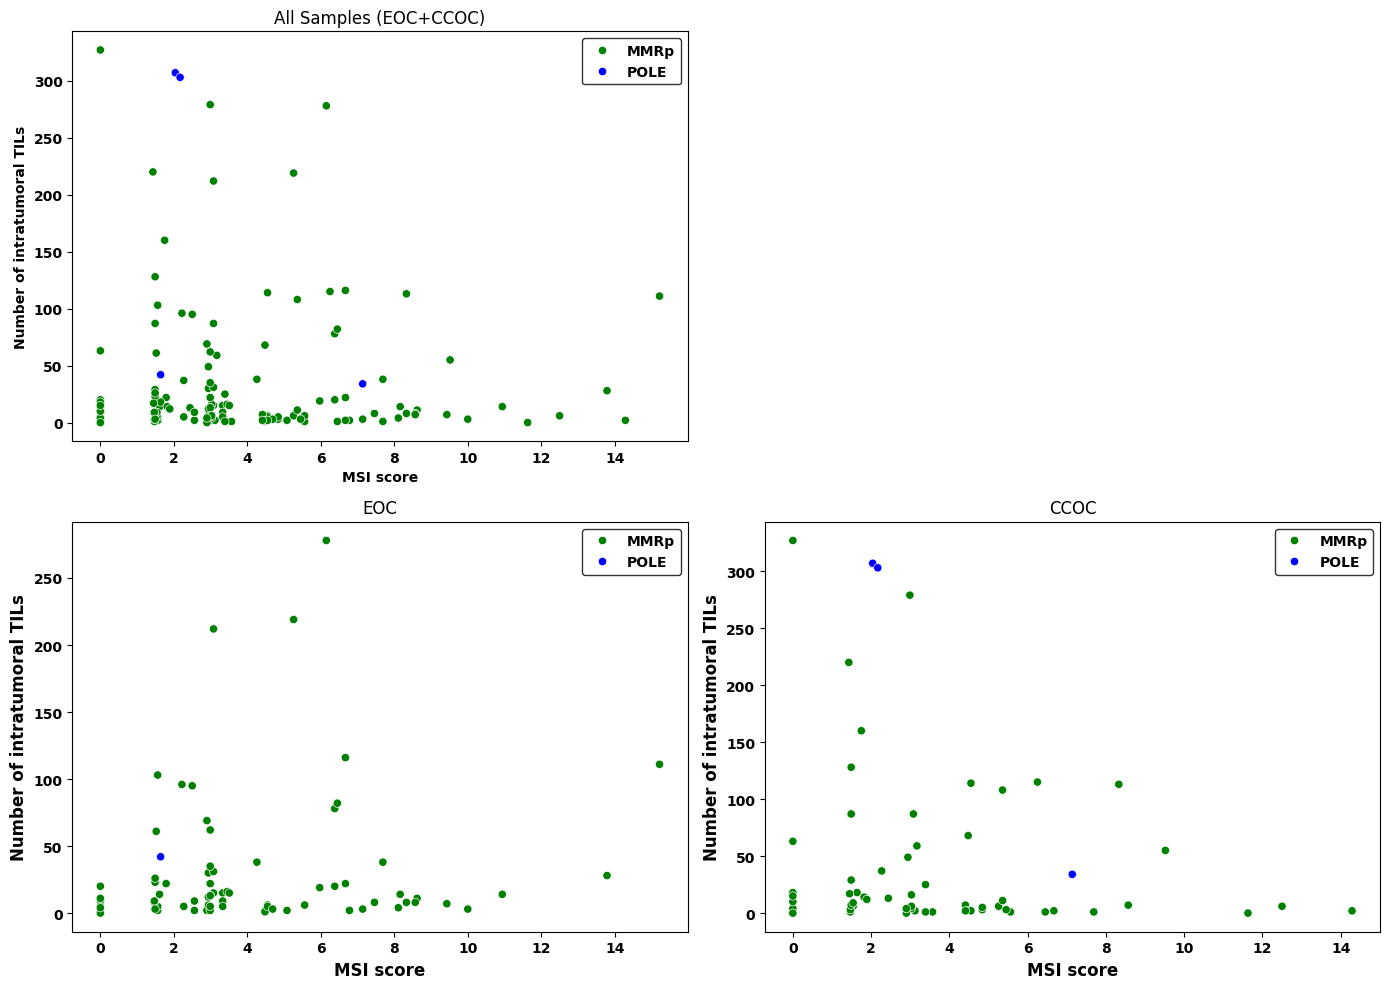

In [16]:
#############    Plots to analyse the relation between MSI score and 'TILs_raw_tu' in MMRp samples ########################

# Uncomment to import if not done previously
# import seaborn as sns

# Create a figure with 2 rows and 2 columns of subplots (last cell will remain empty)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # Set figure size for better visibility

# Function to assign colors and categories for legend
def assign_colors_and_labels(row):
    if row['Pol_mutation'] != 'NO' and row['MMR_final_status'] == 'MMRd':
        return 'black', 'MMRd+POLE'  # Black for MMRd + POLE
    elif row['Pol_mutation'] != 'NO':
        return 'blue', 'POLE'  # Blue for POLE
    elif row['MMR_final_status'] == 'MMRd':
        return 'red', 'MMRd'  # Red for MMRd
    else:
        return 'green', 'MMRp'  # Green for MMRp

# Ensure the DataFrames are independent copies
df_all_mmrp = df_all_mmrp.copy()
df_eoc_mmrp = df_eoc_mmrp.copy()
df_cc_mmrp = df_cc_mmrp.copy()

# Use assign to add 'color' and 'category' columns
df_all_mmrp = df_all_mmrp.assign(
    color=df_all_mmrp.apply(lambda row: assign_colors_and_labels(row)[0], axis=1),
    category=df_all_mmrp.apply(lambda row: assign_colors_and_labels(row)[1], axis=1)
)

df_eoc_mmrp = df_eoc_mmrp.assign(
    color=df_eoc_mmrp.apply(lambda row: assign_colors_and_labels(row)[0], axis=1),
    category=df_eoc_mmrp.apply(lambda row: assign_colors_and_labels(row)[1], axis=1)
)

df_cc_mmrp = df_cc_mmrp.assign(
    color=df_cc_mmrp.apply(lambda row: assign_colors_and_labels(row)[0], axis=1),
    category=df_cc_mmrp.apply(lambda row: assign_colors_and_labels(row)[1], axis=1)
)

# Convert 'category' column to a categorical type
df_all_mmrp['category'] = df_all_mmrp['category'].astype('category')
df_eoc_mmrp['category'] = df_eoc_mmrp['category'].astype('category')
df_cc_mmrp['category'] = df_cc_mmrp['category'].astype('category')

# Plot 1: MSI score vs TILs_raw_tu for all samples (top-left subplot)
sns.scatterplot(
    ax=axes[0, 0],
    data=df_all_mmrp,
    x='MSI_sensor2',
    y='TILs_raw_tu',
    hue='category',
    palette={'MMRd+POLE': 'black', 'POLE': 'blue', 'MMRd': 'red', 'MMRp': 'green'},
    legend='full'
)
axes[0, 0].set_title('All Samples (EOC+CCOC)')  # Add title
axes[0, 0].set_xlabel('MSI score', fontweight='bold')  # Label for the x-axis
axes[0, 0].set_ylabel('Number of intratumoral TILs', fontweight='bold')  # Label for the y-axis

# Remove the empty subplot (top-right subplot)
fig.delaxes(axes[0, 1])  # Deletes the unused subplot in the top-right corner

# Plot 2: MSI score vs TILs_raw_tu for EOC (bottom-left subplot)
sns.scatterplot(
    ax=axes[1, 0],
    data=df_eoc_mmrp,
    x='MSI_sensor2',
    y='TILs_raw_tu',
    hue='category',
    palette={'MMRd+POLE': 'black', 'POLE': 'blue', 'MMRd': 'red', 'MMRp': 'green'},
    legend='full'
)
axes[1, 0].set_title('EOC')  # Add title
axes[1, 0].set_xlabel('MSI score', fontsize=12, fontweight='bold')  # Label for the x-axis
axes[1, 0].set_ylabel('Number of intratumoral TILs', fontsize=12, fontweight='bold')  # Label for the y-axis

# Plot 3: MSI score vs TILs_raw_tu for CC (bottom-right subplot)
sns.scatterplot(
    ax=axes[1, 1],
    data=df_cc_mmrp,
    x='MSI_sensor2',
    y='TILs_raw_tu',
    hue='category',
    palette={'MMRd+POLE': 'black', 'POLE': 'blue', 'MMRd': 'red', 'MMRp': 'green'},
    legend='full'
)
axes[1, 1].set_title('CCOC')  # Add title
axes[1, 1].set_xlabel('MSI score', fontsize=12, fontweight='bold')  # Label for the x-axis
axes[1, 1].set_ylabel('Number of intratumoral TILs', fontsize=12, fontweight='bold')  # Label for the y-axis

# Adjust tick labels for all subplots
for ax in axes.flat:
    if ax is not None:  # Check if the subplot exists
        # Set properties for tick labels on both axes
        for label in ax.get_xticklabels() + ax.get_yticklabels():
            label.set_fontsize(10)
            label.set_fontweight('bold')

        # Adjust legend: remove 'category' and set fontweight to bold
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, 
                  loc='upper right', 
                  fontsize=10, 
                  title_fontsize=12, 
                  frameon=True,  # Add a frame around the legend
                  facecolor='white',  # Background color inside the legend box
                  edgecolor='black', # Border color around the legend box
                  prop={'weight': 'bold'})  # Make legend text bold

# Adjust layout to prevent overlap between subplots
plt.tight_layout()

# Save the entire figure as a PNG file
output_folder = "/home/vant/TFM/Plots_TFM_final"
output_file = "MSI_vs_TILS_tu_MMRp.png"
plt.savefig(f"{output_folder}/{output_file}", format='png', dpi=300)

# Display the figure
plt.show()


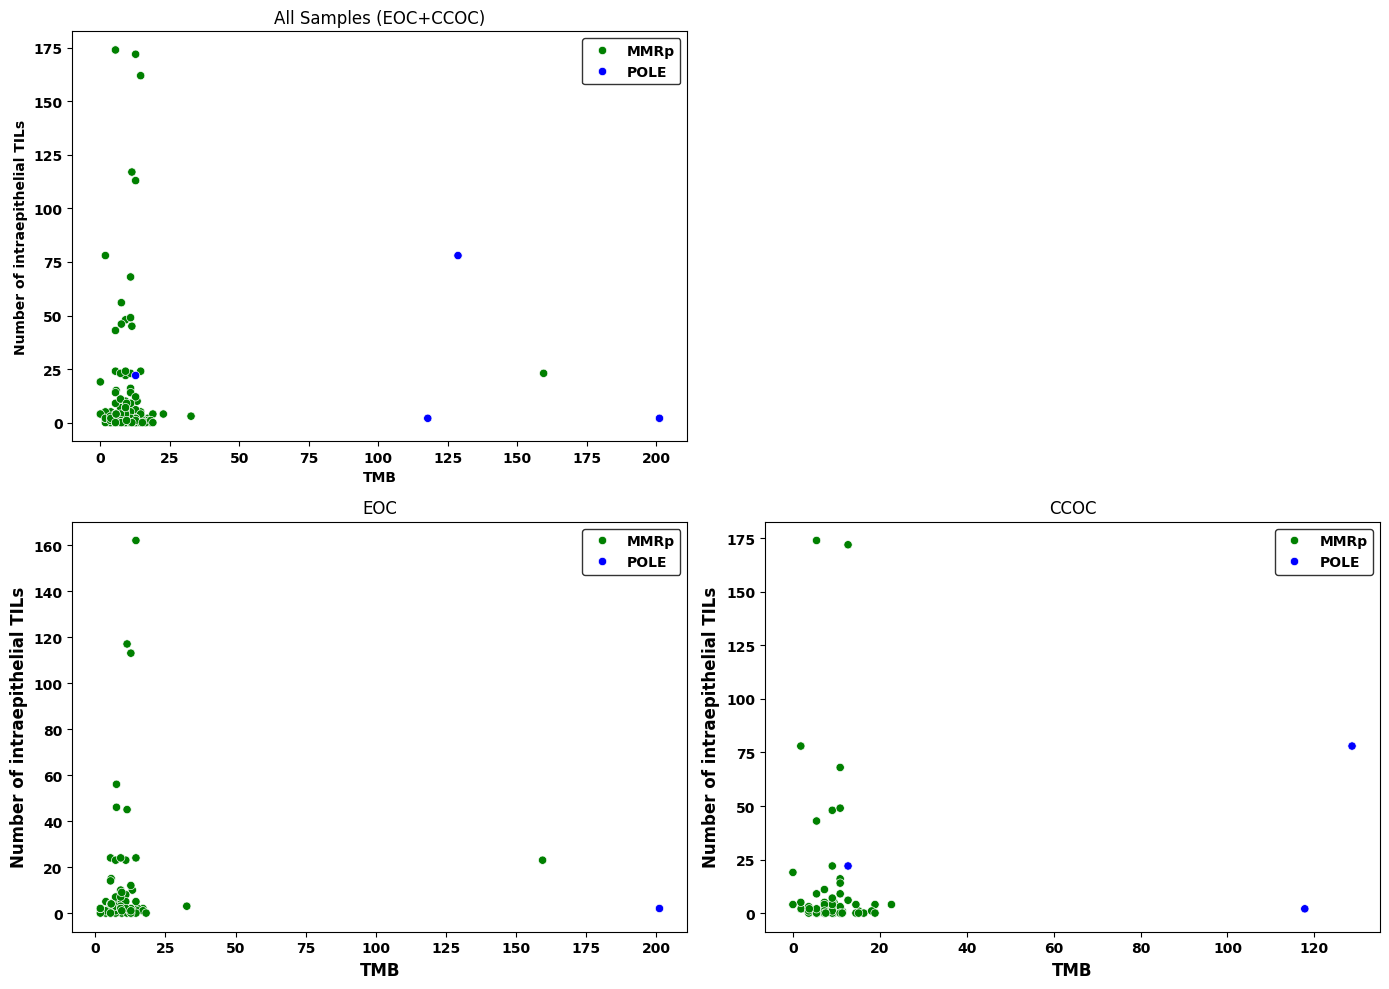

In [17]:
#############    Plots to analyse the relation between TMB scores and 'TILs_raw_ep' in MMRp samples ######################

# Uncomment to import if not done previously
# import seaborn as sns

# Create a figure with 2 rows and 2 columns of subplots (last cell will remain empty)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # Set figure size for better visibility

# Function to assign colors and categories for legend
def assign_colors_and_labels(row):
    if row['Pol_mutation'] != 'NO' and row['MMR_final_status'] == 'MMRd':
        return 'black', 'MMRd+POLE'  # Black for MMRd + POLE
    elif row['Pol_mutation'] != 'NO':
        return 'blue', 'POLE'  # Blue for POLE
    elif row['MMR_final_status'] == 'MMRd':
        return 'red', 'MMRd'  # Red for MMRd
    else:
        return 'green', 'MMRp'  # Green for MMRp

# Ensure the DataFrames are independent copies
df_all_mmrp = df_all_mmrp.copy()
df_eoc_mmrp = df_eoc_mmrp.copy()
df_cc_mmrp = df_cc_mmrp.copy()

# Use assign to add 'color' and 'category' columns
df_all_mmrp = df_all_mmrp.assign(
    color=df_all_mmrp.apply(lambda row: assign_colors_and_labels(row)[0], axis=1),
    category=df_all_mmrp.apply(lambda row: assign_colors_and_labels(row)[1], axis=1)
)

df_eoc_mmrp = df_eoc_mmrp.assign(
    color=df_eoc_mmrp.apply(lambda row: assign_colors_and_labels(row)[0], axis=1),
    category=df_eoc_mmrp.apply(lambda row: assign_colors_and_labels(row)[1], axis=1)
)

df_cc_mmrp = df_cc_mmrp.assign(
    color=df_cc_mmrp.apply(lambda row: assign_colors_and_labels(row)[0], axis=1),
    category=df_cc_mmrp.apply(lambda row: assign_colors_and_labels(row)[1], axis=1)
)

# Convert 'category' column to a categorical type
df_all_mmrp['category'] = df_all_mmrp['category'].astype('category')
df_eoc_mmrp['category'] = df_eoc_mmrp['category'].astype('category')
df_cc_mmrp['category'] = df_cc_mmrp['category'].astype('category')

# Plot 1: TMB vs TILs_raw_ep for all samples (top-left subplot)
sns.scatterplot(
    ax=axes[0, 0],
    data=df_all_mmrp,
    x='TMB',
    y='TILs_raw_ep',
    hue='category',
    palette={'MMRd+POLE': 'black', 'POLE': 'blue', 'MMRd': 'red', 'MMRp': 'green'},
    legend='full'
)
axes[0, 0].set_title('All Samples (EOC+CCOC)')  # Add title
axes[0, 0].set_xlabel('TMB', fontweight='bold')  # Label for the x-axis
axes[0, 0].set_ylabel('Number of intraepithelial TILs', fontweight='bold')  # Label for the y-axis

# Remove the empty subplot (top-right subplot)
fig.delaxes(axes[0, 1])  # Deletes the unused subplot in the top-right corner

# Plot 2: TMB vs TILs_raw_ep for EOC (bottom-left subplot)
sns.scatterplot(
    ax=axes[1, 0],
    data=df_eoc_mmrp,
    x='TMB',
    y='TILs_raw_ep',
    hue='category',
    palette={'MMRd+POLE': 'black', 'POLE': 'blue', 'MMRd': 'red', 'MMRp': 'green'},
    legend='full'
)
axes[1, 0].set_title('EOC')  # Add title
axes[1, 0].set_xlabel('TMB', fontsize=12, fontweight='bold')  # Label for the x-axis
axes[1, 0].set_ylabel('Number of intraepithelial TILs', fontsize=12, fontweight='bold')  # Label for the y-axis

# Plot 3: TMB vs TILs_raw_ep for CC (bottom-right subplot)
sns.scatterplot(
    ax=axes[1, 1],
    data=df_cc_mmrp,
    x='TMB',
    y='TILs_raw_ep',
    hue='category',
    palette={'MMRd+POLE': 'black', 'POLE': 'blue', 'MMRd': 'red', 'MMRp': 'green'},
    legend='full'
)
axes[1, 1].set_title('CCOC')  # Add title
axes[1, 1].set_xlabel('TMB', fontsize=12, fontweight='bold')  # Label for the x-axis
axes[1, 1].set_ylabel('Number of intraepithelial TILs', fontsize=12, fontweight='bold')  # Label for the y-axis

# Adjust tick labels for all subplots
for ax in axes.flat:
    if ax is not None:  # Check if the subplot exists
        # Set properties for tick labels on both axes
        for label in ax.get_xticklabels() + ax.get_yticklabels():
            label.set_fontsize(10)
            label.set_fontweight('bold')

        # Adjust legend: remove 'category' and set fontweight to bold
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, 
                  loc='upper right', 
                  fontsize=10, 
                  title_fontsize=12, 
                  frameon=True,  # Add a frame around the legend
                  facecolor='white',  # Background color inside the legend box
                  edgecolor='black', # Border color around the legend box
                  prop={'weight': 'bold'})  # Make legend text bold

# Adjust layout to prevent overlap between subplots
plt.tight_layout()

# Save the entire figure as a PNG file
output_folder = "/home/vant/TFM/Plots_TFM_final"
output_file = "TMB_vs_TILS_ep_MMRp.png"
plt.savefig(f"{output_folder}/{output_file}", format='png', dpi=300)

# Display the figure
plt.show()

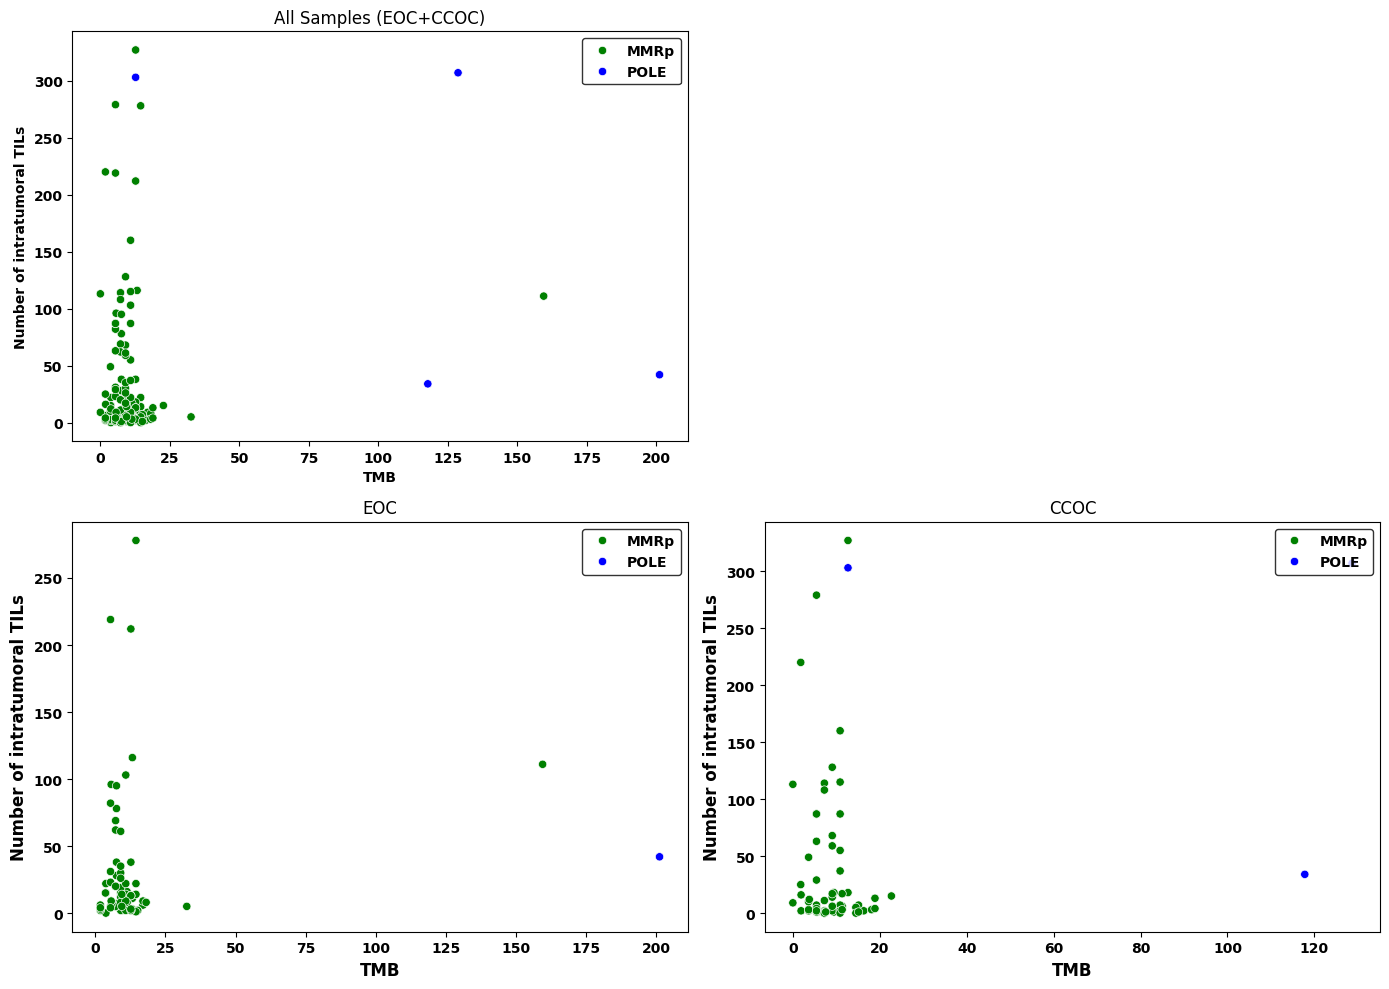

In [18]:
#############    Plots to analyse the relation between TMB score and 'TILs_raw_tu' in MMRp samples ########################

# Uncomment to import if not done previously
# import seaborn as sns

# Create a figure with 2 rows and 2 columns of subplots (last cell will remain empty)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # Set figure size for better visibility

# Function to assign colors and categories for legend
def assign_colors_and_labels(row):
    if row['Pol_mutation'] != 'NO' and row['MMR_final_status'] == 'MMRd':
        return 'black', 'MMRd+POLE'  # Black for MMRd + POLE
    elif row['Pol_mutation'] != 'NO':
        return 'blue', 'POLE'  # Blue for POLE
    elif row['MMR_final_status'] == 'MMRd':
        return 'red', 'MMRd'  # Red for MMRd
    else:
        return 'green', 'MMRp'  # Green for MMRp

# Ensure the DataFrames are independent copies
df_all_mmrp = df_all_mmrp.copy()
df_eoc_mmrp = df_eoc_mmrp.copy()
df_cc_mmrp = df_cc_mmrp.copy()

# Use assign to add 'color' and 'category' columns
df_all_mmrp = df_all_mmrp.assign(
    color=df_all_mmrp.apply(lambda row: assign_colors_and_labels(row)[0], axis=1),
    category=df_all_mmrp.apply(lambda row: assign_colors_and_labels(row)[1], axis=1)
)

df_eoc_mmrp = df_eoc_mmrp.assign(
    color=df_eoc_mmrp.apply(lambda row: assign_colors_and_labels(row)[0], axis=1),
    category=df_eoc_mmrp.apply(lambda row: assign_colors_and_labels(row)[1], axis=1)
)

df_cc_mmrp = df_cc_mmrp.assign(
    color=df_cc_mmrp.apply(lambda row: assign_colors_and_labels(row)[0], axis=1),
    category=df_cc_mmrp.apply(lambda row: assign_colors_and_labels(row)[1], axis=1)
)

# Convert 'category' column to a categorical type
df_all_mmrp['category'] = df_all_mmrp['category'].astype('category')
df_eoc_mmrp['category'] = df_eoc_mmrp['category'].astype('category')
df_cc_mmrp['category'] = df_cc_mmrp['category'].astype('category')

# Plot 1: TMB vs TILs_raw_tu for all samples (top-left subplot)
sns.scatterplot(
    ax=axes[0, 0],
    data=df_all_mmrp,
    x='TMB',
    y='TILs_raw_tu',
    hue='category',
    palette={'MMRd+POLE': 'black', 'POLE': 'blue', 'MMRd': 'red', 'MMRp': 'green'},
    legend='full'
)
axes[0, 0].set_title('All Samples (EOC+CCOC)')  # Add title
axes[0, 0].set_xlabel('TMB', fontweight='bold')  # Label for the x-axis
axes[0, 0].set_ylabel('Number of intratumoral TILs', fontweight='bold')  # Label for the y-axis

# Remove the empty subplot (top-right subplot)
fig.delaxes(axes[0, 1])  # Deletes the unused subplot in the top-right corner

# Plot 2: TMB vs TILs_raw_tu for EOC (bottom-left subplot)
sns.scatterplot(
    ax=axes[1, 0],
    data=df_eoc_mmrp,
    x='TMB',
    y='TILs_raw_tu',
    hue='category',
    palette={'MMRd+POLE': 'black', 'POLE': 'blue', 'MMRd': 'red', 'MMRp': 'green'},
    legend='full'
)
axes[1, 0].set_title('EOC')  # Add title
axes[1, 0].set_xlabel('TMB', fontsize=12, fontweight='bold')  # Label for the x-axis
axes[1, 0].set_ylabel('Number of intratumoral TILs', fontsize=12, fontweight='bold')  # Label for the y-axis

# Plot 3: TMB vs TILs_raw_tu for CC (bottom-right subplot)
sns.scatterplot(
    ax=axes[1, 1],
    data=df_cc_mmrp,
    x='TMB',
    y='TILs_raw_tu',
    hue='category',
    palette={'MMRd+POLE': 'black', 'POLE': 'blue', 'MMRd': 'red', 'MMRp': 'green'},
    legend='full'
)
axes[1, 1].set_title('CCOC')  # Add title
axes[1, 1].set_xlabel('TMB', fontsize=12, fontweight='bold')  # Label for the x-axis
axes[1, 1].set_ylabel('Number of intratumoral TILs', fontsize=12, fontweight='bold')  # Label for the y-axis

# Adjust tick labels for all subplots
for ax in axes.flat:
    if ax is not None:  # Check if the subplot exists
        # Set properties for tick labels on both axes
        for label in ax.get_xticklabels() + ax.get_yticklabels():
            label.set_fontsize(10)
            label.set_fontweight('bold')

        # Adjust legend: remove 'category' and set fontweight to bold
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, 
                  loc='upper right', 
                  fontsize=10, 
                  title_fontsize=12, 
                  frameon=True,  # Add a frame around the legend
                  facecolor='white',  # Background color inside the legend box
                  edgecolor='black', # Border color around the legend box
                  prop={'weight': 'bold'})  # Make legend text bold

# Adjust layout to prevent overlap between subplots
plt.tight_layout()

# Save the entire figure as a PNG file
output_folder = "/home/vant/TFM/Plots_TFM_final"
output_file = "TMB_vs_TILS_tu_MMRp.png"
plt.savefig(f"{output_folder}/{output_file}", format='png', dpi=300)

# Display the figure
plt.show()


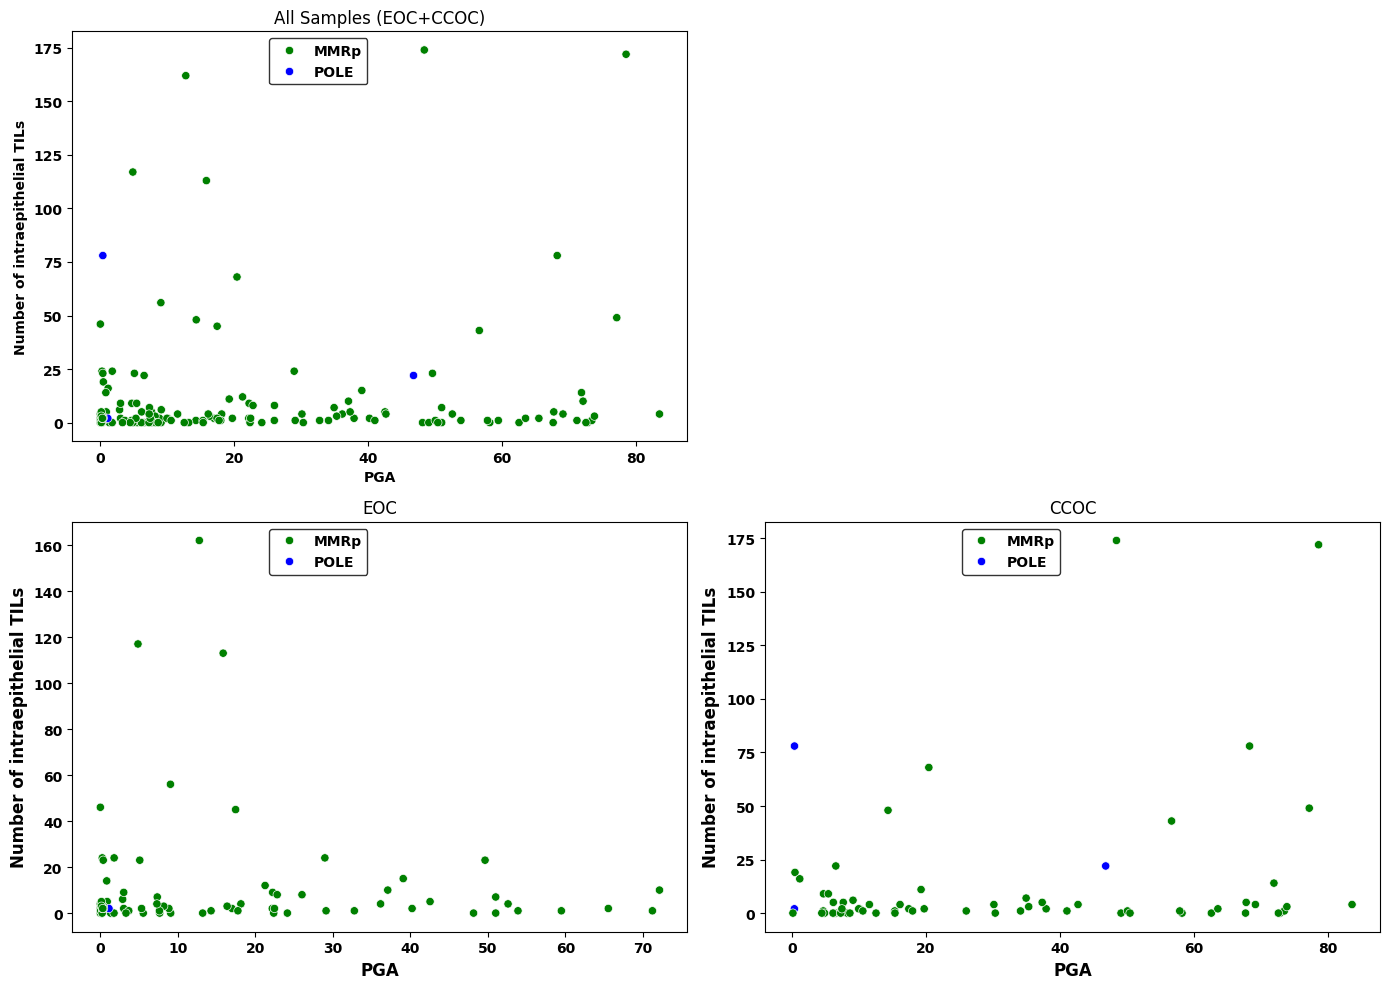

In [19]:
#############    Plots to analyse the relation between PGA and 'TILs_raw_ep' in MMRp samples ########################

# Uncomment to import if not done previously
# import seaborn as sns

# Create a figure with 2 rows and 2 columns of subplots (last cell will remain empty)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # Set figure size for better visibility

# Function to assign colors and categories for legend
def assign_colors_and_labels(row):
    if row['Pol_mutation'] != 'NO' and row['MMR_final_status'] == 'MMRd':
        return 'black', 'MMRd+POLE'  # Black for MMRd + POLE
    elif row['Pol_mutation'] != 'NO':
        return 'blue', 'POLE'  # Blue for POLE
    elif row['MMR_final_status'] == 'MMRd':
        return 'red', 'MMRd'  # Red for MMRd
    else:
        return 'green', 'MMRp'  # Green for MMRp

# Ensure the DataFrames are independent copies
df_all_mmrp = df_all_mmrp.copy()
df_eoc_mmrp = df_eoc_mmrp.copy()
df_cc_mmrp = df_cc_mmrp.copy()

# Use assign to add 'color' and 'category' columns
df_all_mmrp = df_all_mmrp.assign(
    color=df_all_mmrp.apply(lambda row: assign_colors_and_labels(row)[0], axis=1),
    category=df_all_mmrp.apply(lambda row: assign_colors_and_labels(row)[1], axis=1)
)

df_eoc_mmrp = df_eoc_mmrp.assign(
    color=df_eoc_mmrp.apply(lambda row: assign_colors_and_labels(row)[0], axis=1),
    category=df_eoc_mmrp.apply(lambda row: assign_colors_and_labels(row)[1], axis=1)
)

df_cc_mmrp = df_cc_mmrp.assign(
    color=df_cc_mmrp.apply(lambda row: assign_colors_and_labels(row)[0], axis=1),
    category=df_cc_mmrp.apply(lambda row: assign_colors_and_labels(row)[1], axis=1)
)

# Convert 'category' column to a categorical type
df_all_mmrp['category'] = df_all_mmrp['category'].astype('category')
df_eoc_mmrp['category'] = df_eoc_mmrp['category'].astype('category')
df_cc_mmrp['category'] = df_cc_mmrp['category'].astype('category')

# Plot 1: %genome_altered vs TILs_raw_ep for all samples (top-left subplot)
sns.scatterplot(
    ax=axes[0, 0],
    data=df_all_mmrp,
    x='%genome_altered',
    y='TILs_raw_ep',
    hue='category',
    palette={'MMRd+POLE': 'black', 'POLE': 'blue', 'MMRd': 'red', 'MMRp': 'green'},
    legend='full'
)
axes[0, 0].set_title('All Samples (EOC+CCOC)')  # Add title
axes[0, 0].set_xlabel('PGA', fontweight='bold')  # Label for the x-axis
axes[0, 0].set_ylabel('Number of intraepithelial TILs', fontweight='bold')  # Label for the y-axis

# Remove the empty subplot (top-right subplot)
fig.delaxes(axes[0, 1])  # Deletes the unused subplot in the top-right corner

# Plot 2: %genome_altered vs TILs_raw_ep for EOC (bottom-left subplot)
sns.scatterplot(
    ax=axes[1, 0],
    data=df_eoc_mmrp,
    x='%genome_altered',
    y='TILs_raw_ep',
    hue='category',
    palette={'MMRd+POLE': 'black', 'POLE': 'blue', 'MMRd': 'red', 'MMRp': 'green'},
    legend='full'
)
axes[1, 0].set_title('EOC')  # Add title
axes[1, 0].set_xlabel('PGA', fontsize=12, fontweight='bold')  # Label for the x-axis
axes[1, 0].set_ylabel('Number of intraepithelial TILs', fontsize=12, fontweight='bold')  # Label for the y-axis

# Plot 3: %genome_altered vs TILs_raw_ep for CC (bottom-right subplot)
sns.scatterplot(
    ax=axes[1, 1],
    data=df_cc_mmrp,
    x='%genome_altered',
    y='TILs_raw_ep',
    hue='category',
    palette={'MMRd+POLE': 'black', 'POLE': 'blue', 'MMRd': 'red', 'MMRp': 'green'},
    legend='full'
)
axes[1, 1].set_title('CCOC')  # Add title
axes[1, 1].set_xlabel('PGA', fontsize=12, fontweight='bold')  # Label for the x-axis
axes[1, 1].set_ylabel('Number of intraepithelial TILs', fontsize=12, fontweight='bold')  # Label for the y-axis

# Adjust tick labels for all subplots
for ax in axes.flat:
    if ax is not None:  # Check if the subplot exists
        # Set properties for tick labels on both axes
        for label in ax.get_xticklabels() + ax.get_yticklabels():
            label.set_fontsize(10)
            label.set_fontweight('bold')

        # Adjust legend: remove 'category' and set fontweight to bold
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, 
                  loc='upper center',
                  bbox_to_anchor=(0.4, 1),
                  fontsize=10, 
                  title_fontsize=12, 
                  frameon=True,  # Add a frame around the legend
                  facecolor='white',  # Background color inside the legend box
                  edgecolor='black', # Border color around the legend box
                  prop={'weight': 'bold'})  # Make legend text bold

# Adjust layout to prevent overlap between subplots
plt.tight_layout()

# Save the entire figure as a PNG file
output_folder = "/home/vant/TFM/Plots_TFM_final"
output_file = "PGA_vs_TILS_ep_MMRp.png"
plt.savefig(f"{output_folder}/{output_file}", format='png', dpi=300)

# Display the figure
plt.show()

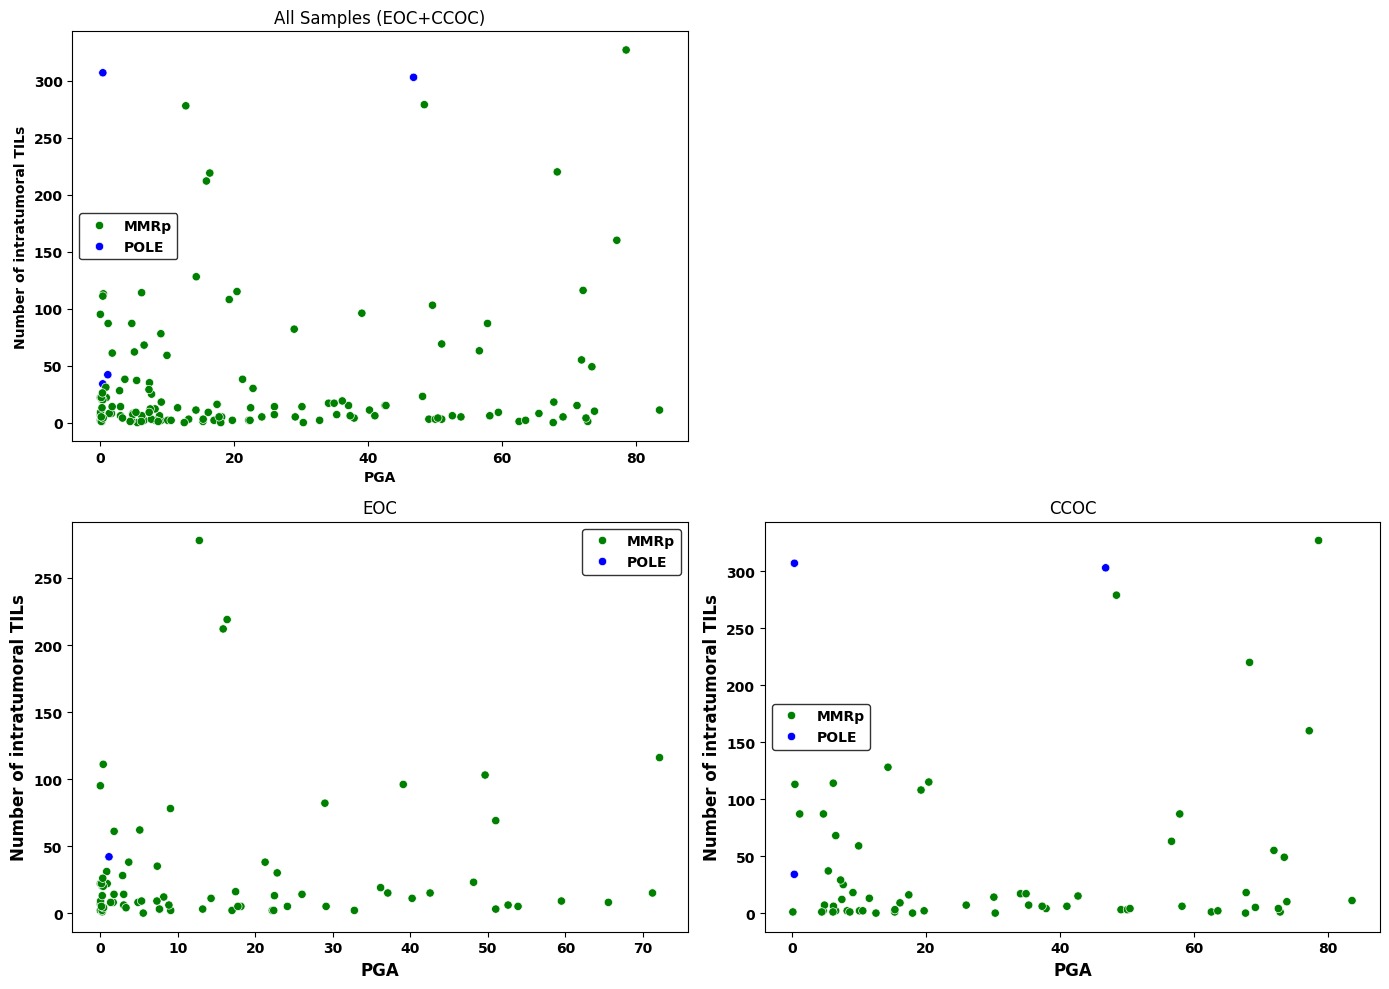

In [21]:
#############    Plots to analyse the relation between PGA and 'TILs_raw_tu' in MMRp samples ########################

# Uncomment to import if not done previously
# import seaborn as sns

# Create a figure with 2 rows and 2 columns of subplots (last cell will remain empty)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # Set figure size for better visibility

# Function to assign colors and categories for legend
def assign_colors_and_labels(row):
    if row['Pol_mutation'] != 'NO' and row['MMR_final_status'] == 'MMRd':
        return 'black', 'MMRd+POLE'  # Black for MMRd + POLE
    elif row['Pol_mutation'] != 'NO':
        return 'blue', 'POLE'  # Blue for POLE
    elif row['MMR_final_status'] == 'MMRd':
        return 'red', 'MMRd'  # Red for MMRd
    else:
        return 'green', 'MMRp'  # Green for MMRp

# Ensure the DataFrames are independent copies
df_all_mmrp = df_all_mmrp.copy()
df_eoc_mmrp = df_eoc_mmrp.copy()
df_cc_mmrp = df_cc_mmrp.copy()

# Use assign to add 'color' and 'category' columns
df_all_mmrp = df_all_mmrp.assign(
    color=df_all_mmrp.apply(lambda row: assign_colors_and_labels(row)[0], axis=1),
    category=df_all_mmrp.apply(lambda row: assign_colors_and_labels(row)[1], axis=1)
)

df_eoc_mmrp = df_eoc_mmrp.assign(
    color=df_eoc_mmrp.apply(lambda row: assign_colors_and_labels(row)[0], axis=1),
    category=df_eoc_mmrp.apply(lambda row: assign_colors_and_labels(row)[1], axis=1)
)

df_cc_mmrp = df_cc_mmrp.assign(
    color=df_cc_mmrp.apply(lambda row: assign_colors_and_labels(row)[0], axis=1),
    category=df_cc_mmrp.apply(lambda row: assign_colors_and_labels(row)[1], axis=1)
)

# Convert 'category' column to a categorical type
df_all_mmrp['category'] = df_all_mmrp['category'].astype('category')
df_eoc_mmrp['category'] = df_eoc_mmrp['category'].astype('category')
df_cc_mmrp['category'] = df_cc_mmrp['category'].astype('category')

# Plot 1: %genome_altered vs TILs_raw_tu for all samples (top-left subplot)
sns.scatterplot(
    ax=axes[0, 0],
    data=df_all_mmrp,
    x='%genome_altered',
    y='TILs_raw_tu',
    hue='category',
    palette={'MMRd+POLE': 'black', 'POLE': 'blue', 'MMRd': 'red', 'MMRp': 'green'},
    legend='full'
)
axes[0, 0].set_title('All Samples (EOC+CCOC)')  # Add title
axes[0, 0].set_xlabel('PGA', fontweight='bold')  # Label for the x-axis
axes[0, 0].set_ylabel('Number of intratumoral TILs', fontweight='bold')  # Label for the y-axis

# Remove the empty subplot (top-right subplot)
fig.delaxes(axes[0, 1])  # Deletes the unused subplot in the top-right corner

# Plot 2: %genome_altered vs TILs_raw_tu for EOC (bottom-left subplot)
sns.scatterplot(
    ax=axes[1, 0],
    data=df_eoc_mmrp,
    x='%genome_altered',
    y='TILs_raw_tu',
    hue='category',
    palette={'MMRd+POLE': 'black', 'POLE': 'blue', 'MMRd': 'red', 'MMRp': 'green'},
    legend='full'
)
axes[1, 0].set_title('EOC')  # Add title
axes[1, 0].set_xlabel('PGA', fontsize=12, fontweight='bold')  # Label for the x-axis
axes[1, 0].set_ylabel('Number of intratumoral TILs', fontsize=12, fontweight='bold')  # Label for the y-axis

# Plot 3: %genome_altered vs TILs_raw_tu for CC (bottom-right subplot)
sns.scatterplot(
    ax=axes[1, 1],
    data=df_cc_mmrp,
    x='%genome_altered',
    y='TILs_raw_tu',
    hue='category',
    palette={'MMRd+POLE': 'black', 'POLE': 'blue', 'MMRd': 'red', 'MMRp': 'green'},
    legend='full'
)
axes[1, 1].set_title('CCOC')  # Add title
axes[1, 1].set_xlabel('PGA', fontsize=12, fontweight='bold')  # Label for the x-axis
axes[1, 1].set_ylabel('Number of intratumoral TILs', fontsize=12, fontweight='bold')  # Label for the y-axis

# Adjust tick labels for all subplots
for ax in axes.flat:
    if ax is not None:  # Check if the subplot exists
        # Set properties for tick labels on both axes
        for label in ax.get_xticklabels() + ax.get_yticklabels():
            label.set_fontsize(10)
            label.set_fontweight('bold')

        # Adjust legend: remove 'category' and set fontweight to bold
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, 
                  loc='best', 
                  fontsize=10, 
                  title_fontsize=12, 
                  frameon=True,  # Add a frame around the legend
                  facecolor='white',  # Background color inside the legend box
                  edgecolor='black', # Border color around the legend box
                  prop={'weight': 'bold'})  # Make legend text bold

# Adjust layout to prevent overlap between subplots
plt.tight_layout()

# Save the entire figure as a PNG file
output_folder = "/home/vant/TFM/Plots_TFM_final"
output_file = "PGA_vs_TILS_tu_MMRp.png"
plt.savefig(f"{output_folder}/{output_file}", format='png', dpi=300)

# Display the figure
plt.show()

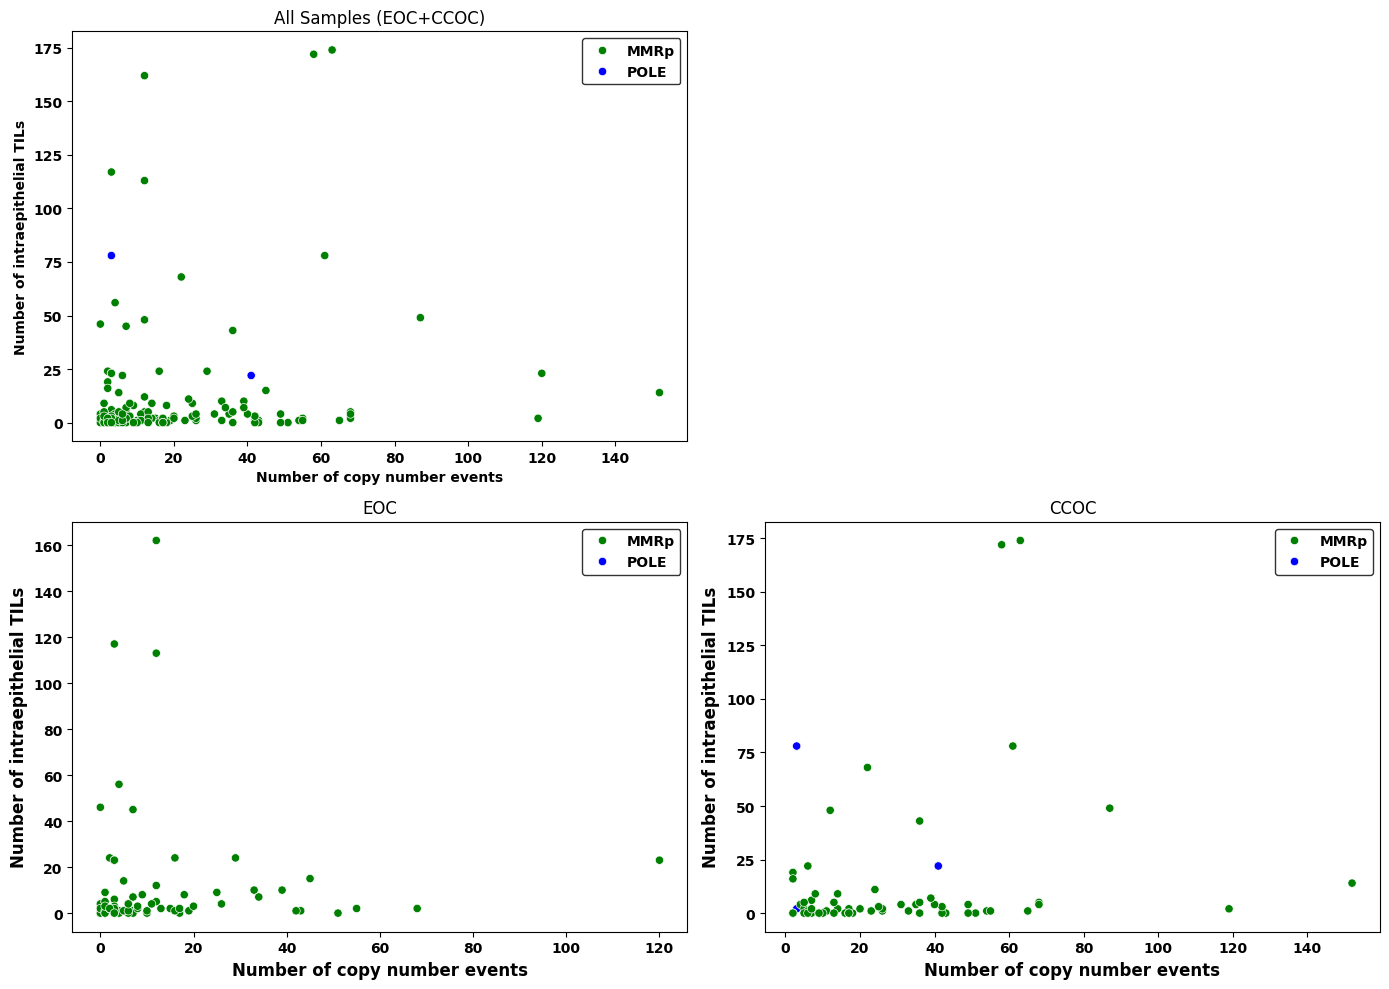

In [22]:
#############    Plots to analyse the relation between CNAs and 'TILs_raw_ep' in MMRp samples ########################

# Uncomment to import if not done previously
# import seaborn as sns

# Create a figure with 2 rows and 2 columns of subplots (last cell will remain empty)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # Set figure size for better visibility

# Function to assign colors and categories for legend
def assign_colors_and_labels(row):
    if row['Pol_mutation'] != 'NO' and row['MMR_final_status'] == 'MMRd':
        return 'black', 'MMRd+POLE'  # Black for MMRd + POLE
    elif row['Pol_mutation'] != 'NO':
        return 'blue', 'POLE'  # Blue for POLE
    elif row['MMR_final_status'] == 'MMRd':
        return 'red', 'MMRd'  # Red for MMRd
    else:
        return 'green', 'MMRp'  # Green for MMRp

# Ensure the DataFrames are independent copies
df_all_mmrp = df_all_mmrp.copy()
df_eoc_mmrp = df_eoc_mmrp.copy()
df_cc_mmrp = df_cc_mmrp.copy()

# Use assign to add 'color' and 'category' columns
df_all_mmrp = df_all_mmrp.assign(
    color=df_all_mmrp.apply(lambda row: assign_colors_and_labels(row)[0], axis=1),
    category=df_all_mmrp.apply(lambda row: assign_colors_and_labels(row)[1], axis=1)
)

df_eoc_mmrp = df_eoc_mmrp.assign(
    color=df_eoc_mmrp.apply(lambda row: assign_colors_and_labels(row)[0], axis=1),
    category=df_eoc_mmrp.apply(lambda row: assign_colors_and_labels(row)[1], axis=1)
)

df_cc_mmrp = df_cc_mmrp.assign(
    color=df_cc_mmrp.apply(lambda row: assign_colors_and_labels(row)[0], axis=1),
    category=df_cc_mmrp.apply(lambda row: assign_colors_and_labels(row)[1], axis=1)
)

# Convert 'category' column to a categorical type
df_all_mmrp['category'] = df_all_mmrp['category'].astype('category')
df_eoc_mmrp['category'] = df_eoc_mmrp['category'].astype('category')
df_cc_mmrp['category'] = df_cc_mmrp['category'].astype('category')

# Plot 1: CNV vs TILs_raw_ep for all samples (top-left subplot)
sns.scatterplot(
    ax=axes[0, 0],
    data=df_all_mmrp,
    x='CNV',
    y='TILs_raw_ep',
    hue='category',
    palette={'MMRd+POLE': 'black', 'POLE': 'blue', 'MMRd': 'red', 'MMRp': 'green'},
    legend='full'
)
axes[0, 0].set_title('All Samples (EOC+CCOC)')  # Add title
axes[0, 0].set_xlabel('Number of copy number events', fontweight='bold')  # Label for the x-axis
axes[0, 0].set_ylabel('Number of intraepithelial TILs', fontweight='bold')  # Label for the y-axis

# Remove the empty subplot (top-right subplot)
fig.delaxes(axes[0, 1])  # Deletes the unused subplot in the top-right corner

# Plot 2: CNV vs TILs_raw_ep for EOC (bottom-left subplot)
sns.scatterplot(
    ax=axes[1, 0],
    data=df_eoc_mmrp,
    x='CNV',
    y='TILs_raw_ep',
    hue='category',
    palette={'MMRd+POLE': 'black', 'POLE': 'blue', 'MMRd': 'red', 'MMRp': 'green'},
    legend='full'
)
axes[1, 0].set_title('EOC')  # Add title
axes[1, 0].set_xlabel('Number of copy number events', fontsize=12, fontweight='bold')  # Label for the x-axis
axes[1, 0].set_ylabel('Number of intraepithelial TILs', fontsize=12, fontweight='bold')  # Label for the y-axis

# Plot 3: CNV vs TILs_raw_ep for CC (bottom-right subplot)
sns.scatterplot(
    ax=axes[1, 1],
    data=df_cc_mmrp,
    x='CNV',
    y='TILs_raw_ep',
    hue='category',
    palette={'MMRd+POLE': 'black', 'POLE': 'blue', 'MMRd': 'red', 'MMRp': 'green'},
    legend='full'
)
axes[1, 1].set_title('CCOC')  # Add title
axes[1, 1].set_xlabel('Number of copy number events', fontsize=12, fontweight='bold')  # Label for the x-axis
axes[1, 1].set_ylabel('Number of intraepithelial TILs', fontsize=12, fontweight='bold')  # Label for the y-axis

# Adjust tick labels for all subplots
for ax in axes.flat:
    if ax is not None:  # Check if the subplot exists
        # Set properties for tick labels on both axes
        for label in ax.get_xticklabels() + ax.get_yticklabels():
            label.set_fontsize(10)
            label.set_fontweight('bold')

        # Adjust legend: remove 'category' and set fontweight to bold
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, 
                  loc='upper right', 
                  fontsize=10, 
                  title_fontsize=12, 
                  frameon=True,  # Add a frame around the legend
                  facecolor='white',  # Background color inside the legend box
                  edgecolor='black', # Border color around the legend box
                  prop={'weight': 'bold'})  # Make legend text bold

# Adjust layout to prevent overlap between subplots
plt.tight_layout()

# Save the entire figure as a PNG file
output_folder = "/home/vant/TFM/Plots_TFM_final"
output_file = "CNAs_vs_TILS_ep_MMRp.png"
plt.savefig(f"{output_folder}/{output_file}", format='png', dpi=300)

# Display the figure
plt.show()

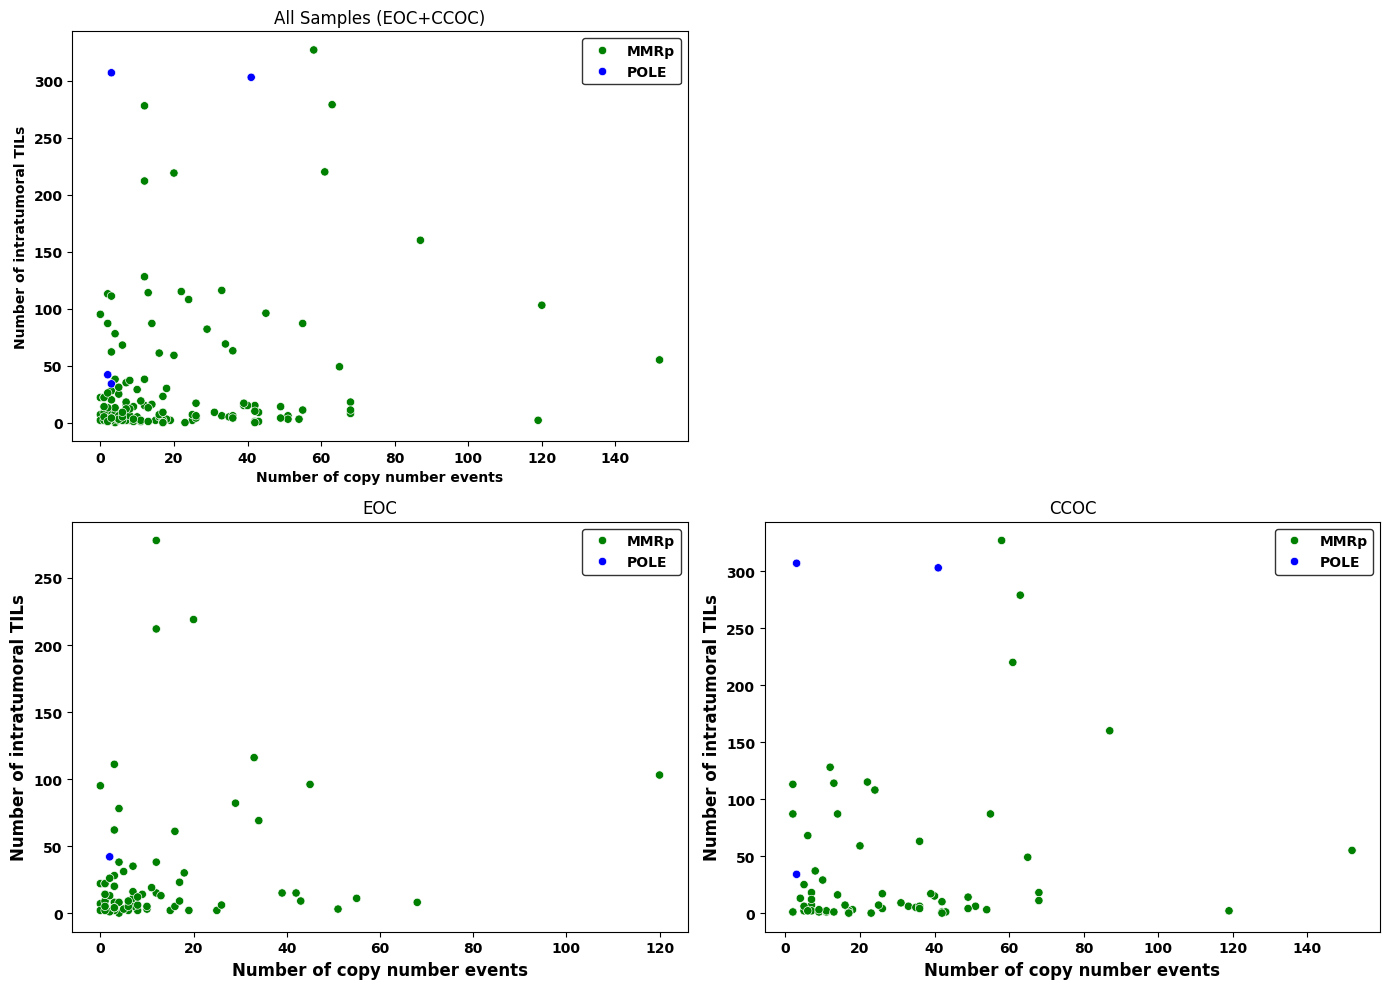

In [23]:
#############    Plots to analyse the relation between CNAs and 'TILs_raw_tu' in MMRp samples ########################

# Uncomment to import if not done previously
# import seaborn as sns

# Create a figure with 2 rows and 2 columns of subplots (last cell will remain empty)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # Set figure size for better visibility

# Function to assign colors and categories for legend
def assign_colors_and_labels(row):
    if row['Pol_mutation'] != 'NO' and row['MMR_final_status'] == 'MMRd':
        return 'black', 'MMRd+POLE'  # Black for MMRd + POLE
    elif row['Pol_mutation'] != 'NO':
        return 'blue', 'POLE'  # Blue for POLE
    elif row['MMR_final_status'] == 'MMRd':
        return 'red', 'MMRd'  # Red for MMRd
    else:
        return 'green', 'MMRp'  # Green for MMRp

# Ensure the DataFrames are independent copies
df_all_mmrp = df_all_mmrp.copy()
df_eoc_mmrp = df_eoc_mmrp.copy()
df_cc_mmrp = df_cc_mmrp.copy()

# Use assign to add 'color' and 'category' columns
df_all_mmrp = df_all_mmrp.assign(
    color=df_all_mmrp.apply(lambda row: assign_colors_and_labels(row)[0], axis=1),
    category=df_all_mmrp.apply(lambda row: assign_colors_and_labels(row)[1], axis=1)
)

df_eoc_mmrp = df_eoc_mmrp.assign(
    color=df_eoc_mmrp.apply(lambda row: assign_colors_and_labels(row)[0], axis=1),
    category=df_eoc_mmrp.apply(lambda row: assign_colors_and_labels(row)[1], axis=1)
)

df_cc_mmrp = df_cc_mmrp.assign(
    color=df_cc_mmrp.apply(lambda row: assign_colors_and_labels(row)[0], axis=1),
    category=df_cc_mmrp.apply(lambda row: assign_colors_and_labels(row)[1], axis=1)
)

# Convert 'category' column to a categorical type
df_all_mmrp['category'] = df_all_mmrp['category'].astype('category')
df_eoc_mmrp['category'] = df_eoc_mmrp['category'].astype('category')
df_cc_mmrp['category'] = df_cc_mmrp['category'].astype('category')

# Plot 1: CNV vs TILs_raw_tu for all samples (top-left subplot)
sns.scatterplot(
    ax=axes[0, 0],
    data=df_all_mmrp,
    x='CNV',
    y='TILs_raw_tu',
    hue='category',
    palette={'MMRd+POLE': 'black', 'POLE': 'blue', 'MMRd': 'red', 'MMRp': 'green'},
    legend='full'
)
axes[0, 0].set_title('All Samples (EOC+CCOC)')  # Add title
axes[0, 0].set_xlabel('Number of copy number events', fontweight='bold')  # Label for the x-axis
axes[0, 0].set_ylabel('Number of intratumoral TILs', fontweight='bold')  # Label for the y-axis

# Remove the empty subplot (top-right subplot)
fig.delaxes(axes[0, 1])  # Deletes the unused subplot in the top-right corner

# Plot 2: CNV vs TILs_raw_tu for EOC (bottom-left subplot)
sns.scatterplot(
    ax=axes[1, 0],
    data=df_eoc_mmrp,
    x='CNV',
    y='TILs_raw_tu',
    hue='category',
    palette={'MMRd+POLE': 'black', 'POLE': 'blue', 'MMRd': 'red', 'MMRp': 'green'},
    legend='full'
)
axes[1, 0].set_title('EOC')  # Add title
axes[1, 0].set_xlabel('Number of copy number events', fontsize=12, fontweight='bold')  # Label for the x-axis
axes[1, 0].set_ylabel('Number of intratumoral TILs', fontsize=12, fontweight='bold')  # Label for the y-axis

# Plot 3: CNV vs TILs_raw_tu for CC (bottom-right subplot)
sns.scatterplot(
    ax=axes[1, 1],
    data=df_cc_mmrp,
    x='CNV',
    y='TILs_raw_tu',
    hue='category',
    palette={'MMRd+POLE': 'black', 'POLE': 'blue', 'MMRd': 'red', 'MMRp': 'green'},
    legend='full'
)
axes[1, 1].set_title('CCOC')  # Add title
axes[1, 1].set_xlabel('Number of copy number events', fontsize=12, fontweight='bold')  # Label for the x-axis
axes[1, 1].set_ylabel('Number of intratumoral TILs', fontsize=12, fontweight='bold')  # Label for the y-axis

# Adjust tick labels for all subplots
for ax in axes.flat:
    if ax is not None:  # Check if the subplot exists
        # Set properties for tick labels on both axes
        for label in ax.get_xticklabels() + ax.get_yticklabels():
            label.set_fontsize(10)
            label.set_fontweight('bold')

        # Adjust legend: remove 'category' and set fontweight to bold
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, 
                  loc='upper right', 
                  fontsize=10, 
                  title_fontsize=12, 
                  frameon=True,  # Add a frame around the legend
                  facecolor='white',  # Background color inside the legend box
                  edgecolor='black', # Border color around the legend box
                  prop={'weight': 'bold'})  # Make legend text bold

# Adjust layout to prevent overlap between subplots
plt.tight_layout()

# Save the entire figure as a PNG file
output_folder = "/home/vant/TFM/Plots_TFM_final"
output_file = "CNAs_vs_TILS_tu_MMRp.png"
plt.savefig(f"{output_folder}/{output_file}", format='png', dpi=300)

# Display the figure
plt.show()

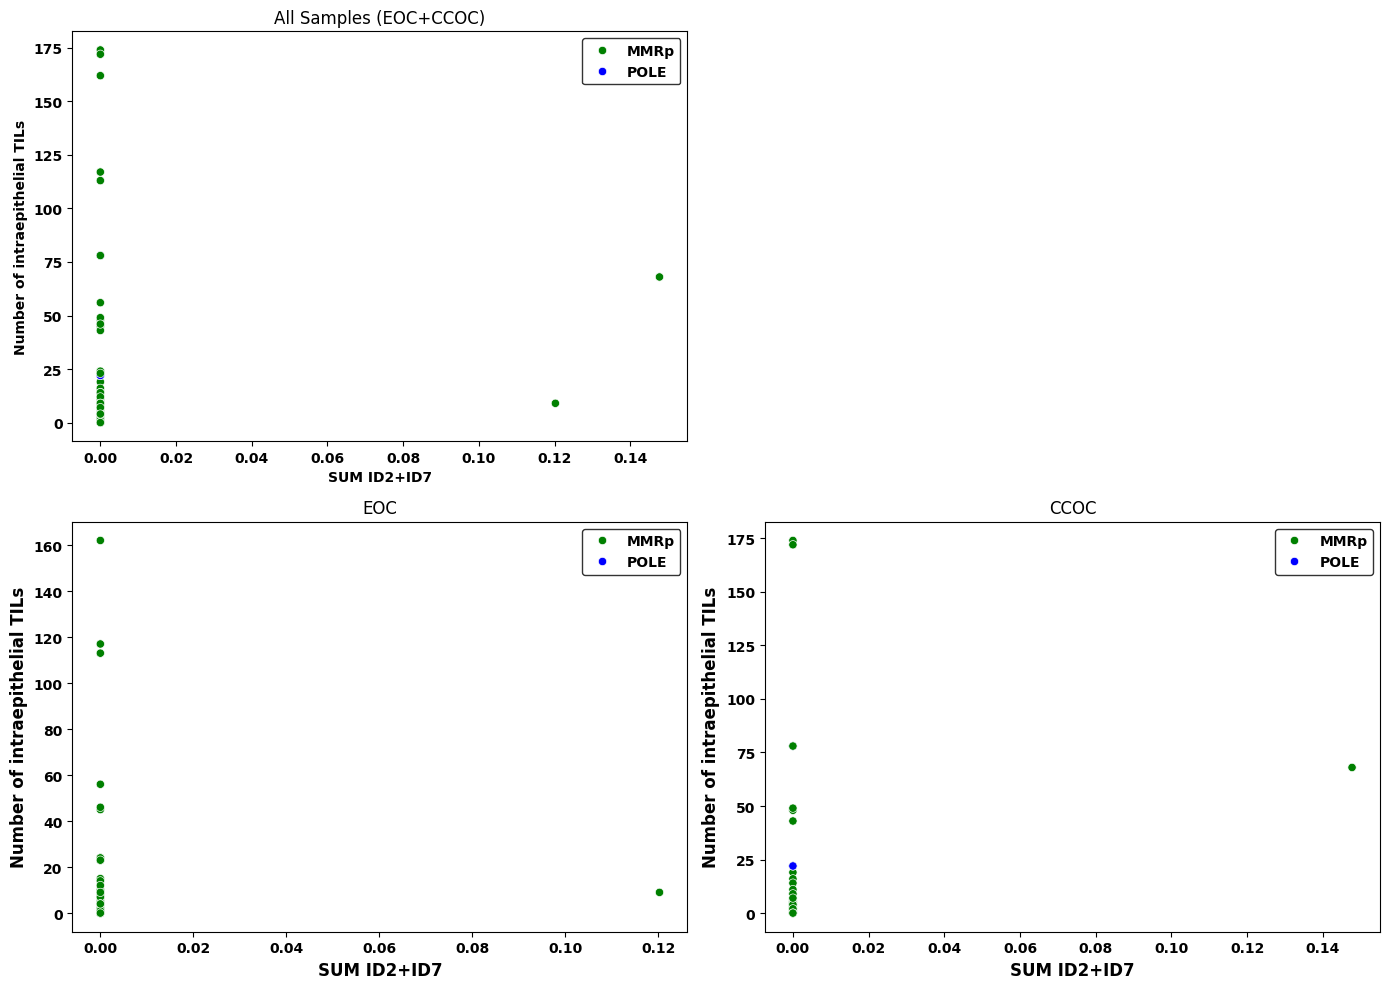

In [24]:
#############    Plots to analyse the relation between 'SUM ID2+ID7' and 'TILs_raw_ep' in MMRp samples ########################

# Uncomment to import if not done previously
# import seaborn as sns

# Create a figure with 2 rows and 2 columns of subplots (last cell will remain empty)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # Set figure size for better visibility

# Function to assign colors and categories for legend
def assign_colors_and_labels(row):
    if row['Pol_mutation'] != 'NO' and row['MMR_final_status'] == 'MMRd':
        return 'black', 'MMRd+POLE'  # Black for MMRd + POLE
    elif row['Pol_mutation'] != 'NO':
        return 'blue', 'POLE'  # Blue for POLE
    elif row['MMR_final_status'] == 'MMRd':
        return 'red', 'MMRd'  # Red for MMRd
    else:
        return 'green', 'MMRp'  # Green for MMRp

# Ensure the DataFrames are independent copies
df_all_mmrp = df_all_mmrp.copy()
df_eoc_mmrp = df_eoc_mmrp.copy()
df_cc_mmrp = df_cc_mmrp.copy()

# Use assign to add 'color' and 'category' columns
df_all_mmrp = df_all_mmrp.assign(
    color=df_all_mmrp.apply(lambda row: assign_colors_and_labels(row)[0], axis=1),
    category=df_all_mmrp.apply(lambda row: assign_colors_and_labels(row)[1], axis=1)
)

df_eoc_mmrp = df_eoc_mmrp.assign(
    color=df_eoc_mmrp.apply(lambda row: assign_colors_and_labels(row)[0], axis=1),
    category=df_eoc_mmrp.apply(lambda row: assign_colors_and_labels(row)[1], axis=1)
)

df_cc_mmrp = df_cc_mmrp.assign(
    color=df_cc_mmrp.apply(lambda row: assign_colors_and_labels(row)[0], axis=1),
    category=df_cc_mmrp.apply(lambda row: assign_colors_and_labels(row)[1], axis=1)
)

# Convert 'category' column to a categorical type
df_all_mmrp['category'] = df_all_mmrp['category'].astype('category')
df_eoc_mmrp['category'] = df_eoc_mmrp['category'].astype('category')
df_cc_mmrp['category'] = df_cc_mmrp['category'].astype('category')

# Plot 1: SUM ID2+ID7 vs TILs_raw_ep for all samples (top-left subplot)
sns.scatterplot(
    ax=axes[0, 0],
    data=df_all_mmrp,
    x='SUM ID2+ID7',
    y='TILs_raw_ep',
    hue='category',
    palette={'MMRd+POLE': 'black', 'POLE': 'blue', 'MMRd': 'red', 'MMRp': 'green'},
    legend='full'
)
axes[0, 0].set_title('All Samples (EOC+CCOC)')  # Add title
axes[0, 0].set_xlabel('SUM ID2+ID7', fontweight='bold')  # Label for the x-axis
axes[0, 0].set_ylabel('Number of intraepithelial TILs', fontweight='bold')  # Label for the y-axis

# Remove the empty subplot (top-right subplot)
fig.delaxes(axes[0, 1])  # Deletes the unused subplot in the top-right corner

# Plot 2: SUM ID2+ID7 vs TILs_raw_ep for EOC (bottom-left subplot)
sns.scatterplot(
    ax=axes[1, 0],
    data=df_eoc_mmrp,
    x='SUM ID2+ID7',
    y='TILs_raw_ep',
    hue='category',
    palette={'MMRd+POLE': 'black', 'POLE': 'blue', 'MMRd': 'red', 'MMRp': 'green'},
    legend='full'
)
axes[1, 0].set_title('EOC')  # Add title
axes[1, 0].set_xlabel('SUM ID2+ID7', fontsize=12, fontweight='bold')  # Label for the x-axis
axes[1, 0].set_ylabel('Number of intraepithelial TILs', fontsize=12, fontweight='bold')  # Label for the y-axis

# Plot 3: SUM ID2+ID7 vs TILs_raw_ep for CC (bottom-right subplot)
sns.scatterplot(
    ax=axes[1, 1],
    data=df_cc_mmrp,
    x='SUM ID2+ID7',
    y='TILs_raw_ep',
    hue='category',
    palette={'MMRd+POLE': 'black', 'POLE': 'blue', 'MMRd': 'red', 'MMRp': 'green'},
    legend='full'
)
axes[1, 1].set_title('CCOC')  # Add title
axes[1, 1].set_xlabel('SUM ID2+ID7', fontsize=12, fontweight='bold')  # Label for the x-axis
axes[1, 1].set_ylabel('Number of intraepithelial TILs', fontsize=12, fontweight='bold')  # Label for the y-axis

# Adjust tick labels for all subplots
for ax in axes.flat:
    if ax is not None:  # Check if the subplot exists
        # Set properties for tick labels on both axes
        for label in ax.get_xticklabels() + ax.get_yticklabels():
            label.set_fontsize(10)
            label.set_fontweight('bold')

        # Adjust legend: remove 'category' and set fontweight to bold
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, 
                  loc='upper right', 
                  fontsize=10, 
                  title_fontsize=12, 
                  frameon=True,  # Add a frame around the legend
                  facecolor='white',  # Background color inside the legend box
                  edgecolor='black', # Border color around the legend box
                  prop={'weight': 'bold'})  # Make legend text bold

# Adjust layout to prevent overlap between subplots
plt.tight_layout()

# Save the entire figure as a PNG file
output_folder = "/home/vant/TFM/Plots_TFM_final"
output_file = "SUM_ID2+ID7_vs_TILS_ep_MMRp.png"
plt.savefig(f"{output_folder}/{output_file}", format='png', dpi=300)

# Display the figure
plt.show()

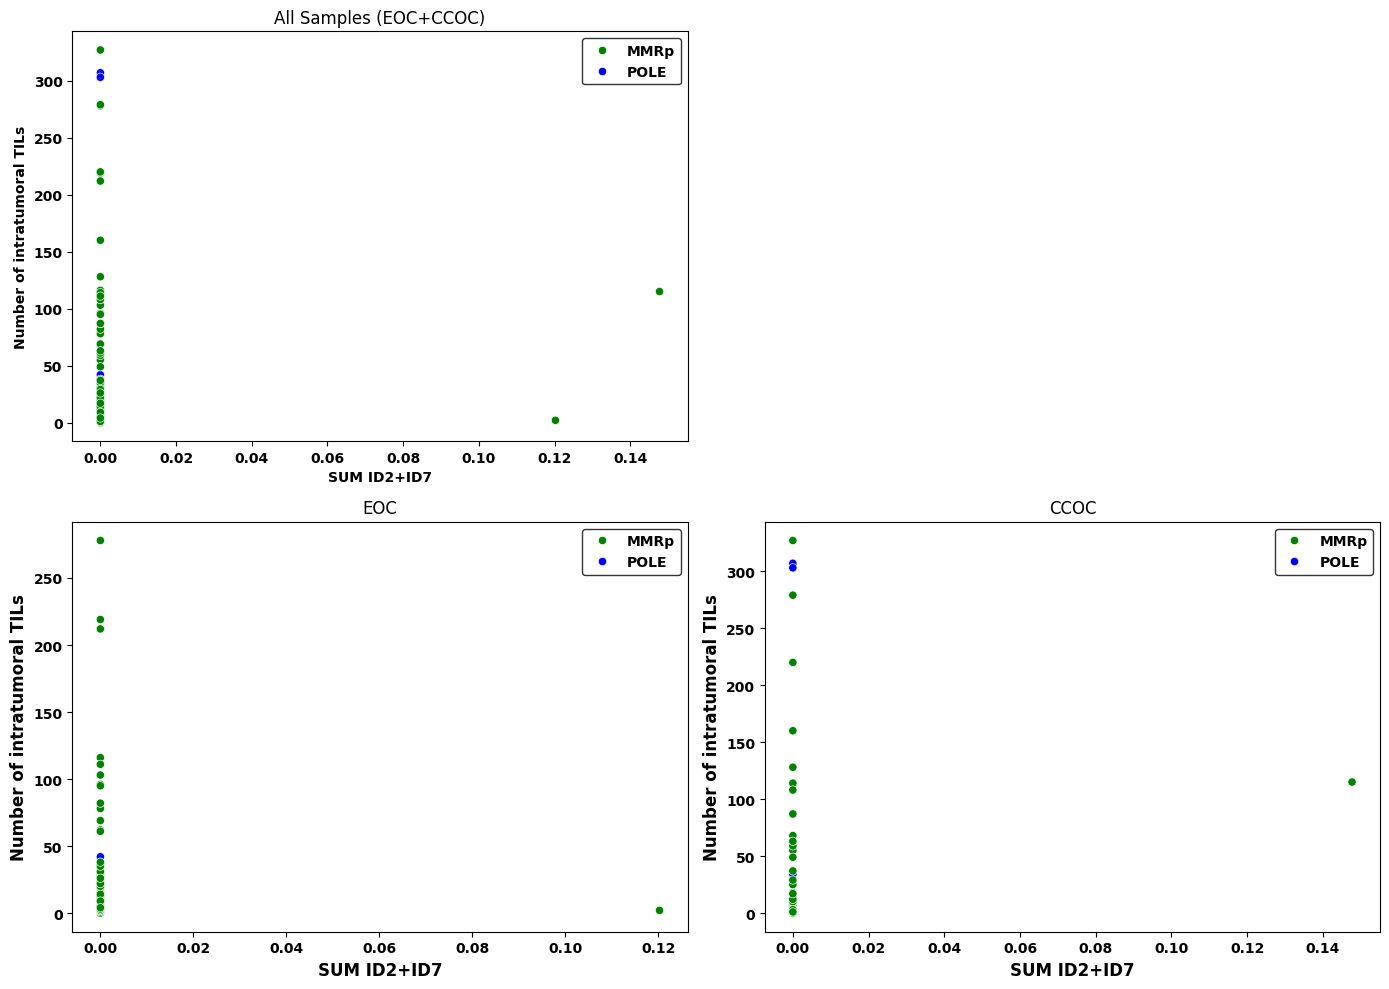

In [25]:
#############    Plots to analyse the relation between 'SUM ID2+ID7' and 'TILs_raw_tu' in MMRp samples ########################

# Uncomment to import if not done previously
# import seaborn as sns

# Create a figure with 2 rows and 2 columns of subplots (last cell will remain empty)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # Set figure size for better visibility

# Function to assign colors and categories for legend
def assign_colors_and_labels(row):
    if row['Pol_mutation'] != 'NO' and row['MMR_final_status'] == 'MMRd':
        return 'black', 'MMRd+POLE'  # Black for MMRd + POLE
    elif row['Pol_mutation'] != 'NO':
        return 'blue', 'POLE'  # Blue for POLE
    elif row['MMR_final_status'] == 'MMRd':
        return 'red', 'MMRd'  # Red for MMRd
    else:
        return 'green', 'MMRp'  # Green for MMRp

# Ensure the DataFrames are independent copies
df_all_mmrp = df_all_mmrp.copy()
df_eoc_mmrp = df_eoc_mmrp.copy()
df_cc_mmrp = df_cc_mmrp.copy()

# Use assign to add 'color' and 'category' columns
df_all_mmrp = df_all_mmrp.assign(
    color=df_all_mmrp.apply(lambda row: assign_colors_and_labels(row)[0], axis=1),
    category=df_all_mmrp.apply(lambda row: assign_colors_and_labels(row)[1], axis=1)
)

df_eoc_mmrp = df_eoc_mmrp.assign(
    color=df_eoc_mmrp.apply(lambda row: assign_colors_and_labels(row)[0], axis=1),
    category=df_eoc_mmrp.apply(lambda row: assign_colors_and_labels(row)[1], axis=1)
)

df_cc_mmrp = df_cc_mmrp.assign(
    color=df_cc_mmrp.apply(lambda row: assign_colors_and_labels(row)[0], axis=1),
    category=df_cc_mmrp.apply(lambda row: assign_colors_and_labels(row)[1], axis=1)
)

# Convert 'category' column to a categorical type
df_all_mmrp['category'] = df_all_mmrp['category'].astype('category')
df_eoc_mmrp['category'] = df_eoc_mmrp['category'].astype('category')
df_cc_mmrp['category'] = df_cc_mmrp['category'].astype('category')

# Plot 1: SUM ID2+ID7 vs TILs_raw_tu for all samples (top-left subplot)
sns.scatterplot(
    ax=axes[0, 0],
    data=df_all_mmrp,
    x='SUM ID2+ID7',
    y='TILs_raw_tu',
    hue='category',
    palette={'MMRd+POLE': 'black', 'POLE': 'blue', 'MMRd': 'red', 'MMRp': 'green'},
    legend='full'
)
axes[0, 0].set_title('All Samples (EOC+CCOC)')  # Add title
axes[0, 0].set_xlabel('SUM ID2+ID7', fontweight='bold')  # Label for the x-axis
axes[0, 0].set_ylabel('Number of intratumoral TILs', fontweight='bold')  # Label for the y-axis

# Remove the empty subplot (top-right subplot)
fig.delaxes(axes[0, 1])  # Deletes the unused subplot in the top-right corner

# Plot 2: SUM ID2+ID7 vs TILs_raw_tu for EOC (bottom-left subplot)
sns.scatterplot(
    ax=axes[1, 0],
    data=df_eoc_mmrp,
    x='SUM ID2+ID7',
    y='TILs_raw_tu',
    hue='category',
    palette={'MMRd+POLE': 'black', 'POLE': 'blue', 'MMRd': 'red', 'MMRp': 'green'},
    legend='full'
)
axes[1, 0].set_title('EOC')  # Add title
axes[1, 0].set_xlabel('SUM ID2+ID7', fontsize=12, fontweight='bold')  # Label for the x-axis
axes[1, 0].set_ylabel('Number of intratumoral TILs', fontsize=12, fontweight='bold')  # Label for the y-axis

# Plot 3: SUM ID2+ID7 vs TILs_raw_tu for CC (bottom-right subplot)
sns.scatterplot(
    ax=axes[1, 1],
    data=df_cc_mmrp,
    x='SUM ID2+ID7',
    y='TILs_raw_tu',
    hue='category',
    palette={'MMRd+POLE': 'black', 'POLE': 'blue', 'MMRd': 'red', 'MMRp': 'green'},
    legend='full'
)
axes[1, 1].set_title('CCOC')  # Add title
axes[1, 1].set_xlabel('SUM ID2+ID7', fontsize=12, fontweight='bold')  # Label for the x-axis
axes[1, 1].set_ylabel('Number of intratumoral TILs', fontsize=12, fontweight='bold')  # Label for the y-axis

# Adjust tick labels for all subplots
for ax in axes.flat:
    if ax is not None:  # Check if the subplot exists
        # Set properties for tick labels on both axes
        for label in ax.get_xticklabels() + ax.get_yticklabels():
            label.set_fontsize(10)
            label.set_fontweight('bold')

        # Adjust legend: remove 'category' and set fontweight to bold
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, 
                  loc='upper right', 
                  fontsize=10, 
                  title_fontsize=12, 
                  frameon=True,  # Add a frame around the legend
                  facecolor='white',  # Background color inside the legend box
                  edgecolor='black', # Border color around the legend box
                  prop={'weight': 'bold'})  # Make legend text bold

# Adjust layout to prevent overlap between subplots
plt.tight_layout()

# Save the entire figure as a PNG file
output_folder = "/home/vant/TFM/Plots_TFM_final"
output_file = "SUM_ID2+ID7_vs_TILS_tu_MMRp.png"
plt.savefig(f"{output_folder}/{output_file}", format='png', dpi=300)

# Display the figure
plt.show()

In [ ]:
######### OTHER TYPES OF GRAPHICS ############################
##############################################################

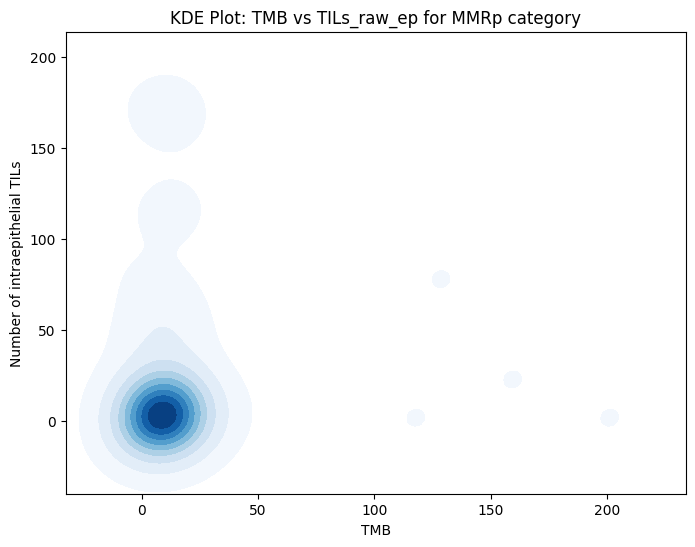

In [26]:
## KDE plot
plt.figure(figsize=(8, 6))
sns.kdeplot(data=df_all_mmrp, x='TMB', y='TILs_raw_ep', cmap="Blues", fill=True)

# Add title and labels
plt.title('KDE Plot: TMB vs TILs_raw_ep for MMRp category')
plt.xlabel('TMB')
plt.ylabel('Number of intraepithelial TILs')
# Show plot
plt.show()

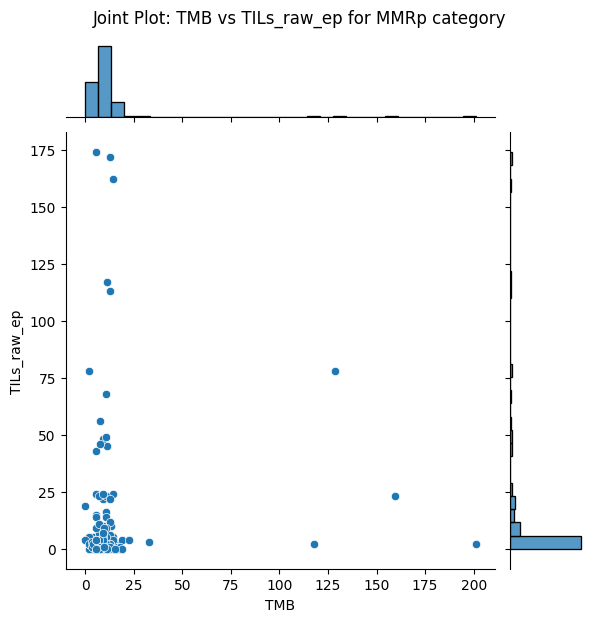

In [27]:
### Joint plot
sns.jointplot(data=df_all_mmrp, x='TMB', y='TILs_raw_ep', kind='scatter', marginal_kws=dict(bins=30, fill=True))

# Add title
plt.suptitle('Joint Plot: TMB vs TILs_raw_ep for MMRp category', y=1.03)

# Show plot
plt.show()


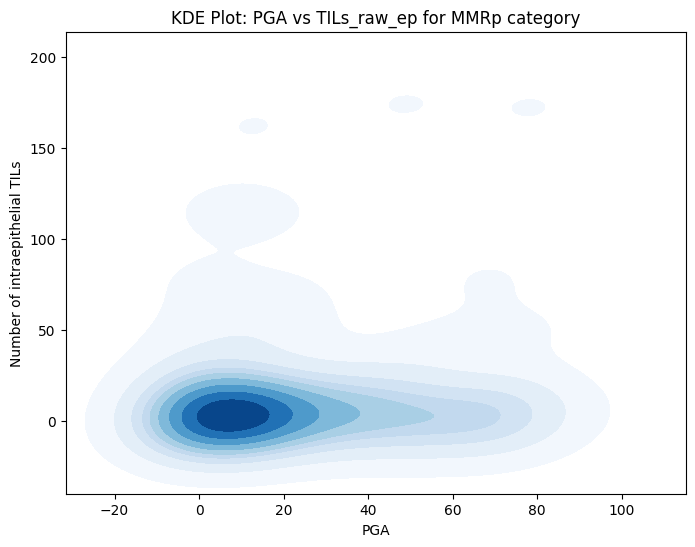

In [28]:
# KDE plot for PGA vs TILs_raw_ep
plt.figure(figsize=(8, 6))
sns.kdeplot(data=df_all_mmrp, x='%genome_altered', y='TILs_raw_ep', cmap="Blues", fill=True)

# Add title and labels
plt.title('KDE Plot: PGA vs TILs_raw_ep for MMRp category')
plt.xlabel('PGA')
plt.ylabel('Number of intraepithelial TILs')
# Show plot
plt.show()

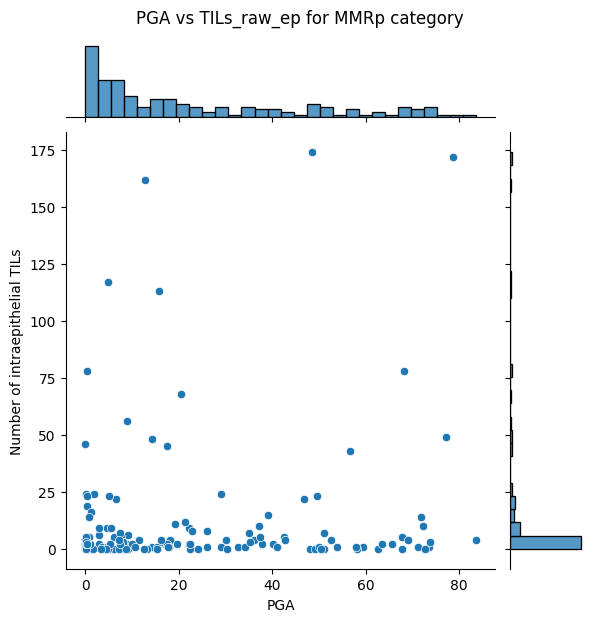

In [30]:
# Joint plot 
sns.jointplot(data=df_all_mmrp, x='%genome_altered', y='TILs_raw_ep', kind='scatter', marginal_kws=dict(bins=30, fill=True))
# Add title and labels
plt.suptitle('PGA vs TILs_raw_ep for MMRp category', y=1.03)
plt.xlabel('PGA')
plt.ylabel('Number of intraepithelial TILs')
# Show plot
plt.show()

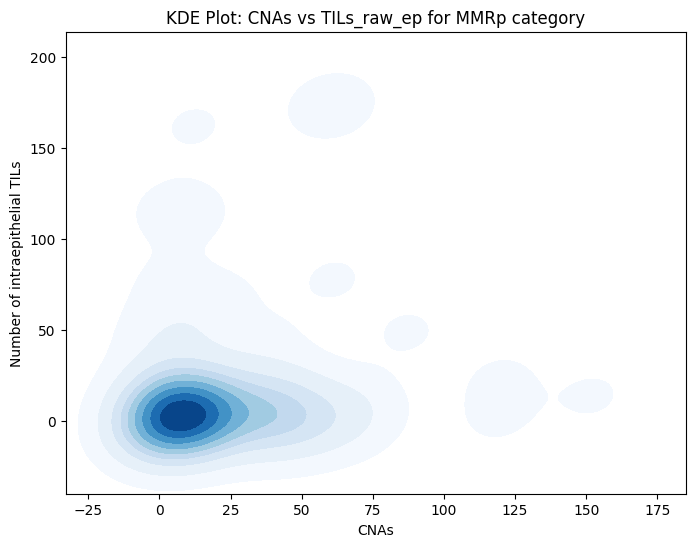

In [32]:
# KDE plot for CNAs vs TILs_raw_ep
plt.figure(figsize=(8, 6))
sns.kdeplot(data=df_all_mmrp, x='CNV', y='TILs_raw_ep', cmap="Blues", fill=True)
# Add title and labels
plt.title('KDE Plot: CNAs vs TILs_raw_ep for MMRp category')
plt.xlabel('CNAs')
plt.ylabel('Number of intraepithelial TILs')
# Show plot
plt.show()

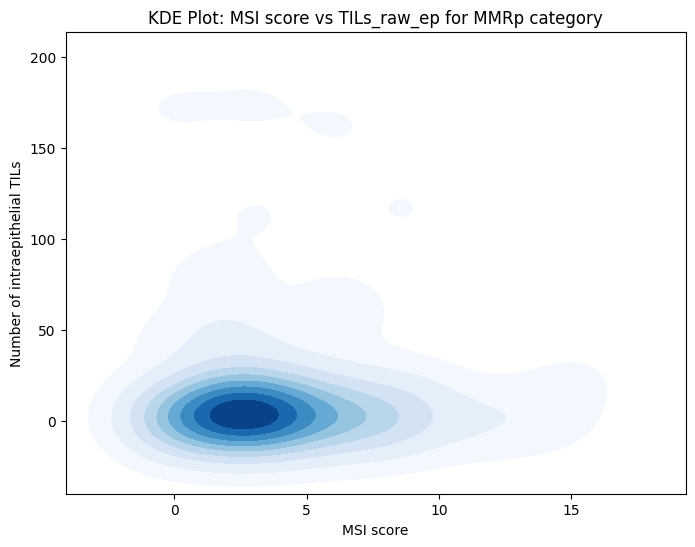

In [33]:
# KDE plot for MSI score vs TILs_raw_ep
plt.figure(figsize=(8, 6))
sns.kdeplot(data=df_all_mmrp, x='MSI_sensor2', y='TILs_raw_ep', cmap="Blues", fill=True)

# Add title and labels
plt.title('KDE Plot: MSI score vs TILs_raw_ep for MMRp category')
plt.xlabel('MSI score')
plt.ylabel('Number of intraepithelial TILs')

# Show plot
plt.show()

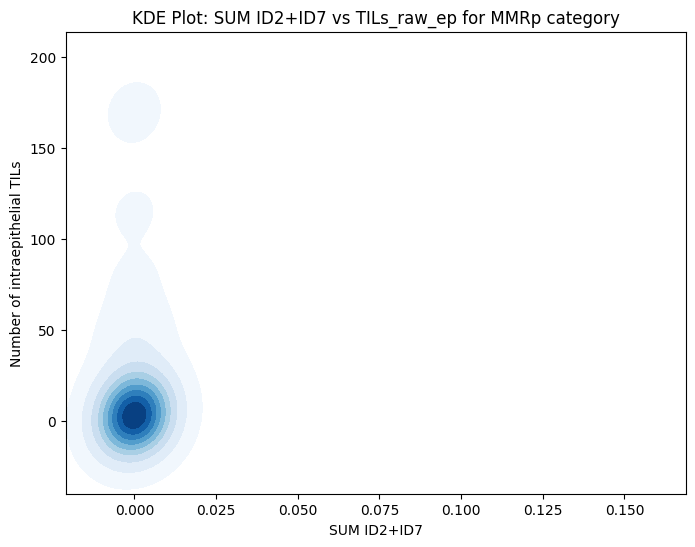

In [34]:
# KDE plot for 'SUM ID2+ID7' vs TILs_raw_ep
plt.figure(figsize=(8, 6))
sns.kdeplot(data=df_all_mmrp, x='SUM ID2+ID7', y='TILs_raw_ep', cmap="Blues", fill=True)

# Add title and labels
plt.title('KDE Plot: SUM ID2+ID7 vs TILs_raw_ep for MMRp category')
plt.xlabel('SUM ID2+ID7')
plt.ylabel('Number of intraepithelial TILs')

# Show plot
plt.show()

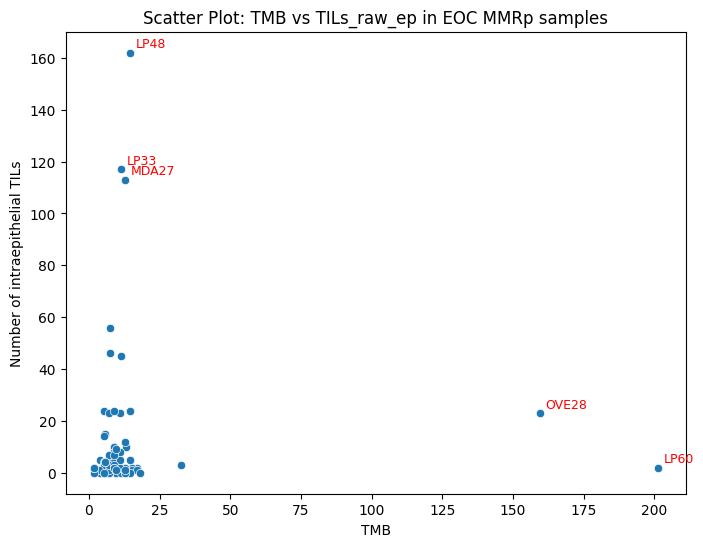

In [7]:
## Scatter plot with annotations for TMB score vs TILs_raw_ep in EOC MMRp samples ###### #########

# Create the figure
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_eoc_mmrp, x='TMB', y='TILs_raw_ep')

# Add title and labels
plt.title("Scatter Plot: TMB vs TILs_raw_ep in EOC MMRp samples")
plt.xlabel('TMB')
plt.ylabel('Number of intraepithelial TILs')

# Filter samples to highlight
highlighted_samples = df_eoc_mmrp[(df_eoc_mmrp['TILs_raw_ep'] > 100) | (df_eoc_mmrp['TMB'] > 100)]

# Add ID of samples with TMB > 100 or number of intraepithelial TILs > 100
for _, row in highlighted_samples.iterrows():
    plt.text(row['TMB'] + 2.1, row['TILs_raw_ep'] + 2, row['ID_CNIO'], 
             fontsize=9, ha='left', color='red')

# Show
plt.show()

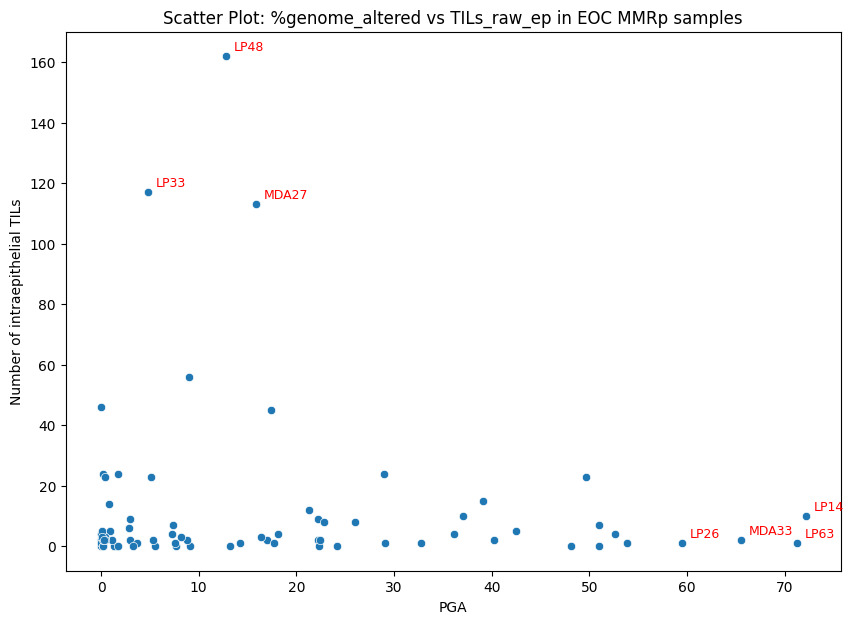

In [8]:
# Scatterplot with annotations for PGA vs TILs_raw_ep in EOC MMRp samples ######
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_eoc_mmrp, y='TILs_raw_ep', x='%genome_altered')

# Add title and labels
plt.title("Scatter Plot: %genome_altered vs TILs_raw_ep in EOC MMRp samples")
plt.ylabel('Number of intraepithelial TILs')
plt.xlabel('PGA')

# Filter
highlighted_samples = df_eoc_mmrp[(df_eoc_mmrp['TILs_raw_ep'] > 100) | (df_eoc_mmrp['%genome_altered'] > 55)]
# Annotations
for _, row in highlighted_samples.iterrows():
    plt.text(row['%genome_altered']+0.8 , row['TILs_raw_ep']+2, row['ID_CNIO'], 
             fontsize=9, ha='left', color='red')
# Show
plt.show()

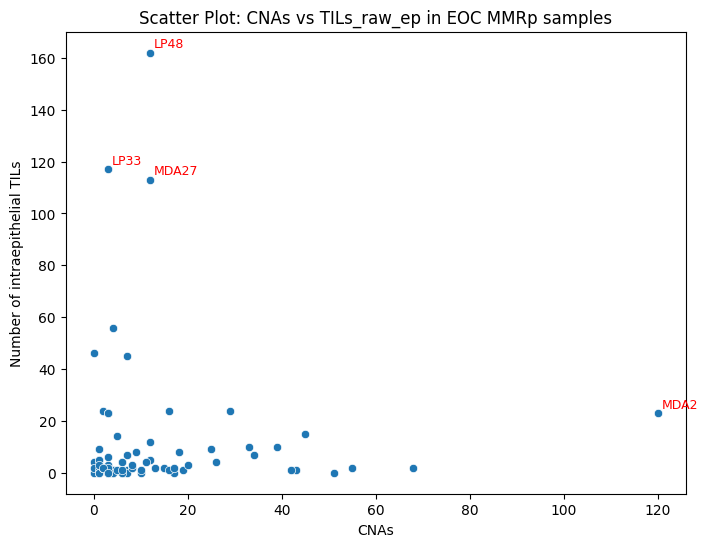

In [9]:
## Scatterplot with annotations for CNAs vs TILs_raw_ep in EOC MMRp samples ##########
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_eoc_mmrp, y='TILs_raw_ep', x='CNV')

# Add title and labels
plt.title("Scatter Plot: CNAs vs TILs_raw_ep in EOC MMRp samples")
plt.ylabel('Number of intraepithelial TILs')
plt.xlabel('CNAs')

# Filter
highlighted_samples = df_eoc_mmrp[(df_eoc_mmrp['TILs_raw_ep'] > 100) | (df_eoc_mmrp['CNV'] > 100)]

# Annotations
for _, row in highlighted_samples.iterrows():
    plt.text(row['CNV']+0.8 , row['TILs_raw_ep']+2, row['ID_CNIO'], 
             fontsize=9, ha='left', color='red')

# Show
plt.show()

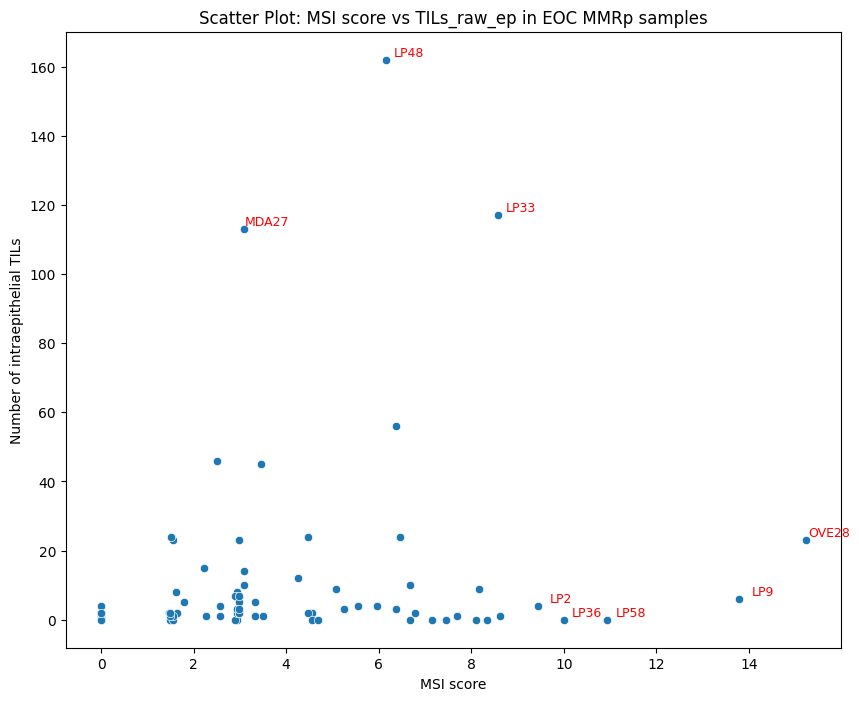

In [10]:
## Scatterplot with annotations for MSI scores vs TILs_raw_ep in EOC MMRp samples ##########
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_eoc_mmrp, y='TILs_raw_ep', x='MSI_sensor2')

# Add title and labels
plt.title("Scatter Plot: MSI score vs TILs_raw_ep in EOC MMRp samples")
plt.ylabel('Number of intraepithelial TILs')
plt.xlabel('MSI score')

# Filter
highlighted_samples = df_eoc_mmrp[(df_eoc_mmrp['TILs_raw_ep'] > 100) | (df_eoc_mmrp['MSI_sensor2'] > 9)]

# Add annotations
for _, row in highlighted_samples.iterrows():
    plt.text(row['MSI_sensor2']+0.5 , row['TILs_raw_ep']+1, row['ID_CNIO'], 
             fontsize=9, ha='center', color='red')
# Show
plt.show()

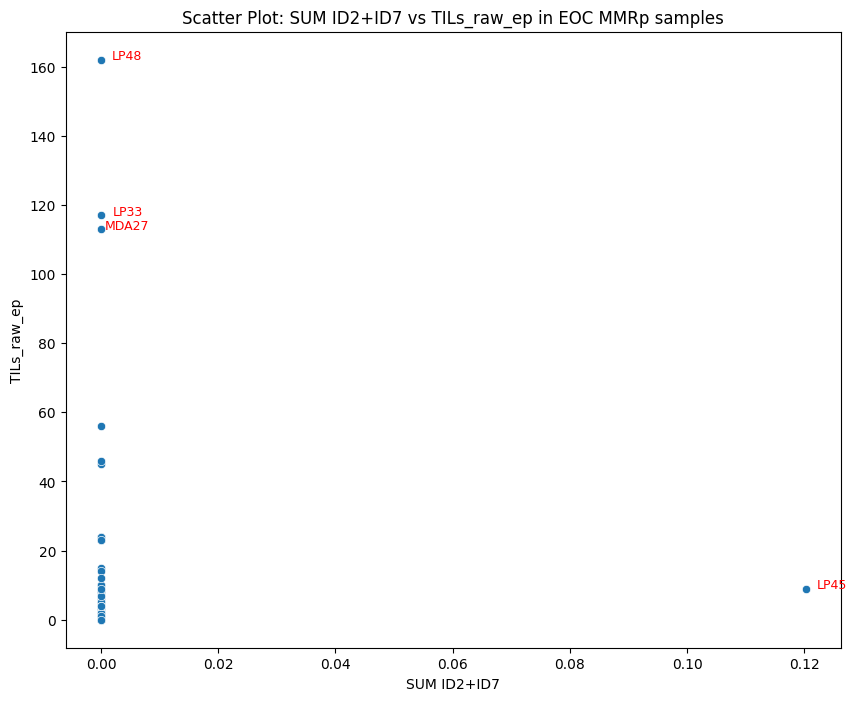

In [11]:
# Scatterplot with annotations for SUM ID2+ID7 vs TILs_raw_ep in EOC MMRp samples #########

# Set figure size to ensure readability of the plot and annotations
plt.figure(figsize=(10, 8))

# Create scatter plot with 'SUM ID2+ID7' on the x-axis and 'TILs_raw_ep' on the y-axis
sns.scatterplot(data=df_eoc_mmrp, y='TILs_raw_ep', x='SUM ID2+ID7')

# Add title and axis labels for context
plt.title("Scatter Plot: SUM ID2+ID7 vs TILs_raw_ep in EOC MMRp samples")
plt.ylabel('TILs_raw_ep')
plt.xlabel('SUM ID2+ID7')

# Filter 
highlighted_samples = df_eoc_mmrp[(df_eoc_mmrp['TILs_raw_ep'] > 100) | (df_eoc_mmrp['SUM ID2+ID7'] > 0.1)]

# Add annotations 
for _, row in highlighted_samples.iterrows():
    plt.text(row['SUM ID2+ID7'] + 0.0045,  # small offset on x-axis
             row['TILs_raw_ep'] + 0.001,   # small offset on y-axis
             row['ID_CNIO'],             # sample name to annotate
             fontsize=9,                 # font size of annotations
             ha='center',                # horizontal alignment
             color='red')                # color for better visibility

# Display the plot with annotations
plt.show()

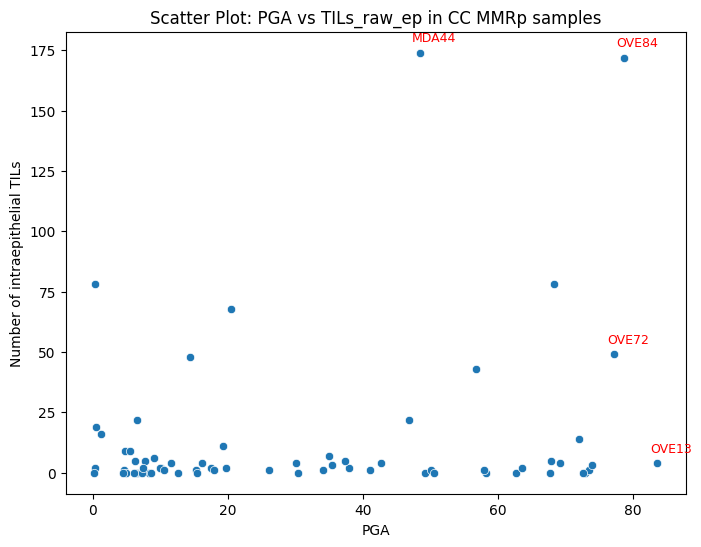

In [12]:
# Scatterplot with annotations for PGA vs 'TILs_raw_ep' in CCOC MMRp
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_cc_mmrp, y='TILs_raw_ep', x='%genome_altered')

# Add title and labels
plt.title("Scatter Plot: PGA vs TILs_raw_ep in CC MMRp samples")
plt.ylabel('Number of intraepithelial TILs')
plt.xlabel('PGA')

# Filter
highlighted_samples = df_cc_mmrp[(df_cc_mmrp['TILs_raw_ep'] > 100) | (df_cc_mmrp['%genome_altered'] > 75)]

# Add annotations
for _, row in highlighted_samples.iterrows():
    plt.text(row['%genome_altered'] + 2,  # small offset on x-axis
             row['TILs_raw_ep'] +4.5,   # small offset on y-axis
             row['ID_CNIO'],             # sample name to annotate
             fontsize=9,                 # font size of annotations
             ha='center',                # horizontal alignment
             color='red')                # color for better visibility
# Show
plt.show()

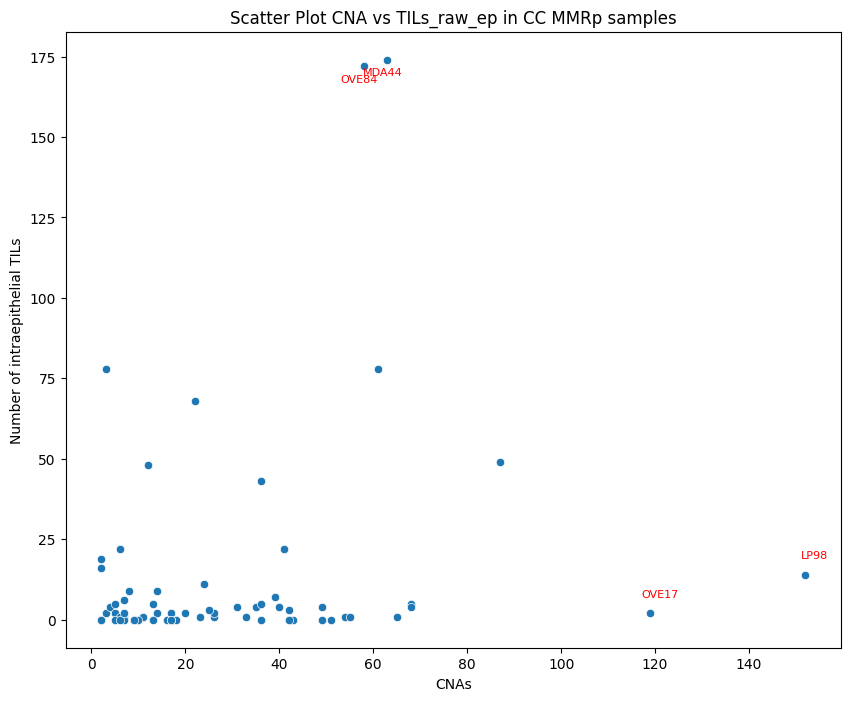

In [13]:
# Scatterplot with annotations for CNAs vs 'TILs_raw_ep' in CCOC MMRp
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_cc_mmrp, y='TILs_raw_ep', x='CNV')

# Add title and labels
plt.title("Scatter Plot CNA vs TILs_raw_ep in CC MMRp samples")
plt.ylabel('Number of intraepithelial TILs')
plt.xlabel('CNAs')

# Filter 
highlighted_samples = df_cc_mmrp[(df_cc_mmrp['TILs_raw_ep'] > 100) | (df_cc_mmrp['CNV'] > 100)]

# Annotate points with sample names, using variable offsets
for i, (_, row) in enumerate(highlighted_samples.iterrows()):
    x_offset = 2 if i % 2 == 0 else -1 # Alternate offset direction
    y_offset = 5 if i % 2 == 0 else -5        # Alternate y offset
    plt.text(row['CNV'] + x_offset, 
             row['TILs_raw_ep'] + y_offset, 
             row['ID_CNIO'],
             fontsize=8,
             ha='center',
             color='red')
# Show
plt.show()

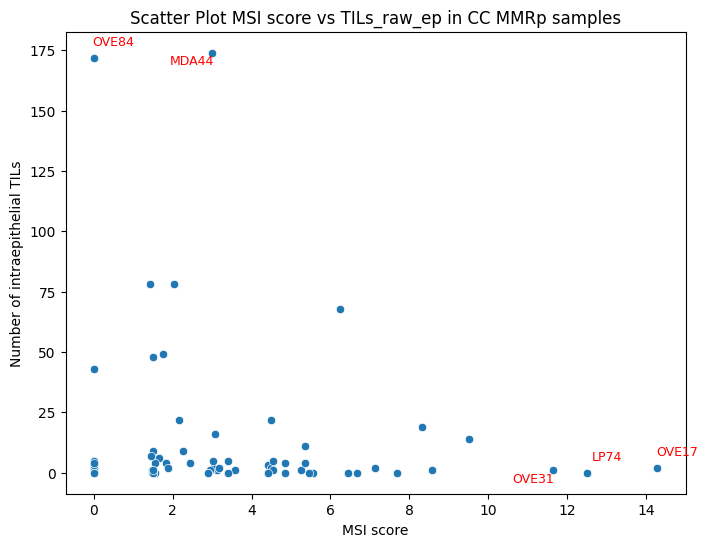

In [14]:
# Plot with annotations for MSI score vs 'TILs_raw_ep' in CCOC MMRp

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_cc_mmrp, y='TILs_raw_ep', x='MSI_sensor2')

# Add title and labels
plt.title("Scatter Plot MSI score vs TILs_raw_ep in CC MMRp samples")
plt.ylabel('Number of intraepithelial TILs')
plt.xlabel('MSI score')

# Filter to identify samples to annotate based on criteria
highlighted_samples = df_cc_mmrp[(df_cc_mmrp['TILs_raw_ep'] > 100) | (df_cc_mmrp['MSI_sensor2'] > 10)]

# Annotate points with sample names, using variable offsets
for i, (_, row) in enumerate(highlighted_samples.iterrows()):
    x_offset = 0.5 if i % 2 == 0 else -0.5 # Alternate offset direction
    y_offset = 5 if i % 2 == 0 else -5        # Alternate y offset
    plt.text(row['MSI_sensor2'] + x_offset, 
             row['TILs_raw_ep'] + y_offset, 
             row['ID_CNIO'],
             fontsize=9,
             ha='center',
             color='red')
# Show
plt.show()

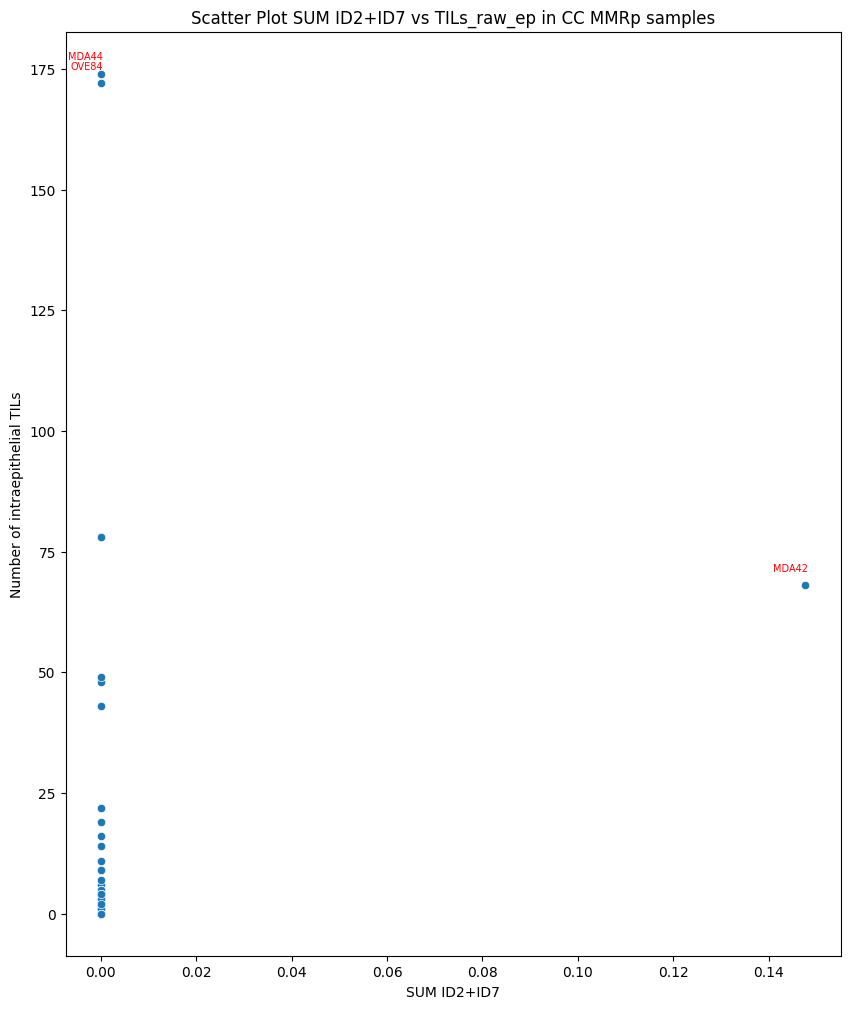

In [15]:
# Plot with annotations for 'SUM ID2+ID7' vs 'TILs_raw_ep' in CCOC MMRp ######
plt.figure(figsize=(10, 12))  # Increased size for better clarity

# Create scatter plot
sns.scatterplot(data=df_cc_mmrp, y='TILs_raw_ep', x='SUM ID2+ID7')

# Add title and labels
plt.title("Scatter Plot SUM ID2+ID7 vs TILs_raw_ep in CC MMRp samples")
plt.ylabel('Number of intraepithelial TILs')
plt.xlabel('SUM ID2+ID7')

# Filter to identify samples to annotate based on criteria
highlighted_samples = df_cc_mmrp[(df_cc_mmrp['TILs_raw_ep'] > 100) | (df_cc_mmrp['SUM ID2+ID7'] > 0.1)]

# Annotate points with sample names, using variable offsets
for i, (_, row) in enumerate(highlighted_samples.iterrows()):
    plt.text(row['SUM ID2+ID7'] + 0.0005, 
             row['TILs_raw_ep'] + 3, 
             row['ID_CNIO'],
             fontsize=7,
             ha='right',
             color='red')

# Show the plot
plt.show()


In [16]:
## We can set up ranges for the number of intraepithelial TILs #################

# Filter CC samples with TILs_raw_ep > 150 and select ID_CNIO and TILs_raw_ep columns
muestras_con_tils_altas_cc = df_cc_mmrp[df_cc_mmrp['TILs_raw_ep'] > 150][['ID_CNIO', 'TILs_raw_ep']]

# Show the results
print("CCOC samples with high TILs values:\n",muestras_con_tils_altas_cc)

# Filter EOC samples with TILs_raw_ep > 150 and select ID_CNIO and TILs_raw_ep columns
muestras_con_tils_altas_eoc = df_eoc_mmrp[df_eoc_mmrp['TILs_raw_ep'] > 150][['ID_CNIO', 'TILs_raw_ep']]

# Show the results
print("EOC samples with high TILs values:\n",muestras_con_tils_altas_eoc)

# Filter the CC samples with TILs_raw_ep between 30 and 120 and select the columns ID_CNIO and TILs_raw_ep
muestras_con_tils_intermedios_cc = df_cc_mmrp[(df_cc_mmrp['TILs_raw_ep'] >= 30) & (df_cc_mmrp['TILs_raw_ep'] <= 120)][['ID_CNIO', 'TILs_raw_ep']]

# Show the result
print("CCOC samples with medium TILs values:\n",muestras_con_tils_intermedios_cc)

# Filter the EOC samples with TILs_raw_ep between 30 and 120 and select the columns ID_CNIO and TILs_raw_ep
muestras_con_tils_intermedios_eoc = df_eoc_mmrp[(df_eoc_mmrp['TILs_raw_ep'] >= 30) & (df_eoc_mmrp['TILs_raw_ep'] <= 120)][['ID_CNIO', 'TILs_raw_ep']]

# Show the results
print("EOC samples with medium TILs values:\n",muestras_con_tils_intermedios_eoc)


CCOC samples with high TILs values:
     ID_CNIO TILs_raw_ep
122   MDA44         174
153   OVE84         172
EOC samples with high TILs values:
    ID_CNIO TILs_raw_ep
38    LP48         162
CCOC samples with medium TILs values:
           ID_CNIO TILs_raw_ep
69           LP84          78
120         MDA42          68
124         MDA46          48
128         MDA50          78
129  MDA51_T1_CCC          43
148         OVE72          49
EOC samples with medium TILs values:
     ID_CNIO TILs_raw_ep
2       LP3          56
25     LP32          45
26     LP33         117
105   MDA27         113
158   OVE93          46
